In [1]:
import re
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt 
import string
import math
import random
import re # regular expression library; for tokenization of words
import time
import sentencepiece
import transformers
import torch

from collections import Counter # collections library; counter: dict subclass for counting hashable objects
from pomocne_soubory.utils_pos import get_word_tag, preprocess
from pomocne_soubory.utils2 import get_dict

import emoji
import pickle

import nltk # import NLTK to handle simple NL tasks like tokenization.
from nltk.tokenize import word_tokenize            
nltk.download("punkt")
from nltk.util import ngrams



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/michaelmateju/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
!pip3 install 'sacrebleu'           # install the sacrebleu package.
import sacrebleu                    # import sacrebleu in order compute the BLEU score.

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Setting this env variable prevents TF warnings from showing up

import tensorflow as tf
import tensorflow_text as tf_text
from pomocne_soubory.utils_nmt_attention import (sentences, train_data, val_data, english_vectorizer, portuguese_vectorizer, masked_loss, masked_acc, tokens_to_text)

In [4]:
import textwrap
wrapper = textwrap.TextWrapper(width=70)


# 1. Natural Language Processing with Probabilistic Models

## 1.1 Machine Translation

Jeden z prvnich modelu, ktery pouzival Attention mechanismus, je model pro preklad textu. V tomto pripade se jedna o 
preklad z anglictiny do francouzstiny. Model se nazyva Seq2Seq model, se kterym prisel v roce 2014 Ilya Sutskever ze spolecnosti Google.
Model se sklada z dvou hlavnich casti: Encoder a Decoder. Encoder prevede vstupni
sekvenci na vektor fixni delky, tzv. embedding dimension, ktery reprezentuje vstupni sekvenci. 
Decoder prevede tento vektor na vystupni sekvenci, opet ruzne delky. V modelu se pouzivaji dva typy RNN: LSTM a GRU, 
abychom se vyhnuli problemu s vanishing/exploding gradientem. 

Encoder vetsinou ma embedding layer, ktery prevede slova na vektory, RNN, ktery prevede vektory na jeden vektor, 
ktery zachycuje vyznam vstupni sekvence. 

![Seq2Seq](../pomocne_soubory/seq2seq_1.png)

Decoder ma take embedding layer, ktery prevede slova na vektory, RNN, ktery prevede vektor na sekvenci vystupnich 
slov. Prvni slovo je vzdy <start>, ktere se prevede na vektor a ten se pouzije jako vstup do RNN. RNN pak vygeneruje
dalsi slovo, ktere se pouzije jako vstup do dalsi iterace. Tento proces se opakuje, dokud model nevygeneruje <end>
slovo nebo nedosahne maximalni delky vystupni sekvence.

![Seq2Seq](../pomocne_soubory/seq2seq_2.png)

Hlavni nevyhodou modelu je tzv. information bottleneck, kdy je cela informace z vstupni sekvence zakodovana do jednoho
vektoru fixni delky. Pro velmi dlouhe vstupni sekvence muze byt tento vektor prilis kratky a neobsahovat dostatek 
informaci. Resenim by mohlo byt pouzit vsechny vstupni hidden states z encoderu do decoderu, ale to zase vede k 
pretizeni pameti a vypoctu. Proto vznikl Attention mechanismus, ktery umoznuje modelu se zamirit na ruzne casti
vstupni sekvence pri generovani vystupni sekvence.

![Seq2Seq](../pomocne_soubory/seq2seq_3.png)

Attention mechasmus zkombinuje vsechny hidden states z encoderu a vytvori novy vektor, ktery se nazyva context vector. 
Zkombinuje = affini soucet hidden states z encoderu a vahy, ktere urcuji, jak moc se ma brat v potaz dany hidden 
state. Vahy zavisi na aktualnim hidden state z decoderu a vsechny hidden states z encoderu.

![Seq2Seq](../pomocne_soubory/seq2seq_4.png)

Vahy se napocitavaji pri treniniku modelu. 

![Seq2Seq](../pomocne_soubory/seq2seq_5.png)

### LAB: Basic Attention

In [5]:
def softmax(x, axis=0):
    """ Calculate softmax function for an array x along specified axis
    
        axis=0 calculates softmax across rows which means each column sums to 1 
        axis=1 calculates softmax across columns which means each row sums to 1
    """
    return np.exp(x) / np.expand_dims(np.sum(np.exp(x), axis=axis), axis)

1: Calculating alignment scores

The first step is to calculate the alignment scores. This is a measure of similarity between the decoder hidden state and each encoder hidden state. From the paper, this operation looks like

$$
\large e_{ij} = v_a^\top \tanh{\left(W_a s_{i-1} + U_a h_j\right)}
$$

where $W_a \in \mathbb{R}^{n\times m}$, $U_a \in \mathbb{R}^{n \times m}$, and $v_a \in \mathbb{R}^m$
are the weight matrices and $n$ is the hidden state size. In practice, this is implemented as a feedforward neural network with two layers, where $m$ is the size of the layers in the alignment network. 

Here $h_j$ are the encoder hidden states for each input step $j$ and $s_{i - 1}$ is the decoder hidden state of the previous step. The first layer corresponds to $W_a$ and $U_a$, while the second layer corresponds to $v_a$.

To implement this, first concatenate the encoder and decoder hidden states to produce an array with size $K \times 2n$ where $K$ is the number of encoder states/steps. For this, use `np.concatenate` ([docs](https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html)). Note that there is only one decoder state so you'll need to reshape it to successfully concatenate the arrays. The easiest way is to use `decoder_state.repeat` ([docs](https://numpy.org/doc/stable/reference/generated/numpy.repeat.html#numpy.repeat)) to match the hidden state array size.

Then, apply the first layer as a matrix multiplication between the weights and the concatenated input. Use the tanh function to get the activations. Finally, compute the matrix multiplication of the second layer weights and the activations. This returns the alignment scores.

In [6]:
hidden_size = 16
attention_size = 10
input_length = 5

np.random.seed(42)

# Synthetic vectors used to test
encoder_states = np.random.randn(input_length, hidden_size)
decoder_state = np.random.randn(1, hidden_size)

# Weights for the neural network, these are typically learned through training
# Use these in the alignment function below as the layer weights
layer_1 = np.random.randn(2 * hidden_size, attention_size)
layer_2 = np.random.randn(attention_size, 1)

# Implement this function. Replace None with your code. Solution at the bottom of the notebook
def alignment(encoder_states, decoder_state):
    # First, concatenate the encoder states and the decoder state
    inputs = np.concatenate((encoder_states, decoder_state.repeat(input_length, axis=0)), axis=1)
    assert inputs.shape == (input_length, 2 * hidden_size)
    
    # Matrix multiplication of the concatenated inputs and layer_1, with tanh activation
    activations = np.tanh(np.matmul(inputs, layer_1))
    assert activations.shape == (input_length, attention_size)
    
    # Matrix multiplication of the activations with layer_2. Remember that you don't need tanh here
    scores = np.matmul(activations, layer_2)
    assert scores.shape == (input_length, 1)
    
    return scores

In [7]:
# Run this to test your alignment function
scores = alignment(encoder_states, decoder_state)
print(scores)

[[4.35790943]
 [5.92373433]
 [4.18673175]
 [2.11437202]
 [0.95767155]]


2: Turning alignment into weights

The next step is to calculate the weights from the alignment scores. These weights determine the encoder outputs that are the most important for the decoder output. These weights should be between 0 and 1. You can use the softmax function (which is already implemented above) to get these weights from the attention scores. Pass the attention scores vector to the softmax function to get the weights. Mathematically,

$$
\large \alpha_{ij} = \frac{\exp{\left(e_{ij}\right)}}{\sum_{k=1}^K \exp{\left(e_{ik}\right)}}
$$



3: Weight the encoder output vectors and sum

The weights tell you the importance of each input word with respect to the decoder state. In this step, you use the weights to modulate the magnitude of the encoder vectors. Words with little importance will be scaled down relative to important words. Multiply each encoder vector by its respective weight to get the alignment vectors, then sum up the weighted alignment vectors to get the context vector. Mathematically,

$$
\large c_i = \sum_{j=1}^K\alpha_{ij} h_{j}
$$

Implement these steps in the `attention` function below.

In [8]:
# Implement this function. Replace None with your code.
def attention(encoder_states, decoder_state):
    """ Example function that calculates attention, returns the context vector 
    
        Arguments:
        encoder_vectors: NxM numpy array, where N is the number of vectors and M is the vector length
        decoder_vector: 1xM numpy array, M is the vector length, much be the same M as encoder_vectors
    """ 
    
    # First, calculate the alignment scores
    scores = alignment(encoder_states, decoder_state)
    
    # Then take the softmax of the alignment scores to get a weight distribution
    weights = softmax(scores)
    
    # Multiply each encoder state by its respective weight
    weighted_scores = encoder_states * weights
    
    # Sum up weighted alignment vectors to get the context vector and return it
    context = np.sum(weighted_scores, axis=0)
    return context

context_vector = attention(encoder_states, decoder_state)
print(context_vector)

[-0.63514569  0.04917298 -0.43930867 -0.9268003   1.01903919 -0.43181409
  0.13365099 -0.84746874 -0.37572203  0.18279832 -0.90452701  0.17872958
 -0.58015282 -0.58294027 -0.75457577  1.32985756]


### Attention mechanism

Pro pochopeni jak funguje attention mechanismus viz tenhle post: https://jalammar.github.io/illustrated-transformer/

### LAB: Attention Mechanism - Scaled dot-product attention

In [9]:
# Load the word2int dictionaries
with open("./pomocne_soubory/word2int_en.pkl", "rb") as f:
    en_words = pickle.load(f)
    
with open("./pomocne_soubory/word2int_fr.pkl", "rb") as f:
    fr_words = pickle.load(f)

# Load the word embeddings
en_embeddings = np.load("./pomocne_soubory/embeddings_en.npz")["embeddings"]
fr_embeddings = np.load("./pomocne_soubory/embeddings_fr.npz")["embeddings"]

In [10]:
# Define some helper functions

def tokenize(sentence, token_mapping):
    tokenized = []
    
    for word in sentence.lower().split(" "):
        try:
            tokenized.append(token_mapping[word])
        except KeyError:
            # Using -1 to indicate an unknown word
            tokenized.append(-1)
        
    return tokenized


def embed(tokens, embeddings):
    embed_size = embeddings.shape[1]
    
    output = np.zeros((len(tokens), embed_size))
    for i, token in enumerate(tokens):
        if token == -1:
            output[i] = np.zeros((1, embed_size))
        else:
            output[i] = embeddings[token]
            
    return output

The scaled-dot product attention consists of two matrix multiplications and a softmax scaling as shown in the diagram below from [Vaswani, et al. (2017)](https://arxiv.org/abs/1706.03762). It takes three input matrices, the queries, keys, and values.

![scaled-dot product attention diagram](../pomocne_soubory/attention.png)

Mathematically, this is expressed as:
$$ 
\large \mathrm{Attention}\left(Q, K, V\right) = \mathrm{softmax}\left(\frac{QK^{\top}}{\sqrt{d_k}}\right)V
$$

where $Q$, $K$, and $V$ are the queries, keys, and values matrices respectively, and $d_k$ is the dimension of the keys. In practice, Q, K, and V all have the same dimensions. This form of attention is faster and more space-efficient than what you implemented before since it consists of only matrix multiplications instead of a learned feed-forward layer.

Conceptually, the first matrix multiplication is a measure of the similarity between the queries and the keys. This is transformed into weights using the softmax function. These weights are then applied to the values with the second matrix multiplication resulting in output attention vectors. Typically, decoder states are used as the queries while encoder states are the keys and values.

Exercise 1

Implement the softmax function with Numpy and use it to calculate the weights from the queries and keys. Assume the queries and keys are 2D arrays (matrices). Note that since the dot-product of Q and K will be a matrix, you'll need to calculate softmax over a specific axis. See the end of the notebook for solutions.

In [11]:
def softmax(x, axis=0):    
    """ Calculate softmax function for an array x

        axis=0 calculates softmax across rows which means each column sums to 1 
        axis=1 calculates softmax across columns which means each row sums to 1
    """
    # Replace pass with your code.
    y = np.exp(x) 
    return y / np.expand_dims(np.sum(y, axis=axis), axis)

def calculate_weights(queries, keys):
    """ Calculate the weights for scaled dot-product attention"""
    #Replace None with your code.
    dot = np.matmul(queries, keys.T)/np.sqrt(keys.shape[1])
    weights = softmax(dot, axis=1)
    
    assert weights.sum(axis=1)[0] == 1, "Each row in weights must sum to 1"
    
    #Replace pass with your code.
    return weights

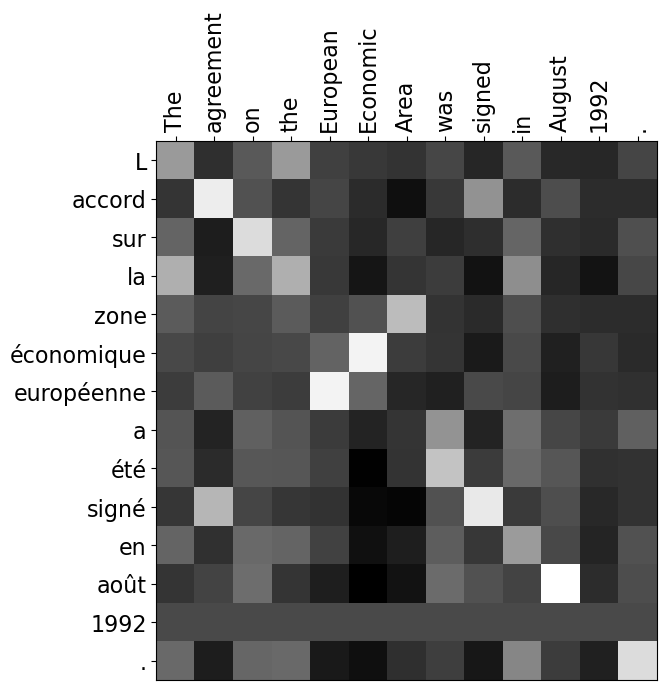

In [12]:
# Tokenize example sentences in English and French, then get their embeddings
sentence_en = "The agreement on the European Economic Area was signed in August 1992 ."
tokenized_en = tokenize(sentence_en, en_words)
embedded_en = embed(tokenized_en, en_embeddings)

sentence_fr = "L accord sur la zone économique européenne a été signé en août 1992 ."
tokenized_fr = tokenize(sentence_fr, fr_words)
embedded_fr = embed(tokenized_fr, fr_embeddings)

# These weights indicate alignment between words in English and French
alignment = calculate_weights(embedded_fr, embedded_en)

# Visualize weights to check for alignment
fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(alignment, cmap='gray')
ax.xaxis.tick_top()
ax.set_xticks(np.arange(alignment.shape[1]))
ax.set_xticklabels(sentence_en.split(" "), rotation=90, size=16);
ax.set_yticks(np.arange(alignment.shape[0]));
ax.set_yticklabels(sentence_fr.split(" "), size=16);

In [13]:
def attention_qkv(queries, keys, values):
    """ Calculate scaled dot-product attention from queries, keys, and values matrices """
    weights = calculate_weights(queries, keys)
    return np.matmul(weights, values)


attention_qkv_result = attention_qkv(embedded_fr, embedded_en, embedded_en)

print(f"The shape of the attention_qkv function is{attention_qkv_result.shape}")
print(f"Some elements of the attention_qkv function are\n{attention_qkv_result[0:2,:10]}")

The shape of the attention_qkv function is(14, 300)
Some elements of the attention_qkv function are
[[-0.04039161 -0.00275749  0.00389873  0.04842744 -0.02472726  0.01435613
  -0.00370253 -0.0619686  -0.00206159  0.01615228]
 [-0.04083253 -0.00245985  0.00409068  0.04830341 -0.02479128  0.01447497
  -0.00355203 -0.06196036 -0.00241327  0.01582606]]


## 1.2 Setup for machine translation

Data preprocessing bude vysvelen v dalsim LABu

**Teacher Forcing** - je technika, ktera se pouziva pri trenovani modelu. V kazdem kroku modelu se pouzije skutecne 
slovo z vystupni sekvence, nikoli predikovane slovo. Tato technika zrychluje trenovani modelu, ale muze zpusobit, ze 
model se bude chovat jinak pri trenovani a pri predikci. 

Existuje varianta, ktera se jmenuje **Curriculum Learning**, ktera
pouziva Teacher Forcing v case zacina vice a vice pouzivat predikovane slovo misto skutecneho slova.

K teto technice existuje i opacna technika, ktera se nazyva **Scheduled Sampling**, ktera nahrazuje skutecne slovo s 
predikovanym slovem s urcitou pravdepodobnosti.


V LABu bude varianta modelu NMT (Neural Machine Translation), ktera pouziva Attention mechanismus. Model bude prekladat
text z anglictiny do francouzstiny. Varianta spociva v tom, ze bude obsahovat encoder a pre-attention decoder, 
spolecne se pak spoji v attention mechanismus a vysledek se pouzije v post-attention decoderu.

![scaled-dot product attention diagram](../pomocne_soubory/nmt_1.png)

![scaled-dot product attention diagram](../pomocne_soubory/nmt_2.png)

## 1.3 Machine Translation Evaluation

### BLEU Score

BLEU (Bilingual Evaluation Understudy) je metrika pro mereni kvality prekladu. Jedna se o precision metriku a 
napocitava tzv. n-gram precision. 

BLEU napocitava pocet shodnych n-gramu mezi predikovanou a skutecnou sekvenci (nebo sekvencich). Resp. jde po kazdem 
n-gramu v predikovane sekvenci a kouka se, zda-li se objevila v prekladu. Pokud ano, tak se zvysi pocet. Tj. jedna se
 opravdu o precision metriku.
Nicmene, kazdy n-gram ze skutecne sekvence se muze vyskytnout nejvyse jedenkrat v predikovane sekvenci. Tj. pocet se 
 pocita jako min(pocet vyskytu slova ve skutecne sekvenci, pocet vyskytu slova ve predikovane sekvenci).

BLEU Score se pocita jako geometricke prumer aritmetickych hodnot precisionu pro kazdy n-gram. 

Nevyhoda BLEU je, ze n-gram precision nebere v potaz poradi slov. Tj. pokud je ve skutecne sekvenci slovo na jinem
mistě nez v predikovane sekvenci, tak se to nepocita jako chyba.

### LAB: BLEU Score

$$
BLEU = BP\times\Bigl( \prod_{i=1}^{n}precision_i\Bigr)^{(1/n)}.\tag{1}
$$

2. BLEU score

2.1 Definitions and formulas

You have seen how to calculate the BLEU score in this week's lectures. Formally, you can express the BLEU score as:
$$
BLEU = BP\times\Bigl( \prod_{i=1}^{n}precision_i \Bigr)^{(1/n)}.\tag{1}
$$

The BLEU score depends on the $BP$, which stands for Brevity Penalty, and the weighted geometric mean precision for different lengths of n-grams, both of which are described below. The product runs from $i=1$ to $i=n$ to account for 1-grams to n-grams and the exponent of $1/n$ is there to calculate the geometrical average. In this notebook, you will use $n=4$

The **Brevity Penalty** is defined as an exponential decay:

$$BP = min\Bigl(1, e^{(1-({len(ref)}/{len(cand)}))}\Bigr),\tag{2}$$

where ${len(ref)}$ and ${len(cand)}$ refer to the length or count of words in the reference and candidate translations. The brevity penalty helps to handle very short translations. 

The **precision** is defined as :

$$precision_i = \frac {\sum_{s_i \in{cand}}min\Bigl(C(s_i, cand), C(s_i, ref)\Bigr)}{\sum_{s_i \in{cand}} C(s_i, cand)}.\tag{3}$$

The sum goes over all the i-grams $s_i$ in the candidate sentence $cand$. $C(s_i, cand)$ and $C(s_i, ref)$ are the counts of the i-grams in the candidate and reference sentences respectively. So the sum counts all the n-grams in the candidate sentence that also appear in the reference sentence, but only counts them as many times as they appear in the reference sentence and not more. This is then divided by the total number of i-grams in the candidate sentence.

2.2 Visualizing the BLEU score

Brevity Penalty:

The brevity penalty penalizes generated translations that are shorter than the reference sentence. It compensates for the fact that the BLEU score has no recall term.

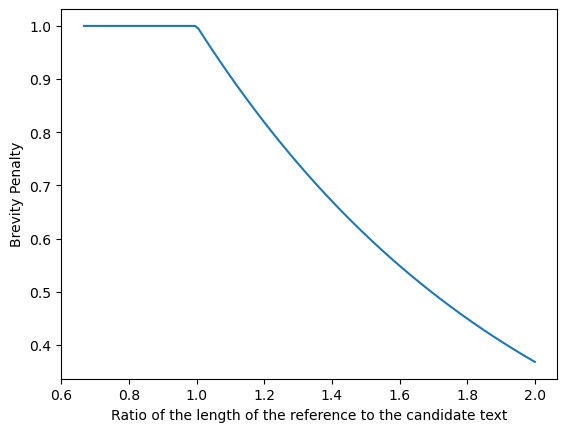

In [14]:
reference_length = 1
candidate_length = np.linspace(1.5, 0.5, 100)

length_ratio = reference_length / candidate_length
BP = np.minimum(1, np.exp(1 - length_ratio))

# Plot the data
fig, ax = plt.subplots(1)
lines = ax.plot(length_ratio, BP)
ax.set(
    xlabel="Ratio of the length of the reference to the candidate text",
    ylabel="Brevity Penalty",
)
plt.show()

N-Gram Precision:

The n-gram precision counts how many n-grams (in your case unigrams, bigrams, trigrams, and four-grams for i =1 , ... , 4) match their n-gram counterpart in the reference translations. This term acts as a precision metric. Unigrams account for adequacy while longer n-grams account for fluency of the translation. To avoid overcounting, the n-gram counts are clipped to the maximal n-gram count occurring in the reference ($m_{n}^{ref}$). Typically precision shows exponential decay with the degree of the n-gram.

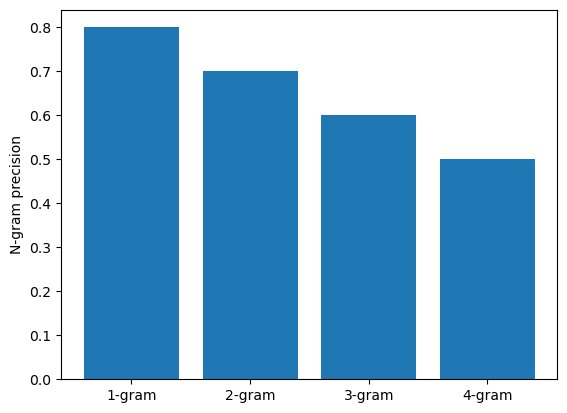

In [15]:
#Mocked dataset showing the precision for different n-grams
data = {"1-gram": 0.8, "2-gram": 0.7, "3-gram": 0.6, "4-gram": 0.5}

# Plot the datapoints defined above
fig, ax = plt.subplots(1)
bars = ax.bar(*zip(*data.items()))
ax.set(ylabel="N-gram precision")
plt.show()

N-gram BLEU score:

When the n-gram precision is normalized by the brevity penalty (BP), then the exponential decay of n-grams is almost fully compensated. The BLEU score corresponds to a geometric average of this modified n-gram precision.

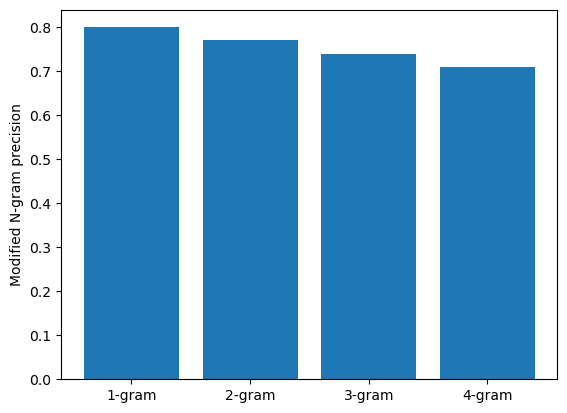

In [16]:
#Mocked dataset showing the precision multiplied by the BP for different n-grams
data = {"1-gram": 0.8, "2-gram": 0.77, "3-gram": 0.74, "4-gram": 0.71}

# Plot the datapoints defined above
fig, ax = plt.subplots(1)
bars = ax.bar(*zip(*data.items()))
ax.set(ylabel="Modified N-gram precision")
plt.show()

3. Example Calculations of the BLEU score

In this example you will have a reference sentence and 2 candidate sentences. You will tokenize all sentences using the NLTK package. Then you will compare the two candidates to the reference using BLEU score.

First you define and tokenize the sentences.

In [17]:
reference = "The NASA Opportunity rover is battling a massive dust storm on planet Mars."
candidate_1 = "The Opportunity rover is combating a big sandstorm on planet Mars."
candidate_2 = "A NASA rover is fighting a massive storm on planet Mars."

tokenized_ref = nltk.word_tokenize(reference.lower())
tokenized_cand_1 = nltk.word_tokenize(candidate_1.lower())
tokenized_cand_2 = nltk.word_tokenize(candidate_2.lower())

print(f"{reference} -> {tokenized_ref}")
print("\n")
print(f"{candidate_1} -> {tokenized_cand_1}")
print("\n")
print(f"{candidate_2} -> {tokenized_cand_2}")

The NASA Opportunity rover is battling a massive dust storm on planet Mars. -> ['the', 'nasa', 'opportunity', 'rover', 'is', 'battling', 'a', 'massive', 'dust', 'storm', 'on', 'planet', 'mars', '.']


The Opportunity rover is combating a big sandstorm on planet Mars. -> ['the', 'opportunity', 'rover', 'is', 'combating', 'a', 'big', 'sandstorm', 'on', 'planet', 'mars', '.']


A NASA rover is fighting a massive storm on planet Mars. -> ['a', 'nasa', 'rover', 'is', 'fighting', 'a', 'massive', 'storm', 'on', 'planet', 'mars', '.']


In [18]:
def brevity_penalty(candidate, reference):
    """
    Calculates the brevity penalty given the candidate and reference sentences.
    """
    reference_length = len(reference)
    candidate_length = len(candidate)

    if reference_length < candidate_length:
        BP = 1
    else:
        penalty = 1 - (reference_length / candidate_length)
        BP = np.exp(penalty)

    return BP

In [19]:
def average_clipped_precision(candidate, reference):
    """
    Calculates the precision given the candidate and reference sentences.
    """

    clipped_precision_score = []
    
    # Loop through values 1, 2, 3, 4. This is the length of n-grams
    for n_gram_length in range(1, 5):
        reference_n_gram_counts = Counter(ngrams(reference, n_gram_length))        
        candidate_n_gram_counts = Counter(ngrams(candidate, n_gram_length))                

        total_candidate_ngrams = sum(candidate_n_gram_counts.values())       
        
        for ngram in candidate_n_gram_counts: 
            # check if it is in the reference n-gram
            if ngram in reference_n_gram_counts:
                # if the count of the candidate n-gram is bigger than the corresponding
                # count in the reference n-gram, then set the count of the candidate n-gram 
                # to be equal to the reference n-gram
                
                if candidate_n_gram_counts[ngram] > reference_n_gram_counts[ngram]: 
                    candidate_n_gram_counts[ngram] = reference_n_gram_counts[ngram] # t
                                                   
            else:
                candidate_n_gram_counts[ngram] = 0 # else set the candidate n-gram equal to zero

        clipped_candidate_ngrams = sum(candidate_n_gram_counts.values())
        
        clipped_precision_score.append(clipped_candidate_ngrams / total_candidate_ngrams)
    
    # Calculate the geometric average: take the mean of elemntwise log, then exponentiate
    # This is equivalent to taking the n-th root of the product as shown in equation (1) above
    s = np.exp(np.mean(np.log(clipped_precision_score)))
    
    return s


In [20]:
def average_clipped_precision_2(candidate, reference):
    """
    Calculates the precision given the candidate and reference sentences.
    """

    clipped_precision_score = []
    
    # Loop through values 1, 2, 3, 4. This is the length of n-grams
    for n_gram_length in range(1, 5):
        reference_n_gram_counts = Counter(ngrams(reference, n_gram_length))        
        candidate_n_gram_counts = Counter(ngrams(candidate, n_gram_length))                

        total_candidate_ngrams = sum(candidate_n_gram_counts.values())       
        
        for ngram in candidate_n_gram_counts: 
            # check if it is in the reference n-gram
            candidate_n_gram_counts[ngram] = min([candidate_n_gram_counts[ngram], reference_n_gram_counts[ngram]])

        clipped_candidate_ngrams = sum(candidate_n_gram_counts.values())
        
        clipped_precision_score.append(clipped_candidate_ngrams / total_candidate_ngrams)
    
    # Calculate the geometric average: take the mean of elemntwise log, then exponentiate
    # This is equivalent to taking the n-th root of the product as shown in equation (1) above
    s = np.exp(np.mean(np.log(clipped_precision_score)))
    
    return s


In [21]:
def bleu_score(candidate, reference):
    BP = brevity_penalty(candidate, reference)    
    geometric_average_precision = average_clipped_precision_2(candidate, reference)    
    return BP * geometric_average_precision

In [22]:
result_candidate_1 = round(bleu_score(tokenized_cand_1, tokenized_ref) * 100, 1)
print(f"BLEU score of reference versus candidate 1: {result_candidate_1}")
result_candidate_2 = round(bleu_score(tokenized_cand_2, tokenized_ref) * 100, 1)
print(f"BLEU score of reference versus candidate 2: {result_candidate_2}")

BLEU score of reference versus candidate 1: 27.6
BLEU score of reference versus candidate 2: 35.3


In [23]:
result_candidate_1 = round(sacrebleu.sentence_bleu(candidate_1, [reference]).score, 1)
print(f"BLEU score of reference versus candidate 1: {result_candidate_1}")
result_candidate_2 = round(sacrebleu.sentence_bleu(candidate_2, [reference]).score, 1)
print(f"BLEU score of reference versus candidate 2: {result_candidate_2}")

BLEU score of reference versus candidate 1: 27.6
BLEU score of reference versus candidate 2: 35.3


4.  BLEU computation on a corpus

4.1 Loading Datasets for Evaluation Using the BLEU Score

In this section, you will use a simple pipeline for evaluating machine translated text. You will use English to German translations generated by [Google Translate](https://translate.google.com). There are three files you will need:

1. A source text in English. In this lab, you will use the first 1671 words of the [wmt19](http://statmt.org/wmt19/translation-task.html) evaluation dataset downloaded via SacreBLEU.
2. A reference translation to German of the corresponding first 1671 words from the original English text. This is also provided by SacreBLEU.
3. A candidate machine translation to German from the same 1671 words. This is generated by Google Translate.

With that, you can now compare the reference and candidate translation to get the BLEU Score.

In [24]:
# Loading the raw data
wmt19_src = open("pomocne_soubory/wmt19_src.txt", "r")
wmt19_src_1 = wmt19_src.read()
wmt19_src.close()

wmt19_ref = open("pomocne_soubory/wmt19_ref.txt", "r")
wmt19_ref_1 = wmt19_ref.read()
wmt19_ref.close()

wmt19_can = open("pomocne_soubory/wmt19_can.txt", "r")
wmt19_can_1 = wmt19_can.read()
wmt19_can.close()

tokenized_corpus_src = nltk.word_tokenize(wmt19_src_1.lower())
tokenized_corpus_ref = nltk.word_tokenize(wmt19_ref_1.lower())
tokenized_corpus_cand = nltk.word_tokenize(wmt19_can_1.lower())

In [25]:
print("English source text:\n")
print(f"{wmt19_src_1[0:170]} -> {tokenized_corpus_src[0:30]}\n\n")
print("German reference translation:\n")
print(f"{wmt19_ref_1[0:219]} -> {tokenized_corpus_ref[0:35]}\n\n")
print("German machine translation:\n")
print(f"{wmt19_can_1[0:199]} -> {tokenized_corpus_cand[0:29]}")

English source text:

﻿Welsh AMs worried about 'looking like muppets'
There is consternation among some AMs at a suggestion their title should change to MWPs (Member of the Welsh Parliament).
 -> ['\ufeffwelsh', 'ams', 'worried', 'about', "'looking", 'like', "muppets'", 'there', 'is', 'consternation', 'among', 'some', 'ams', 'at', 'a', 'suggestion', 'their', 'title', 'should', 'change', 'to', 'mwps', '(', 'member', 'of', 'the', 'welsh', 'parliament', ')', '.']


German reference translation:

﻿Walisische Ageordnete sorgen sich "wie Dödel auszusehen"
Es herrscht Bestürzung unter einigen Mitgliedern der Versammlung über einen Vorschlag, der ihren Titel zu MWPs (Mitglied der walisischen Parlament) ändern soll.
 -> ['\ufeffwalisische', 'ageordnete', 'sorgen', 'sich', '``', 'wie', 'dödel', 'auszusehen', "''", 'es', 'herrscht', 'bestürzung', 'unter', 'einigen', 'mitgliedern', 'der', 'versammlung', 'über', 'einen', 'vorschlag', ',', 'der', 'ihren', 'titel', 'zu', 'mwps', '(', 'mitglied', 'der

In [26]:
result =  round(sacrebleu.sentence_bleu(wmt19_can_1, [wmt19_ref_1]).score, 1)
print(f"BLEU score of the reference versus candidate translation: {result}")

BLEU score of the reference versus candidate translation: 43.2


4.6 BLEU Score Interpretation on a Corpus

The table below (taken from [here](https://cloud.google.com/translate/automl/docs/evaluate)) shows the typical values of BLEU score. You can see that the translation above is of high quality according to this table and in comparison to the given reference sentence. (*if you see "Hard to get the gist", please open your workspace, delete `wmt19_can.txt` and get the latest version via the Lab Help button*)

|Score      | Interpretation                                                |
|:---------:|:-------------------------------------------------------------:|
| < 10      | Almost useless                                                |
| 10 - 19   | Hard to get the gist                                          |
| 20 - 29   | The gist is clear, but has significant grammatical errors     |
| 30 - 40   | Understandable to good translations                           |
| 40 - 50   | High quality translations                                     |
| 50 - 60   | Very high quality, adequate, and fluent translations          |
| > 60      | Quality often better than human                               |

### ROUGE Score

ROUGE (Recall-Oriented Understudy for Gisting Evaluation) je metrika pro mereni kvality prekladu. Je to recall metrika,
ktera pocita podobnost mezi predikovanou a skutecnou sekvenci.
Puvodne byl ROUGE vyvinut pro mereni kvality automatickeho sumarizovani textu, ale pozdeji byl pouzit i pro mereni
kvality prekladu.

ROUGE se deli na nekolik typu: ROUGE-N, ROUGE-L, ROUGE-W, ROUGE-S, ROUGE-SU.
- ROUGE-N: pocita n-gram recall
- ROUGE-L: pocita longest common subsequence recall
- ROUGE-W: pocita weighted LCS recall
- ROUGE-S: pocita skip-bigram recall
- ROUGE-SU: pocita skip-bigram recall s unigramy

ROUGE-N: pocita n-gram recall.

Pocita se jako pocet shodnych n-gramu v predikovane a skutecne sekvenci deleno pocet n-gramu ve skutecne sekvenci. 
Nicmene na rozdil od BLEU, ROUGE-N pocita recall, tj. pocet n-gramu, ktere jsou ve skutecne sekvenci a zaroven v
predikovane sekvenci deleno pocet n-gramu ve skutecne sekvenci.

F1 score: je harmonicky prumer precision a recall. Tj.
$$
F1 = \frac{2 \times precision \times recall}{precision + recall}
$$
v nasem pripade:
$$
F1 = \frac{2 \times ROUGE-N_{precision} \times ROUGE-N_{recall}}{ROUGE-N_{precision} + ROUGE-N_{recall}}
$$


Stejne jako v pripade BLEU, ani zamena poradi neni chyba a nebere se v potaz poradi slov.

## 1.4 Sampling and Decoding

- Random Sampling
- Temperature Sampling
- Greedy Decoding


Greedy Decoding - vybira nejpravdepodobnejsi slovo v zaverecnem softmax layer. 
Random Sampling - vybira slovo nahodne podle pravdepodobnosti v zaverecnem softmax layer.
Temperature Sampling - zvetsuje nebo zmensuje pravdepodobnost vyberu slova v zaverecnem softmax layer.

## 1.5 Beam Search

Beam search dela to, ze v kazdem kroku vybira vice slov a pak vybere nejlepsi sekvenci.
Parameter B, beam_width, urcuje, kolik sekvenci se vybere v kazdem kroku. Vybiraji se slova, dokud vsech B 
nejpravdepodobnejsich sekvenci neni konecna sekvence.

Greedy Sampling je specialni pripad beam search s beam_width = 1.

![scaled-dot product attention diagram](../pomocne_soubory/beam_search_1.png)

Pro dekodovani, si nejprve zavolam decoder na prvni token ve vete: <start> nebo taky nekdy <sos> (start of sentence).
 Vybereme B nejpravdepodobnejsich slov a jejich pravdepodobnosti. Tyto sekvence se ulozi do beam. Pak se zavola 
 decoder na kazdy token v beamu a vybere se B nejpravdepodobnejsich sekvenci. Tento proces se opakuje, dokud neni 
 konecna sekvence.

![scaled-dot product attention diagram](../pomocne_soubory/beam_search_2.png)

Defaultni vanila verze beam search ma nektere nevyhody:
- penalizuje dlouhe sekvence, coz je dusledek, ze se jedna o soucin pravdepodobnosti slov v sekvenci. To lze 
    resit, ze soucin normalizuje delkou vety.
- vyzaduje vice pameti, protoze si uchovava B nejpravdepodobnejsich sekvenci.

## 1.6 Minimum Bayes Risk Decoding

The Minimum Bayes Risk (MBR) decoding algorithm in the context of neural machine translation aims to find a 
translation that minimizes the expected loss (or risk) based on a given loss function. Here, we will use the ROUGE 
score as the loss function to illustrate the process.

### Key Concepts

1. **Hypothesis Space ($\mathcal{H}$)**: The set of possible translations generated by the NMT model.
2. **Reference Translations ($R$)**: The set of true translations (often one or more reference translations).
3. **Loss Function**: Measures the difference between the hypothesis and the reference. We will use the ROUGE score, 
which evaluates the quality of a summary (or translation) by comparing it to reference summaries (or translations).

### Expected Loss and MBR

The goal of MBR is to find a hypothesis $ \hat{h} $ that minimizes the expected loss. Formally,

$$ \hat{h} = \arg \min_{h \in \mathcal{H}} \mathbb{E}_{h' \sim P(h'|x)} [L(h, h')] $$

where:
- $ h $ is a hypothesis translation.
- $ x $ is the source sentence.
- $ P(h'|x) $ is the probability of generating hypothesis $ h' $ given the source sentence $ x $.
- $ L(h, h') $ is the loss function measuring the difference between hypotheses $ h $ and $ h' $.

Using the ROUGE score as the loss function $ L(h, h') $:

$$ L(h, h') = 1 - \text{ROUGE}(h, h') $$

### Algorithm Steps

1. **Generate Hypotheses**: Generate a set of possible translations $ \mathcal{H} = \{ h_1, h_2, \ldots, h_n \} $ using the NMT model.
2. **Calculate Pairwise ROUGE**: Compute the ROUGE score between all pairs of hypotheses $ (h_i, h_j) $.
3. **Compute Expected Loss**: For each hypothesis $ h_i $, compute the expected loss:

   $$
   \mathbb{E}_{h' \sim P(h'|x)} [L(h_i, h')] = \sum_{h_j \in \mathcal{H}} P(h_j|x) L(h_i, h_j)
   $$

   Since $ L(h_i, h_j) = 1 - \text{ROUGE}(h_i, h_j) $, we get:

   $$
   \mathbb{E}_{h' \sim P(h'|x)} [L(h_i, h')] = \sum_{h_j \in \mathcal{H}} P(h_j|x) (1 - \text{ROUGE}(h_i, h_j))
   $$

4. **Select Minimum Risk Hypothesis**: Choose the hypothesis $ \hat{h} $ with the minimum expected loss:

   $$
   \hat{h} = \arg \min_{h_i \in \mathcal{H}} \sum_{h_j \in \mathcal{H}} P(h_j|x) (1 - \text{ROUGE}(h_i, h_j))
   $$

### Example Calculation

Let's consider an example with 3 hypotheses $ \{h_1, h_2, h_3\} $ and their pairwise ROUGE-1 scores:

| Hypotheses | $ h_1 $ | $ h_2 $ | $ h_3 $ |
|------------|-----------|-----------|-----------|
| $ h_1 $  | 1.0       | 0.8       | 0.6       |
| $ h_2 $  | 0.8       | 1.0       | 0.7       |
| $ h_3 $  | 0.6       | 0.7       | 1.0       |

Assume equal probabilities $ P(h_i|x) = \frac{1}{3} $:

$$
\mathbb{E}_{h' \sim P(h'|x)} [L(h_1, h')] = \frac{1}{3}(1-1.0) + \frac{1}{3}(1-0.8) + \frac{1}{3}(1-0.6) = 0.2
$$

$$
\mathbb{E}_{h' \sim P(h'|x)} [L(h_2, h')] = \frac{1}{3}(1-0.8) + \frac{1}{3}(1-1.0) + \frac{1}{3}(1-0.7) = 0.1667
$$

$$
\mathbb{E}_{h' \sim P(h'|x)} [L(h_3, h')] = \frac{1}{3}(1-0.6) + \frac{1}{3}(1-0.7) + \frac{1}{3}(1-1.0) = 0.2333
$$

Since $ \mathbb{E}_{h' \sim P(h'|x)} [L(h_2, h')] $ is the minimum, the chosen hypothesis $ \hat{h} $ is $ h_2 $.

V nasem pripade se to da jeste zjednodusit, protoze predpokladame, ze vsechny preklady mohou vzniknout se stejnou pravdepodobnosti, takze ze vzorce odpadne $ P(h_i|x)$ a nahradi se konstantou. Dale $argmin (1-ROUGE) = argmax(ROUGE)$.
Takze vzorec pak vypada nasledovně:
$$
\arg\max_{\hat{y}} \frac{1}{n}\sum_{y \in Y} ROUGE(\hat{y}, y)
$$
kde $Y$ je mnozina vsech moznych prekladu a $n$ je pocet vsech moznych prekladu, $n$ je velikost beamu, resp. pocet 
kandidat, tj. $n = |Y|$.

![mbr](../pomocne_soubory/mbr_1.png)

Algoritmus metody je nasledujici:
1. Vytvori se B nejpravdepodobnejsich sekvenci - kandidatu.
2. Pro kazdy pár sekvenci se spocita similarity metrika nebo loss function jako je treba ROUGE score (nebo BLEU)
3. Vybere se sekvence, ktera ma vuci ostatnim kandidatum nejvyssi similarity metriku nebo nejnizsi loss.

![mbr](../pomocne_soubory/mbr_2.png)

## LAB: Neural Machine Translation with Attention Mechanism

1. Data Preparation

The text pre-processing bits have already been taken care of (if you are interested in this be sure to check the `utils.py` file). The steps performed can be summarized as:

- Reading the raw data from the text files
- Cleaning the data (using lowercase, adding space around punctuation, trimming whitespaces, etc)
- Splitting it into training and validation sets
- Adding the start-of-sentence and end-of-sentence tokens to every sentence
- Tokenizing the sentences
- Creating a Tensorflow dataset out of the tokenized sentences

Take a moment to inspect the raw sentences:

In [27]:
portuguese_sentences, english_sentences = sentences

print(f"English (to translate) sentence:\n\n{english_sentences[-5]}\n")
print(f"Portuguese (translation) sentence:\n\n{portuguese_sentences[-5]}")

English (to translate) sentence:

No matter how much you try to convince people that chocolate is vanilla, it'll still be chocolate, even though you may manage to convince yourself and a few others that it's vanilla.

Portuguese (translation) sentence:

Não importa o quanto você tenta convencer os outros de que chocolate é baunilha, ele ainda será chocolate, mesmo que você possa convencer a si mesmo e poucos outros de que é baunilha.


In [28]:
del portuguese_sentences
del english_sentences
del sentences

Notice that you imported an `english_vectorizer` and a `portuguese_vectorizer` from `utils.py`. These were created using [tf.keras.layers.TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) and they provide interesting features such as ways to visualize the vocabulary and convert text into tokenized ids and vice versa. In fact, you can inspect the first ten words of the vocabularies for both languages:

In [29]:
print(f"First 10 words of the english vocabulary:\n\n{english_vectorizer.get_vocabulary()[:10]}\n")
print(f"First 10 words of the portuguese vocabulary:\n\n{portuguese_vectorizer.get_vocabulary()[:10]}")

First 10 words of the english vocabulary:

['', '[UNK]', '[SOS]', '[EOS]', '.', 'tom', 'i', 'to', 'you', 'the']

First 10 words of the portuguese vocabulary:

['', '[UNK]', '[SOS]', '[EOS]', '.', 'tom', 'que', 'o', 'nao', 'eu']


Notice that the first 4 words are reserved for special words. In order, these are:

- the empty string
- a special token to represent an unknown word
- a special token to represent the start of a sentence
- a special token to represent the end of a sentence

You can see how many words are in a vocabulary by using the `vocabulary_size` method:

In [30]:
# Size of the vocabulary
vocab_size_por = portuguese_vectorizer.vocabulary_size()
vocab_size_eng = english_vectorizer.vocabulary_size()

print(f"Portuguese vocabulary is made up of {vocab_size_por} words")
print(f"English vocabulary is made up of {vocab_size_eng} words")

Portuguese vocabulary is made up of 12000 words
English vocabulary is made up of 12000 words


You can define [tf.keras.layers.StringLookup](https://www.tensorflow.org/api_docs/python/tf/keras/layers/StringLookup) objects that will help you map from words to ids and vice versa. Do this for the portuguese vocabulary since this will be useful later on when you decode the predictions from your model:

In [31]:
# This helps you convert from words to ids
word_to_id = tf.keras.layers.StringLookup(
    vocabulary=portuguese_vectorizer.get_vocabulary(), 
    mask_token="", 
    oov_token="[UNK]"
)

# This helps you convert from ids to words
id_to_word = tf.keras.layers.StringLookup(
    vocabulary=portuguese_vectorizer.get_vocabulary(),
    mask_token="",
    oov_token="[UNK]",
    invert=True,
)

In [32]:
unk_id = word_to_id("[UNK]")
sos_id = word_to_id("[SOS]")
eos_id = word_to_id("[EOS]")
baunilha_id = word_to_id("baunilha")

print(f"The id for the [UNK] token is {unk_id}")
print(f"The id for the [SOS] token is {sos_id}")
print(f"The id for the [EOS] token is {eos_id}")
print(f"The id for baunilha (vanilla) is {baunilha_id}")

The id for the [UNK] token is 1
The id for the [SOS] token is 2
The id for the [EOS] token is 3
The id for baunilha (vanilla) is 7079


Finally take a look at how the data that is going to be fed to the neural network looks like. Both `train_data` and `val_data` are of type `tf.data.Dataset` and are already arranged in batches of 64 examples. To get the first batch out of a tf dataset you can use the `take` method. To get the first example out of the batch you can slice the tensor and use the `numpy` method for nicer printing:

In [33]:
for (to_translate, sr_translation), translation in train_data.take(1):
    print(f"Tokenized english sentence:\n{to_translate[0, :].numpy()}\n\n")
    print(f"Tokenized portuguese sentence (shifted to the right):\n{sr_translation[0, :].numpy()}\n\n")
    print(f"Tokenized portuguese sentence:\n{translation[0, :].numpy()}\n\n")

Tokenized english sentence:
[  2  13 300  59 130   8   7   9 952   4   3   0   0]


Tokenized portuguese sentence (shifted to the right):
[   2  237  243   47   57  299   35 1024    4    0    0    0]


Tokenized portuguese sentence:
[ 237  243   47   57  299   35 1024    4    3    0    0    0]




There are a couple of important details to notice.

- Padding has already been applied to the tensors and the value used for this is 0
- Each example consists of 3 different tensors:
    - The sentence to translate
    - The shifted-to-the-right translation
    - The translation
    
The first two can be considered as the features, while the third one as the target. By doing this your model can perform Teacher Forcing as you saw in the lectures.

Now it is time to begin coding!

2. NMT model with attention

The model you will build uses an encoder-decoder architecture. This Recurrent Neural Network (RNN) takes in a tokenized version of a sentence in its encoder, then passes it on to the decoder for translation. As mentioned in the lectures, just using a a regular sequence-to-sequence model with LSTMs will work effectively for short to medium sentences but will start to degrade for longer ones. You can picture it like the figure below where all of the context of the input sentence is compressed into one vector that is passed into the decoder block. You can see how this will be an issue for very long sentences (e.g. 100 tokens or more) because the context of the first parts of the input will have very little effect on the final vector passed to the decoder.

<img src='pomocne_soubory/plain_rnn.png' width="600">

Adding an attention layer to this model avoids this problem by giving the decoder access to all parts of the input sentence. To illustrate, let's just use a 4-word input sentence as shown below. Remember that a hidden state is produced at each timestep of the encoder (represented by the orange rectangles). These are all passed to the attention layer and each are given a score given the current activation (i.e. hidden state) of the decoder. For instance, let's consider the figure below where the first prediction "como" is already made. To produce the next prediction, the attention layer will first receive all the encoder hidden states (i.e. orange rectangles) as well as the decoder hidden state when producing the word "como" (i.e. first green rectangle). Given this information, it will score each of the encoder hidden states to know which one the decoder should focus on to produce the next word. As a result of training, the model might have learned that it should align to the second encoder hidden state and subsequently assigns a high probability to the word "você". If we are using greedy decoding, we will output the said word as the next symbol, then restart the process to produce the next word until we reach an end-of-sentence prediction.

<img src='pomocne_soubory/attention_overview.png' width="600">


There are different ways to implement attention and the one we'll use for this assignment is the Scaled Dot Product Attention which has the form:

$$Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$$

You will dive deeper into this equation in the next week but for now, you can think of it as computing scores using queries (Q) and keys (K), followed by a multiplication of values (V) to get a context vector at a particular timestep of the decoder. This context vector is fed to the decoder RNN to get a set of probabilities for the next predicted word. The division by square root of the keys dimensionality ($\sqrt{d_k}$) is for improving model performance and you'll also learn more about it next week. For our machine translation application, the encoder activations (i.e. encoder hidden states) will be the keys and values, while the decoder activations (i.e. decoder hidden states) will be the queries.

You will see in the upcoming sections that this complex architecture and mechanism can be implemented with just a few lines of code. 

First you will define two important global variables:

- The size of the vocabulary
- The number of units in the LSTM layers (the same number will be used for all LSTM layers)

In this assignment, the vocabulary sizes for English and Portuguese are the same. Therefore, we use a single constant VOCAB_SIZE throughout the notebook. While in other settings, vocabulary sizes could differ, that is not the case in our assignment.

In [34]:
VOCAB_SIZE = 12000
UNITS = 256

Exercise 1 - Encoder

Your first exercise is to code the encoder part of the neural network. For this, complete the `Encoder` class below. Notice that in the constructor (the `__init__` method) you need to define all of the sublayers of the encoder and then use these sublayers during the forward pass (the `call` method).

The encoder consists of the following layers:

- [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding). For this layer you need to define the appropriate `input_dim` and `output_dim` and let it know that you are using '0' as padding, which can be done by using the appropriate value for the `mask_zero` parameter.
    
+ [Bidirectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional) [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM). In TF you can implement bidirectional behaviour for RNN-like layers. This part is already taken care of but you will need to specify the appropriate type of layer as well as its parameters. In particular you need to set the appropriate number of units and make sure that the LSTM returns the full sequence and not only the last output, which can be done by using the appropriate value for the `return_sequences` parameter.


You need to define the forward pass using the syntax of TF's [functional API](https://www.tensorflow.org/guide/keras/functional_api). What this means is that you chain function calls together to define your network like this:

```python
encoder_input = keras.Input(shape=(28, 28, 1), name="original_img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)
```

In [35]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, units):
        """Initializes an instance of this class

        Args:
            vocab_size (int): Size of the vocabulary
            units (int): Number of units in the LSTM layer
        """
        super(Encoder, self).__init__()

        self.embedding = tf.keras.layers.Embedding(  
            input_dim=vocab_size,
            output_dim=units,
            mask_zero=True
        )  

        self.rnn = tf.keras.layers.Bidirectional(  
            merge_mode="sum",  
            layer=tf.keras.layers.LSTM(
                units=units,
                return_sequences=True
            ),  
        )  

    def call(self, context):
        """Forward pass of this layer

        Args:
            context (tf.Tensor): The sentence to translate

        Returns:
            tf.Tensor: Encoded sentence to translate
        """

        # Pass the context through the embedding layer
        x = self.embedding(context)

        # Pass the output of the embedding through the RNN
        x = self.rnn(x)

        return x

In [36]:
# Do a quick check of your implementation

# Create an instance of your class
encoder = Encoder(VOCAB_SIZE, UNITS)

# Pass a batch of sentences to translate from english to portuguese
encoder_output = encoder(to_translate)

print(f'Tensor of sentences in english has shape: {to_translate.shape}\n')
print(f'Encoder output has shape: {encoder_output.shape}')

Tensor of sentences in english has shape: (64, 13)

Encoder output has shape: (64, 13, 256)


Exercise 2 - CrossAttention

Your next exercise is to code the layer that will perform cross attention between the original sentences and the translations. For this, complete the `CrossAttention` class below. Notice that in the constructor (the `__init__` method) you need to define all of the sublayers and then use these sublayers during the forward pass (the `call` method). For this particular case some of these bits are already taken care of.

The cross attention consists of the following layers:

- [MultiHeadAttention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention). For this layer you need to define the appropriate `key_dim`, which is the size of the key and query tensors. You will also need to set the number of heads to 1 since you aren't implementing multi head attention but attention between two tensors. The reason why this layer is preferred over [Attention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Attention) is that it allows simpler code during the forward pass.
    
A couple of things to notice:
- You need a way to pass both the output of the attention alongside the shifted-to-the-right translation (since this cross attention happens in the decoder side). For this you will use an [Add](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add) layer so that the original dimension is preserved, which would not happen if you use something like a [Concatenate](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate) layer.

+ Layer normalization is also performed for better stability of the network by using a [LayerNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LayerNormalization) layer.

- You don't need to worry about these last steps as these are already solved.



In [37]:
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        """Initializes an instance of this class

        Args:
            units (int): Number of units in the LSTM layer
        """
        super().__init__()

        self.mha = ( 
            tf.keras.layers.MultiHeadAttention(
                key_dim=units,
                num_heads=1
            ) 
        )  

        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, context, target):
        """Forward pass of this layer

        Args:
            context (tf.Tensor): Encoded sentence to translate
            target (tf.Tensor): The embedded shifted-to-the-right translation

        Returns:
            tf.Tensor: Cross attention between context and target
        """

        # Call the MH attention by passing in the query and value
        # For this case the query should be the translation and the value the encoded sentence to translate
        # Hint: Check the call arguments of MultiHeadAttention in the docs
        attn_output = self.mha(
            query=target,
            value=context
        )  

        x = self.add([target, attn_output])

        x = self.layernorm(x)

        return x

In [38]:
# Do a quick check of your implementation

# Create an instance of your class
attention_layer = CrossAttention(UNITS)

# The attention layer expects the embedded sr-translation and the context
# The context (encoder_output) is already embedded so you need to do this for sr_translation:
sr_translation_embed = tf.keras.layers.Embedding(VOCAB_SIZE, output_dim=UNITS, mask_zero=True)(sr_translation)

# Compute the cross attention
attention_result = attention_layer(encoder_output, sr_translation_embed)

print(f'Tensor of contexts has shape: {encoder_output.shape}')
print(f'Tensor of translations has shape: {sr_translation_embed.shape}')
print(f'Tensor of attention scores has shape: {attention_result.shape}')

/Users/michaelmateju/miniconda3/envs/basic/lib/python3.9/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/michaelmateju/miniconda3/envs/basic/lib/python3.9/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/michaelmateju/miniconda3/envs/basic/lib/python3.9/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstr

Tensor of contexts has shape: (64, 13, 256)
Tensor of translations has shape: (64, 12, 256)
Tensor of attention scores has shape: (64, 12, 256)


/Users/michaelmateju/miniconda3/envs/basic/lib/python3.9/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'cross_attention' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Exercise 3 - Decoder


Now you will implement the decoder part of the neural network by completing the `Decoder` class below. Notice that in the constructor (the `__init__` method) you need to define all of the sublayers of the decoder and then use these sublayers during the forward pass (the `call` method).

The decoder consists of the following layers:

- [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding). For this layer you need to define the appropriate `input_dim` and `output_dim` and let it know that you are using '0' as padding, which can be done by using the appropriate value for the `mask_zero` parameter.
  
  
+ Pre-attention [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM). Unlike in the encoder in which you used a Bidirectional LSTM, here you will use a vanilla LSTM. Don't forget to set the appropriate number of units and make sure that the LSTM returns the full sequence and not only the last output, which can be done by using the appropriate value for the `return_sequences` parameter. It is very important that this layer returns the state since this will be needed for inference so make sure to set the `return_state` parameter accordingly. Notice that LSTM layers return state as a tuple of two tensors called `memory_state` and `carry_state`, **however these names have been changed to better reflect what you have seen in the lectures to `hidden_state` and `cell_state` respectively**.

- The attention layer that performs cross attention between the sentence to translate and the right-shifted translation. Here you need to use the `CrossAttention` layer you defined in the previous exercise.

+ Post-attention [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM). Another LSTM layer. For this one you don't need it to return the state.

- Finally a [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer. This one should have the same number of units as the size of the vocabulary since you expect it to compute the logits for every possible word in the vocabulary. Make sure to use a `logsoftmax` activation function for this one, which you can get as [tf.nn.log_softmax](https://www.tensorflow.org/api_docs/python/tf/nn/log_softmax).



In [39]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, units):
        """Initializes an instance of this class

        Args:
            vocab_size (int): Size of the vocabulary
            units (int): Number of units in the LSTM layer
        """
        super(Decoder, self).__init__()

        # The embedding layer
        self.embedding = tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=units,
            mask_zero=True
        )  

        # The RNN before attention
        self.pre_attention_rnn = tf.keras.layers.LSTM(
            units=units,
            return_sequences=True,
            return_state=True
        )  

        # The attention layer
        self.attention = CrossAttention(units)

        # The RNN after attention
        self.post_attention_rnn = tf.keras.layers.LSTM(
            units=units,
            return_sequences=True
        )  

        # The dense layer with logsoftmax activation
        self.output_layer = tf.keras.layers.Dense(
            units=vocab_size,
            activation= tf.nn.log_softmax
        )  

    def call(self, context, target, state=None, return_state=False):
        """Forward pass of this layer

        Args:
            context (tf.Tensor): Encoded sentence to translate
            target (tf.Tensor): The shifted-to-the-right translation
            state (list[tf.Tensor, tf.Tensor], optional): Hidden state of the pre-attention LSTM. Defaults to None.
            return_state (bool, optional): If set to true return the hidden states of the LSTM. Defaults to False.

        Returns:
            tf.Tensor: The log_softmax probabilities of predicting a particular token
        """

        # Get the embedding of the input
        x = self.embedding(target)

        # Pass the embedded input into the pre attention LSTM
        # Hints:
        # - The LSTM you defined earlier should return the output alongside the state (made up of two tensors)
        # - Pass in the state to the LSTM (needed for inference)
        x, hidden_state, cell_state = self.pre_attention_rnn(x, initial_state=state)

        # Perform cross attention between the context and the output of the LSTM (in that order)
        x = self.attention(context, x)

        # Do a pass through the post attention LSTM
        x = self.post_attention_rnn(x)

        # Compute the logits
        logits = self.output_layer(x)

        if return_state:
            return logits, [hidden_state, cell_state]

        return logits

In [40]:
# Do a quick check of your implementation

# Create an instance of your class
decoder = Decoder(VOCAB_SIZE, UNITS)

# Notice that you don't need the embedded version of sr_translation since this is done inside the class
logits = decoder(encoder_output, sr_translation)

print(f'Tensor of contexts has shape: {encoder_output.shape}')
print(f'Tensor of right-shifted translations has shape: {sr_translation.shape}')
print(f'Tensor of logits has shape: {logits.shape}')

/Users/michaelmateju/miniconda3/envs/basic/lib/python3.9/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'cross_attention_1' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Tensor of contexts has shape: (64, 13, 256)
Tensor of right-shifted translations has shape: (64, 12)
Tensor of logits has shape: (64, 12, 12000)


/Users/michaelmateju/miniconda3/envs/basic/lib/python3.9/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'decoder' (of type Decoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Exercise 4 - Translator

Now you have to put together all of the layers you previously coded into an actual model. For this, complete the `Translator` class below. Notice how unlike the Encoder and Decoder classes inherited from `tf.keras.layers.Layer`, the Translator class inherits from `tf.keras.Model`.

Remember that `train_data` will yield a tuple with the sentence to translate and the shifted-to-the-right translation, which are the "features" of the model. This means that the inputs of your network will be tuples containing context and targets.

In [41]:
class Translator(tf.keras.Model):
    def __init__(self, vocab_size, units):
        """Initializes an instance of this class

        Args:
            vocab_size (int): Size of the vocabulary
            units (int): Number of units in the LSTM layer
        """
        super().__init__()

        # Define the encoder with the appropriate vocab_size and number of units
        self.encoder = Encoder(vocab_size, units)

        # Define the decoder with the appropriate vocab_size and number of units
        self.decoder = Decoder(vocab_size, units)

    def call(self, inputs):
        """Forward pass of this layer

        Args:
            inputs (tuple(tf.Tensor, tf.Tensor)): Tuple containing the context (sentence to translate) and the target (shifted-to-the-right translation)

        Returns:
            tf.Tensor: The log_softmax probabilities of predicting a particular token
        """

        # In this case inputs is a tuple consisting of the context and the target, unpack it into single variables
        context, target = inputs[0], inputs[1]

        # Pass the context through the encoder
        encoded_context = self.encoder(context)

        # Compute the logits by passing the encoded context and the target to the decoder
        logits = self.decoder(encoded_context, target)

        return logits

In [42]:
# Do a quick check of your implementation

# Create an instance of your class
translator = Translator(VOCAB_SIZE, UNITS)

# Compute the logits for every word in the vocabulary
logits = translator((to_translate, sr_translation))

print(f'Tensor of sentences to translate has shape: {to_translate.shape}')
print(f'Tensor of right-shifted translations has shape: {sr_translation.shape}')
print(f'Tensor of logits has shape: {logits.shape}')

/Users/michaelmateju/miniconda3/envs/basic/lib/python3.9/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'cross_attention_2' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/michaelmateju/miniconda3/envs/basic/lib/python3.9/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'decoder_1' (of type Decoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Tensor of sentences to translate has shape: (64, 13)
Tensor of right-shifted translations has shape: (64, 12)
Tensor of logits has shape: (64, 12, 12000)


3. Training

In [43]:
def compile_and_train(model, epochs=1, steps_per_epoch=500):
    model.compile(optimizer="adam", loss=masked_loss, metrics=[masked_acc, masked_loss])

    history = model.fit(
        train_data.repeat(),
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_data,
        validation_steps=50,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)],
    )

    return model, history

In [44]:
# epochs=1
# steps_per_epoch=500
# translator.compile(optimizer="adam", loss=masked_loss, metrics=[masked_acc, masked_loss])

# history = translator.fit(
#     train_data.repeat(),
#     epochs=epochs,
#     steps_per_epoch=steps_per_epoch,
#     validation_data=val_data,
#     validation_steps=50,
#     callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)],
# )

In [45]:
# Train the translator (this takes some minutes so feel free to take a break)

trained_translator, history = compile_and_train(translator)

500/500 ━━━━━━━━━━━━━━━━━━━━ 256s 495ms/step - loss: 5.8206 - masked_acc: 0.1513 - masked_loss: 5.8206 - val_loss: 4.3815 - val_masked_acc: 0.3321 - val_masked_loss: 4.3815


4. Using the model for inference 


Now that your model is trained you can use it for inference. To help you with this the `generate_next_token` function is provided. Notice that this function is meant to be used inside a for-loop, so you feed to it the information of the previous step to generate the information of the next step. In particular you need to keep track of the state of the pre-attention LSTM in the decoder and if you are done with the translation. Also notice that a `temperature` variable is introduced which determines how to select the next token given the predicted logits:  

In [46]:
def generate_next_token(decoder, context, next_token, done, state, temperature=0.0):
    """Generates the next token in the sequence

    Args:
        decoder (Decoder): The decoder
        context (tf.Tensor): Encoded sentence to translate
        next_token (tf.Tensor): The predicted next token
        done (bool): True if the translation is complete
        state (list[tf.Tensor, tf.Tensor]): Hidden states of the pre-attention LSTM layer
        temperature (float, optional): The temperature that controls the randomness of the predicted tokens. Defaults to 0.0.

    Returns:
        tuple(tf.Tensor, np.float, list[tf.Tensor, tf.Tensor], bool): The next token, log prob of said token, hidden state of LSTM and if translation is done
    """
    # Get the logits and state from the decoder
    logits, state = decoder(context, next_token, state=state, return_state=True)
    
    # Trim the intermediate dimension 
    logits = logits[:, -1, :]
        
    # If temp is 0 then next_token is the argmax of logits
    if temperature == 0.0:
        next_token = tf.argmax(logits, axis=-1)
        
    # If temp is not 0 then next_token is sampled out of logits
    else:
        logits = logits / temperature
        next_token = tf.random.categorical(logits, num_samples=1)
    
    # Trim dimensions of size 1
    logits = tf.squeeze(logits)
    next_token = tf.squeeze(next_token)
    
    # Get the logit of the selected next_token
    logit = logits[next_token].numpy()
    
    # Reshape to (1,1) since this is the expected shape for text encoded as TF tensors
    next_token = tf.reshape(next_token, shape=(1,1))
    
    # If next_token is End-of-Sentence token you are done
    if next_token == eos_id:
        done = True
    
    return next_token, logit, state, done

In [47]:
# PROCESS SENTENCE TO TRANSLATE AND ENCODE

# A sentence you wish to translate
eng_sentence = "I love languages"

# Convert it to a tensor
texts = tf.convert_to_tensor(eng_sentence)[tf.newaxis]

# Vectorize it and pass it through the encoder
context = english_vectorizer(texts).to_tensor()
context = encoder(context)

# SET STATE OF THE DECODER

# Next token is Start-of-Sentence since you are starting fresh
next_token = tf.fill((1,1), sos_id)

# Hidden and Cell states of the LSTM can be mocked using uniform samples
state = [tf.random.uniform((1, UNITS)), tf.random.uniform((1, UNITS))]

# You are not done until next token is EOS token
done = False

# Generate next token
next_token, logit, state, done = generate_next_token(decoder, context, next_token, done, state, temperature=0.5)
print(f"Next token: {next_token}\nLogit: {logit:.4f}\nDone? {done}")

Next token: [[396]]
Logit: -18.8035
Done? False


Exercise 5 - translate

Now you can put everything together to translate a given sentence. For this, complete the `translate` function below. This function will take care of the following steps: 
- Process the sentence to translate and encode it

+ Set the initial state of the decoder

- Get predictions of the next token (starting with the \<SOS> token) for a maximum of iterations (in case the \<EOS> token is never returned)
    
+ Return the translated text (as a string), the logit of the last iteration (this helps measure how certain was that the sequence was translated in its totality) and the translation in token format.


Hints: 

- The previous cell provides a lot of insights on how this function should work, so if you get stuck refer to it.

+ Some useful docs:
    + [tf.newaxis](https://www.tensorflow.org/api_docs/python/tf#newaxis)

    - [tf.fill](https://www.tensorflow.org/api_docs/python/tf/fill)

    + [tf.zeros](https://www.tensorflow.org/api_docs/python/tf/zeros)


In [48]:
def translate(model, text, max_length=50, temperature=0.0):
    """Translate a given sentence from English to Portuguese

    Args:
        model (tf.keras.Model): The trained translator
        text (string): The sentence to translate
        max_length (int, optional): The maximum length of the translation. Defaults to 50.
        temperature (float, optional): The temperature that controls the randomness of the predicted tokens. Defaults to 0.0.

    Returns:
        tuple(str, np.float, tf.Tensor): The translation, logit that predicted <EOS> token and the tokenized translation
    """
    # Lists to save tokens and logits
    tokens, logits = [], []

    # PROCESS THE SENTENCE TO TRANSLATE
    
    # Convert the original string into a tensor
    text = tf.convert_to_tensor(text)[tf.newaxis]
    
    # Vectorize the text using the correct vectorizer
    context = english_vectorizer(text).to_tensor()
    
    # Get the encoded context (pass the context through the encoder)
    # Hint: Remember you can get the encoder by using model.encoder
    context = model.encoder(context)
    
    # INITIAL STATE OF THE DECODER
    
    # First token should be SOS token with shape (1,1)
    next_token = tf.fill((1,1), sos_id)
    
    # Initial hidden and cell states should be tensors of zeros with shape (1, UNITS)
    state = [tf.zeros((1, UNITS)), tf.zeros((1, UNITS))]
    
    # You are done when you draw a EOS token as next token (initial state is False)
    done = False

    # Iterate for max_length iterations
    for i in range(max_length):
        # Generate the next token
        try:
            next_token, logit, state, done = generate_next_token(
                decoder=model.decoder,
                context=context,
                next_token=next_token,
                done=done,
                state=state,
                temperature=temperature
            )
        except:
             raise Exception("Problem generating the next token")
        
        # If done then break out of the loop
        if done:
            break
        
        # Add next_token to the list of tokens
        tokens.append(next_token)
        
        # Add logit to the list of logits
        logits.append(logit)

    # Concatenate all tokens into a tensor
    tokens = tf.concat(tokens, axis=-1)
    
    # Convert the translated tokens into text
    translation = tf.squeeze(tokens_to_text(tokens, id_to_word))
    translation = translation.numpy().decode()
    
    return translation, logits[-1], tokens

In [49]:
# Running this cell multiple times should return the same output since temp is 0

temp = 0.0 
original_sentence = "I love languages"

translation, logit, tokens = translate(trained_translator, original_sentence, temperature=temp)

print(f"Temperature: {temp}\n\nOriginal sentence: {original_sentence}\nTranslation: {translation}\nTranslation tokens:{tokens}\nLogit: {logit:.3f}")

Temperature: 0.0

Original sentence: I love languages
Translation: eu tom .
Translation tokens:[[9 5 4]]
Logit: -1.761


In [50]:
# Running this cell multiple times should return different outputs since temp is not 0
# You can try different temperatures

temp = 0.7
original_sentence = "I love languages"

translation, logit, tokens = translate(trained_translator, original_sentence, temperature=temp)

print(f"Temperature: {temp}\n\nOriginal sentence: {original_sentence}\nTranslation: {translation}\nTranslation tokens:{tokens}\nLogit: {logit:.3f}")

Temperature: 0.7

Original sentence: I love languages
Translation: tom a ponto .
Translation tokens:[[  5  12 751   4]]
Logit: -1.191


5. Minimum Bayes-Risk Decoding

As mentioned in the lectures, getting the most probable token at each step may not necessarily produce the best results. Another approach is to do Minimum Bayes Risk Decoding or MBR. The general steps to implement this are:

- Take several random samples
+ Score each sample against all other samples
- Select the one with the highest score

You will be building helper functions for these steps in the following sections.

With the ability to generate different translations by setting different temperature values you can do what you saw in the lectures and generate a bunch of translations and then determine which one is the best candidate. You will now do this by using the provided `generate_samples` function. This function will return any desired number of candidate translations alongside the log-probability for each one:

In [51]:
def generate_samples(model, text, n_samples=4, temperature=0.6):
    
    samples, log_probs = [], []

    # Iterate for n_samples iterations
    for _ in range(n_samples):
        
        # Save the logit and the translated tensor
        _, logp, sample = translate(model, text, temperature=temperature)
        
        # Save the translated tensors
        samples.append(np.squeeze(sample.numpy()).tolist())
        
        # Save the logits
        log_probs.append(logp)
                
    return samples, log_probs

In [52]:
samples, log_probs = generate_samples(trained_translator, 'I love languages')

for s, l in zip(samples, log_probs):
    print(f"Translated tensor: {s} has logit: {l:.3f}")

Translated tensor: [9, 5, 4] has logit: -2.935
Translated tensor: [9, 5, 4] has logit: -2.935
Translated tensor: [9, 5, 4] has logit: -2.935
Translated tensor: [9, 9, 14, 22, 198, 4] has logit: -1.717


Comparing overlaps

Now that you can generate multiple translations it is time to come up with a method to measure the goodness of each one. As you saw in the lectures, one way to achieve this is by comparing each sample against the others. 

There are several metrics you can use for this purpose, as shown in the lectures and you can try experimenting with any one of these. For this assignment, you will be calculating scores for **unigram overlaps**. 

One of these metrics is the widely used yet simple [Jaccard similarity](https://en.wikipedia.org/wiki/Jaccard_index) which gets the intersection over union of two sets. The `jaccard_similarity` function returns this metric for any pair of candidate and reference translations:


In [53]:
def jaccard_similarity(candidate, reference):
        
    # Convert the lists to sets to get the unique tokens
    candidate_set = set(candidate)
    reference_set = set(reference)
    
    # Get the set of tokens common to both candidate and reference
    common_tokens = candidate_set.intersection(reference_set)
    
    # Get the set of all tokens found in either candidate or reference
    all_tokens = candidate_set.union(reference_set)
    
    # Compute the percentage of overlap (divide the number of common tokens by the number of all tokens)
    overlap = len(common_tokens) / len(all_tokens)
        
    return overlap

In [54]:
l1 = [1, 2, 3]
l2 = [1, 2, 3, 4]

js = jaccard_similarity(l1, l2)

print(f"jaccard similarity between lists: {l1} and {l2} is {js:.3f}")

jaccard similarity between lists: [1, 2, 3] and [1, 2, 3, 4] is 0.750


Exercise 6 - rouge1_similarity

Jaccard similarity is good but a more commonly used metric in machine translation is the ROUGE score. For unigrams, this is called ROUGE-1 and as shown in the lectures, you can output the scores for both precision and recall when comparing two samples. To get the final score, you will want to compute the F1-score as given by:

$$score = 2* \frac{(precision * recall)}{(precision + recall)}$$

For the implementation of the `rouge1_similarity` function you want to use the [Counter](https://docs.python.org/3/library/collections.html#collections.Counter) class from the Python standard library:

In [55]:
def rouge1_similarity(candidate, reference):
    """Computes the ROUGE 1 score between two token lists

    Args:
        candidate (list[int]): Tokenized candidate translation
        reference (list[int]): Tokenized reference translation

    Returns:
        float: Overlap between the two token lists
    """

    # Make a frequency table of the candidate and reference tokens
    # Hint: use the Counter class (already imported)
    candidate_word_counts = Counter(candidate)
    reference_word_counts = Counter(reference)
    
    # Initialize overlap at 0
    overlap = 0
    
    # Iterate over the tokens in the candidate frequency table
    # Hint: Counter is a subclass of dict and you can get the keys 
    #       out of a dict using the keys method like this: dict.keys()
    for token in candidate_word_counts.keys():
        
        # Get the count of the current token in the candidate frequency table
        # Hint: You can access the counts of a token as you would access values of a dictionary
        token_count_candidate = candidate_word_counts[token]
        
        # Get the count of the current token in the reference frequency table
        # Hint: You can access the counts of a token as you would access values of a dictionary
        token_count_reference = reference_word_counts[token]
        
        # Update the overlap by getting the minimum between the two token counts above
        overlap += min([token_count_candidate, token_count_reference])
    
    # Compute the precision
    # Hint: precision = overlap / (number of tokens in candidate list) 
    precision = overlap / len(candidate)
    
    # Compute the recall
    # Hint: recall = overlap / (number of tokens in reference list) 
    recall = overlap / len(reference)
    
    if precision + recall != 0:
        # Compute the Rouge1 Score
        # Hint: This is equivalent to the F1 score
        f1_score = 2.0 * (precision * recall) / (precision + recall)
        
        return f1_score

    return 0 # If precision + recall = 0 then return 0

In [56]:
l1 = [1, 2, 3]
l2 = [1, 2, 3, 4]

r1s = rouge1_similarity(l1, l2)

print(f"rouge 1 similarity between lists: {l1} and {l2} is {r1s:.3f}")

rouge 1 similarity between lists: [1, 2, 3] and [1, 2, 3, 4] is 0.857


Computing the Overall Score


You will now build a function to generate the overall score for a particular sample. As mentioned in the lectures, you need to compare each sample with all other samples. For instance, if we generated 30 sentences, we will need to compare sentence 1 to sentences 2 through 30. Then, we compare sentence 2 to sentences 1 and 3 through 30, and so forth. At each step, we get the average score of all comparisons to get the overall score for a particular sample. To illustrate, these will be the steps to generate the scores of a 4-sample list.

- Get similarity score between sample 1 and sample 2
+ Get similarity score between sample 1 and sample 3
- Get similarity score between sample 1 and sample 4
+ Get average score of the first 3 steps. This will be the overall score of sample 1
- Iterate and repeat until samples 1 to 4 have overall scores.


The results will be stored in a dictionary for easy lookups.

Exercise 7 - average_overlap

Complete the `average_overlap` function below which should implement the process described above:

In [57]:
def average_overlap(samples, similarity_fn):
    """Computes the arithmetic mean of each candidate sentence in the samples

    Args:
        samples (list[list[int]]): Tokenized version of translated sentences
        similarity_fn (Function): Similarity function used to compute the overlap

    Returns:
        dict[int, float]: A dictionary mapping the index of each translation to its score
    """
    # Initialize dictionary
    scores = {}
    
    # Iterate through all samples (enumerate helps keep track of indexes)
    for index_candidate, candidate in enumerate(samples):    
     
        # Initially overlap is zero
        overlap = 0
        
        # Iterate through all samples (enumerate helps keep track of indexes)
        for index_sample, sample in enumerate(samples):

            # Skip if the candidate index is the same as the sample index
            if index_candidate == index_sample:
                continue
                
            # Get the overlap between candidate and sample using the similarity function
            sample_overlap = similarity_fn(candidate, sample)
            
            # Add the sample overlap to the total overlap
            overlap += sample_overlap

        # Get the score for the candidate by computing the average
        score = overlap / (len(samples) - 1)

        # Only use 3 decimal points
        score = round(score, 3)
        
        # Save the score in the dictionary. use index as the key.
        scores[index_candidate] = score
        
    return scores

In [58]:
# Test with Jaccard similarity

l1 = [1, 2, 3]
l2 = [1, 2, 4]
l3 = [1, 2, 4, 5]

avg_ovlp = average_overlap([l1, l2, l3], jaccard_similarity)

print(f"average overlap between lists: {l1}, {l2} and {l3} using Jaccard similarity is:\n\n{avg_ovlp}")

average overlap between lists: [1, 2, 3], [1, 2, 4] and [1, 2, 4, 5] using Jaccard similarity is:

{0: 0.45, 1: 0.625, 2: 0.575}


In [59]:
# Test with Rouge1 similarity

l1 = [1, 2, 3]
l2 = [1, 4]
l3 = [1, 2, 4, 5]
l4 = [5,6]

avg_ovlp = average_overlap([l1, l2, l3, l4], rouge1_similarity)

print(f"average overlap between lists: {l1}, {l2}, {l3} and {l4} using Rouge1 similarity is:\n\n{avg_ovlp}")

average overlap between lists: [1, 2, 3], [1, 4], [1, 2, 4, 5] and [5, 6] using Rouge1 similarity is:

{0: 0.324, 1: 0.356, 2: 0.524, 3: 0.111}


In practice, it is also common to see the weighted mean being used to calculate the overall score instead of just the arithmetic mean. This is implemented in the `weighted_avg_overlap` function below and you can use it in your experiments to see which one will give better results:

In [60]:
def weighted_avg_overlap(samples, log_probs, similarity_fn):
    
    # Scores dictionary
    scores = {}
    
    # Iterate over the samples
    for index_candidate, candidate in enumerate(samples):    
        
        # Initialize overlap and weighted sum
        overlap, weight_sum = 0.0, 0.0
        
        # Iterate over all samples and log probabilities
        for index_sample, (sample, logp) in enumerate(zip(samples, log_probs)):

            # Skip if the candidate index is the same as the sample index            
            if index_candidate == index_sample:
                continue
                
            # Convert log probability to linear scale
            sample_p = float(np.exp(logp))

            # Update the weighted sum
            weight_sum += sample_p

            # Get the unigram overlap between candidate and sample
            sample_overlap = similarity_fn(candidate, sample)
            
            # Update the overlap
            overlap += sample_p * sample_overlap
            
        # Compute the score for the candidate
        score = overlap / weight_sum

        # Only use 3 decimal points
        score = round(score, 3)
        
        # Save the score in the dictionary. use index as the key.
        scores[index_candidate] = score
    
    return scores

In [61]:
l1 = [1, 2, 3]
l2 = [1, 2, 4]
l3 = [1, 2, 4, 5]
log_probs = [0.4, 0.2, 0.5]

w_avg_ovlp = weighted_avg_overlap([l1, l2, l3], log_probs, jaccard_similarity)

print(f"weighted average overlap using Jaccard similarity is:\n\n{w_avg_ovlp}")

weighted average overlap using Jaccard similarity is:

{0: 0.443, 1: 0.631, 2: 0.558}


mbr_decode

You will now put everything together in the the `mbr_decode` function below. This final step is not graded as this function is just a wrapper around all the cool stuff you have coded so far! 

You can use it to play around, trying different numbers of samples, temperatures and similarity functions!

In [62]:
def mbr_decode(model, text, n_samples=5, temperature=0.6, similarity_fn=jaccard_similarity):
    
    # Generate samples
    samples, log_probs = generate_samples(model, text, n_samples=n_samples, temperature=temperature)
    
    # Compute the overlap scores
    scores = weighted_avg_overlap(samples, log_probs, similarity_fn)

    # Decode samples
    decoded_translations = [tokens_to_text(s, id_to_word).numpy().decode('utf-8') for s in samples]
    
    # Find the key with the highest score
    max_score_key = max(scores, key=lambda k: scores[k])
    
    # Get the translation 
    translation = decoded_translations[max_score_key]
    
    return translation, decoded_translations

In [63]:
english_sentence = "I love languages"

translation, candidates = mbr_decode(trained_translator, english_sentence, n_samples=10, temperature=0.6)

print("Translation candidates:")
for c in candidates:
    print(c)

print(f"\nSelected translation: {translation}")

Translation candidates:
eu eu eu tom .
eu tom .
voce eu tom sao miope .
eu tom .
eu tom [UNK] .
eu eu tom .
tom tom .
eu tom .
eu tom .
eu tom .

Selected translation: eu tom .


# 2 Text Summarizaion

Jeden z prvnich modelu s attention mechanismem byla zaroven convolucni sit. Nicmene se ukazalo, ze bez convolucni vrsty se model trenuje rychleji a ma lepsi vysledky. Taky proto se ten prelomový paper jmenuje "Attention is all you need". Taky uvedla "na trh" transformer architekturu. Od te doby se vicemene architektura nemeni, jen se pridavaji dimenze a/nebo pocty encoderu a/nebo pocety decoderu.

Klasicky RNN, stejne jako model vyse, ma tu nevyhodu, ze kazda dalsi bunka ceka na vysledek predchoziho vypoctu. I kdyz attention mechanismus popsany vyse umoznil zamerit se na dilci casti textu a trochu tim vyresil problemy s vanishing gradient nebo ztratou informace napric dlouhou vetou, stale ji tim nevyresil uplne. A tak vznika Transformer. Sit, ktera neobsahuje zadny prvky RNN, a vypocet lze provest maticove v jednom vypoctu. Stejne tak napocet gradientu je opet jen soucin matic a je tak rychly. 

Nekolik vyznamnych transformer modelu je: Bert, T5, GPT-3.

Naprosto skvely clanek, kde je dobre a nazorne vysvetlen princip Transformeru je zde: 
http://jalammar.github.io/illustrated-transformer/. Ted jen ve zkratce:

### Attention mechanismus graficke vysvetleni.

![transformer](../transfomer_soubory/The_transformer_encoders_decoders.png)

![transformer](../transfomer_soubory/The_transformer_encoder_decoder_stack.png)

![transformer](../transfomer_soubory/Transformer_encoder.png)

![transformer](../transfomer_soubory/Transformer_decoder.png)

![transformer](../transfomer_soubory/embeddings.png)

![transformer](../transfomer_soubory/encoder_with_tensors.png)

![transformer](../transfomer_soubory/encoder_with_tensors_2.png)

![transformer](../transfomer_soubory/transformer_self_attention_vectors.png)

![transformer](../transfomer_soubory/transformer_self_attention_score.png)

![transformer](../transfomer_soubory/self-attention_softmax.png)

![transformer](../transfomer_soubory/self-attention-output.png)

![transformer](../transfomer_soubory/self-attention-matrix-calculation.png)

![transformer](../transfomer_soubory/self-attention-matrix-calculation-2.png)

![transformer](../transfomer_soubory/transformer_attention_heads_qkv.png)

![transformer](../transfomer_soubory/transformer_attention_heads_z.png)

![transformer](../transfomer_soubory/transformer_attention_heads_weight_matrix_o.png)

![transformer](../transfomer_soubory/transformer_multi-headed_self-attention-recap.png)

![transformer](../transfomer_soubory/transformer_positional_encoding_vectors.png)

![transformer](../transfomer_soubory/transformer_positional_encoding_example.png)

![transformer](../transfomer_soubory/attention-is-all-you-need-positional-encoding.png)

![transformer](../transfomer_soubory/transformer_resideual_layer_norm.png)

![transformer](../transfomer_soubory/transformer_resideual_layer_norm_2.png)

![transformer](../transfomer_soubory/transformer_resideual_layer_norm_3.png)

![transformer](../transfomer_soubory/transformer_decoding_1.gif)

![transformer](../transfomer_soubory/transformer_decoding_2.gif)

![transformer](../transfomer_soubory/transformer_decoder_output_softmax.png)

A kde vsude se takovy transformer pouziva?
- sumarizace textu
- autocomplete
- NER
- Q&A
- ...
- 

Spousta modelu je tzv. instructed. Tj. ze existuje prompt, ktery se zada jako klicove slovo a model na nej odpovi. T5 je jeden z techto modelu.

![transformer](../transfomer_soubory/t5.png)

### Attention mechanism

Encoder-Decoder Attention - query je z predchoziho stavu decoderu a key a value jsou z encoderu. Tento typ attention 
se pouziva v decoderu

Self-Attention - query, key a value jsou z jednoho zdroje. Tento typ attention se pouziva v encoderu

Masked Self-Attention - pouziva se v decoderu, kde se maskuje budouci informace. Pouziva se pro trenovani.

![transformer](../transfomer_soubory/masked_self_att.png)

### LAB: Attention

 The Three Ways of Attention and Dot Product Attention: Ungraded Lab Notebook

In this notebook you'll explore the three ways of attention (encoder-decoder attention, causal attention, and bi-directional self attention) and how to implement the latter two with dot product attention. 

 Background

As you learned last week, **attention models** constitute powerful tools in the NLP practitioner's toolkit. Like LSTMs, they learn which words are most important to phrases, sentences, paragraphs, and so on. Moreover, they mitigate the vanishing gradient problem even better than LSTMs. You've already seen how to combine attention with LSTMs to build **encoder-decoder models** for applications such as machine translation. 

<img src="transfomer_soubory/C4_W2_L3_dot-product-attention_S01_introducing-attention_stripped.png" width="500"/>

This week, you'll see how to integrate attention into **transformers**. Because transformers do not process one token at a time, they are much easier to parallelize and accelerate. Beyond text summarization, applications of transformers include: 
* Machine translation
* Auto-completion
* Named Entity Recognition
* Chatbots
* Question-Answering
* And more!

Along with embedding, positional encoding, dense layers, and residual connections, attention is a crucial component of transformers. At the heart of any attention scheme used in a transformer is **dot product attention**, of which the figures below display a simplified picture:

<img src="transfomer_soubory/C4_W2_L3_dot-product-attention_S03_concept-of-attention_stripped.png" width="500"/>

<img src="transfomer_soubory/C4_W2_L3_dot-product-attention_S04_attention-math_stripped.png" width="500"/>

With basic dot product attention, you capture the interactions between every word (embedding) in your query and every word in your key. If the queries and keys belong to the same sentences, this constitutes **bi-directional self-attention**. In some situations, however, it's more appropriate to consider only words which have come before the current one. Such cases, particularly when the queries and keys come from the same sentences, fall into the category of **causal attention**. 

<img src="transfomer_soubory/C4_W2_L4_causal-attention_S02_causal-attention_stripped.png" width="500"/>

For causal attention, you add a **mask** to the argument of our softmax function, as illustrated below: 

<img src="transfomer_soubory/C4_W2_L4_causal-attention_S03_causal-attention-math_stripped.png" width="500"/>

<img src="transfomer_soubory/C4_W2_L4_causal-attention_S04_causal-attention-math-2_stripped.png" width="500"/>

Now let's see how to implement the attention mechanism.

In [64]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import sys

import tensorflow as tf

import textwrap
wrapper = textwrap.TextWrapper(width=70)


In [65]:
def display_tensor(t, name):
    """Display shape and tensor"""
    print(f'{name} shape: {t.shape}\n')
    print(f'{t}\n')

Create some tensors and display their shapes. Feel free to experiment with your own tensors. Keep in mind, though, that the query, key, and value arrays must all have the same embedding dimensions (number of columns), and the mask array must have the same shape as `tf.matmul(query, key_transposed)`. 

In [66]:
q = tf.constant([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0]])
display_tensor(q, 'query')
k = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
display_tensor(k, 'key')
v = tf.constant([[0.0, 1.0, 0.0], [1.0, 0.0, 1.0]])
display_tensor(v, 'value')
m = tf.constant([[1.0, 0.0], [1.0, 1.0]])
display_tensor(m, 'mask')

query shape: (2, 3)

[[1. 0. 0.]
 [0. 1. 0.]]

key shape: (2, 3)

[[1. 2. 3.]
 [4. 5. 6.]]

value shape: (2, 3)

[[0. 1. 0.]
 [1. 0. 1.]]

mask shape: (2, 2)

[[1. 0.]
 [1. 1.]]



Dot product attention

Here you compute 
$\textrm{softmax} \left(\frac{Q K^T}{\sqrt{d}} + M \right) V$, where the (optional, but default) scaling factor $\sqrt{d}$ is the square root of the embedding dimension.

In [67]:
def dot_product_attention(q, k, v, mask, scale=True):
    """
    Calculate the attention weights.
      q, k, v must have matching leading dimensions.
      k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
      The mask has different shapes depending on its type(padding or look ahead) 
      but it must be broadcastable for addition.

    Arguments:
        q (tf.Tensor): query of shape (..., seq_len_q, depth)
        k (tf.Tensor): key of shape (..., seq_len_k, depth)
        v (tf.Tensor): value of shape (..., seq_len_v, depth_v)
        mask (tf.Tensor): mask with shape broadcastable 
              to (..., seq_len_q, seq_len_k). Defaults to None.
        scale (boolean): if True, the result is a scaled dot-product attention. Defaults to True.

    Returns:
        attention_output (tf.Tensor): the result of the attention function
    """
    
    # Multiply q and k transposed.
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk with the square root of dk
    if scale:
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        matmul_qk = matmul_qk / tf.math.sqrt(dk)
    # add the mask to the scaled tensor.
    if mask is not None:
        matmul_qk = matmul_qk + (1. - mask) * -1e9 

    # softmax is normalized on the last axis (seq_len_k) so that the scores add up to 1.
    attention_weights = tf.keras.activations.softmax(matmul_qk)

    # Multiply the attention weights by v
    attention_output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return attention_output

In [68]:
def causal_dot_product_attention(q, k, v, scale=True):
    """ Masked dot product self attention.
    Args:
        q (numpy.ndarray): queries.
        k (numpy.ndarray): keys.
        v (numpy.ndarray): values.
    Returns:
        numpy.ndarray: masked dot product self attention tensor.
    """
    
    # Size of the penultimate dimension of the query
    mask_size = q.shape[-2]

    # Creates a matrix with ones below the diagonal and 0s above. It should have shape (1, mask_size, mask_size)
    mask = tf.experimental.numpy.tril(tf.ones((mask_size, mask_size)))  
    
    return dot_product_attention(q, k, v, mask, scale=scale)

In [69]:
result = causal_dot_product_attention(q, k, v)
display_tensor(result, 'result')

result shape: (2, 3)

[[0.         1.         0.        ]
 [0.8496746  0.15032543 0.8496746 ]]



### LAB: Masking

 1 - Masking

There are two types of masks that are useful when building your Transformer network: the *padding mask* and the *look-ahead mask*. Both help the softmax computation give the appropriate weights to the words in your input sentence. 

 1.1 - Padding Mask

Oftentimes your input sequence will exceed the maximum length of a sequence your network can process. Let's say the maximum length of your model is five, it is fed the following sequences:

    [["Do", "you", "know", "when", "Jane", "is", "going", "to", "visit", "Africa"], 
     ["Jane", "visits", "Africa", "in", "September" ],
     ["Exciting", "!"]
    ]

which might get vectorized as:

    [[ 71, 121, 4, 56, 99, 2344, 345, 1284, 15],
     [ 56, 1285, 15, 181, 545],
     [ 87, 600]
    ]
    
When passing sequences into a transformer model, it is important that they are of uniform length. You can achieve this by padding the sequence with zeros, and truncating sentences that exceed the maximum length of your model:

    [[ 71, 121, 4, 56, 99],
     [ 2344, 345, 1284, 15, 0],
     [ 56, 1285, 15, 181, 545],
     [ 87, 600, 0, 0, 0],
    ]
    
Sequences longer than the maximum length of five will be truncated, and zeros will be added to the truncated sequence to achieve uniform length. Similarly, for sequences shorter than the maximum length, zeros will also be added for padding.

When pasing these vectors through the attention layers, the zeros will typically disappear  (you will get completely new vectors given the mathematical operations that happen in the attention block). However, you still want the network to attend only to the first few numbers in that vector (given by the sentence length) and this is when a padding mask comes in handy. You will need to define a boolean mask that specifies to which elements you must attend (1) and which elements you must ignore (0) and you do this by looking at all the zeros in the sequence. Then you use the mask to set the values of the vectors (corresponding to the zeros in the initial vector) close to negative infinity (-1e9).

Imagine your input vector is `[87, 600, 0, 0, 0]`. This would give you a mask of `[1, 1, 0, 0, 0]`. When your vector passes through the attention mechanism, you get another (randomly looking) vector, let's say `[1, 2, 3, 4, 5]`, which after masking becomes `[1, 2, -1e9, -1e9, -1e9]`, so that when you take the softmax, the last three elements (where there were zeros in the input) don't affect the score.

The [MultiheadAttention](https://keras.io/api/layers/attention_layers/multi_head_attention/) layer implemented in Keras, uses this masking logic.

**Note:** The below function only creates the mask of an _already padded sequence_.

In [70]:
def create_padding_mask(decoder_token_ids):
    """
    Creates a matrix mask for the padding cells
    
    Arguments:
        decoder_token_ids (matrix like): matrix of size (n, m)
    
    Returns:
        mask (tf.Tensor): binary tensor of size (n, 1, m)
    """    
    seq = 1 - tf.cast(tf.math.equal(decoder_token_ids, 0), tf.float32)
  
    # add extra dimensions to add the padding
    # to the attention logits. 
    # this will allow for broadcasting later when comparing sequences
    return seq[:, tf.newaxis, :] 

In [71]:
x = tf.constant([[7., 6., 0., 0., 0.], [1., 2., 3., 0., 0.], [3., 0., 0., 0., 0.]])
print(create_padding_mask(x))

tf.Tensor(
[[[1. 1. 0. 0. 0.]]

 [[1. 1. 1. 0. 0.]]

 [[1. 0. 0. 0. 0.]]], shape=(3, 1, 5), dtype=float32)


In [72]:
# Create the mask for x
mask = create_padding_mask(x)

# Extend the dimension of x to match the dimension of the mask
x_extended = x[:, tf.newaxis, :]

print("Softmax of non-masked vectors:\n")
print(tf.keras.activations.softmax(x_extended))

print("\nSoftmax of masked vectors:\n")
print(tf.keras.activations.softmax(x_extended + (1 - mask) * -1.0e9))

Softmax of non-masked vectors:

tf.Tensor(
[[[7.2959948e-01 2.6840463e-01 6.6530856e-04 6.6530856e-04 6.6530856e-04]]

 [[8.4437363e-02 2.2952455e-01 6.2391245e-01 3.1062769e-02 3.1062769e-02]]

 [[8.3392531e-01 4.1518692e-02 4.1518692e-02 4.1518692e-02 4.1518692e-02]]], shape=(3, 1, 5), dtype=float32)

Softmax of masked vectors:

tf.Tensor(
[[[0.7310586  0.2689414  0.         0.         0.        ]]

 [[0.09003057 0.24472848 0.665241   0.         0.        ]]

 [[1.         0.         0.         0.         0.        ]]], shape=(3, 1, 5), dtype=float32)


 1.2 - Look-ahead Mask

The look-ahead mask follows similar intuition. In training, you will have access to the complete correct output of your training example. The look-ahead mask helps your model pretend that it correctly predicted a part of the output and see if, *without looking ahead*, it can correctly predict the next output. 

For example, if the expected correct output is `[1, 2, 3]` and you wanted to see if given that the model correctly predicted the first value it could predict the second value, you would mask out the second and third values. So you would input the masked sequence `[1, -1e9, -1e9]` and see if it could generate `[1, 2, -1e9]`.

Just because you've worked so hard, we'll also implement this mask for you 😇😇. Again, take a close look at the code so you can effectively implement it later.

In [73]:
def create_look_ahead_mask(sequence_length):
    """
    Returns a lower triangular matrix filled with ones
    
    Arguments:
        sequence_length (int): matrix size
    
    Returns:
        mask (tf.Tensor): binary tensor of size (sequence_length, sequence_length)
    """
    mask = tf.linalg.band_part(tf.ones((1, sequence_length, sequence_length)), -1, 0)
    return mask 

In [74]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(1, 3, 3), dtype=float32, numpy=
array([[[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]]], dtype=float32)>

### LAB: Positional Encoding

1. Positional Encoding

In sequence to sequence tasks, the relative order of your data is extremely important to its meaning. When you were training sequential neural networks such as RNNs, you fed your inputs into the network in order. Information about the order of your data was automatically fed into your model.  However, when you train a Transformer network using multi-head attention, you feed your data into the model all at once. While this dramatically reduces training time, there is no information about the order of your data. This is where positional encoding is useful - you can specifically encode the positions of your inputs and pass them into the network using these sine and cosine formulas:
    
$$
PE_{(pos, 2i)}= sin\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)
\tag{1}$$
<br>
$$
PE_{(pos, 2i+1)}= cos\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)
\tag{2}$$

* $d$ is the dimension of the word embedding and positional encoding
* $pos$ is the position of the word.
* $k$ refers to each of the different dimensions in the positional encodings, with $i$ equal to $k$ $//$ $2$.

To develop some intuition about positional encodings, you can think of them broadly as a feature that contains the information about the relative positions of words. The sum of the positional encoding and word embedding is ultimately what is fed into the model. If you just hard code the positions in, say by adding a matrix of 1's or whole numbers to the word embedding, the semantic meaning is distorted. Conversely, the values of the sine and cosine equations are small enough (between -1 and 1) that when you add the positional encoding to a word embedding, the word embedding is not significantly distorted, and is instead enriched with positional information. Using a combination of these two equations helps your Transformer network attend to the relative positions of your input data.

 1.1 - Sine and Cosine Angles

Notice that even though the sine and cosine positional encoding equations take in different arguments (`2i` versus `2i+1`, or even versus odd numbers) the inner terms for both equations are the same: $$\theta(pos, i, d) = \frac{pos}{10000^{\frac{2i}{d}}} \tag{3}$$

Consider the inner term as you calculate the positional encoding for a word in a sequence.<br> 
$PE_{(pos, 0)}= sin\left(\frac{pos}{{10000}^{\frac{0}{d}}}\right)$, since solving `2i = 0` gives `i = 0` <br>
$PE_{(pos, 1)}= cos\left(\frac{pos}{{10000}^{\frac{0}{d}}}\right)$, since solving `2i + 1 = 1` gives `i = 0`

The angle is the same for both! The angles for $PE_{(pos, 2)}$ and $PE_{(pos, 3)}$ are the same as well, since for both, `i = 1` and therefore the inner term is $\left(\frac{pos}{{10000}^{\frac{2}{d}}}\right)$. This relationship holds true for all paired sine and cosine curves:

|      k         | <code>       0      </code>|<code>       1      </code>|<code>       2      </code>|<code>       3      </code>| <code> ... </code> |<code>      d - 2     </code>|<code>      d - 1     </code>| 
| ---------------- | :------: | ----------------- | ----------------- | ----------------- | ----- | ----------------- | ----------------- |
| encoding(0) = |[$sin(\theta(0, 0, d))$| $cos(\theta(0, 0, d))$| $sin(\theta(0, 1, d))$| $cos(\theta(0, 1, d))$|... |$sin(\theta(0, d//2, d))$| $cos(\theta(0, d//2, d))$]|
| encoding(1) = | [$sin(\theta(1, 0, d))$| $cos(\theta(1, 0, d))$| $sin(\theta(1, 1, d))$| $cos(\theta(1, 1, d))$|... |$sin(\theta(1, d//2, d))$| $cos(\theta(1, d//2, d))$]|
...
| encoding(pos) = | [$sin(\theta(pos, 0, d))$| $cos(\theta(pos, 0, d))$| $sin(\theta(pos, 1, d))$| $cos(\theta(pos, 1, d))$|... |$sin(\theta(pos, d//2, d))$| $cos(\theta(pos, d//2, d))]$|

In [75]:
def get_angles(position, k, d_model):
    """
    Computes a positional encoding for a word 
    
    Arguments:
        position (int): position of the word
        k (int): refers to each of the different dimensions in the positional encodings, with i equal to k//2
        d_model(int): the dimension of the word embedding and positional encoding
    
    Returns:
        _ (float): positional embedding value for the word
    """
    i = k // 2
    angle_rates = 1 / np.power(10000, (2 * i) / np.float32(d_model))
    return position * angle_rates

In [76]:
def positional_encoding(positions, d):
    """
    Precomputes a matrix with all the positional encodings 
    
    Arguments:
        positions (int): Maximum number of positions to be encoded 
        d (int): Encoding size 
    
    Returns:
        pos_encoding (tf.Tensor): A matrix of shape (1, position, d_model) with the positional encodings
    """
    # initialize a matrix angle_rads of all the angles 
    angle_rads = get_angles(np.arange(positions)[:, np.newaxis],
                          np.arange(d)[np.newaxis, :],
                          d)
  
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

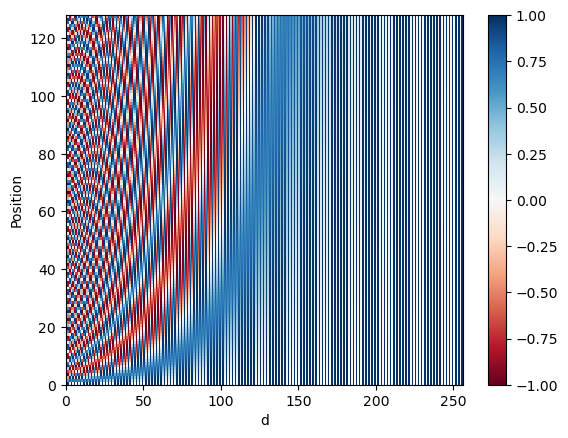

In [77]:
pos_encoding = positional_encoding(128, 256)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('d')
plt.xlim((0, 256))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### LAB: Assignment

In [78]:
import transfomer_soubory.utils_attention as utils_att

tf.keras.utils.set_random_seed(10)

In [79]:
data_dir = "transfomer_soubory/corpus"

train_data, test_data = utils_att.get_train_test_data(data_dir)

# Take one example from the dataset and print it
example_summary, example_dialogue = train_data.iloc[10]
print(f"Dialogue:\n{example_dialogue}")
print(f"\nSummary:\n{example_summary}")

Dialogue:
Lucas: Hey! How was your day?
Demi: Hey there! 
Demi: It was pretty fine, actually, thank you!
Demi: I just got promoted! :D
Lucas: Whoa! Great news!
Lucas: Congratulations!
Lucas: Such a success has to be celebrated.
Demi: I agree! :D
Demi: Tonight at Death & Co.?
Lucas: Sure!
Lucas: See you there at 10pm?
Demi: Yeah! See you there! :D

Summary:
Demi got promoted. She will celebrate that with Lucas at Death & Co at 10 pm.


2 - Preprocess the data

First you will do some preprocessing of the data and split it into inputs and outputs. Here you also remove some of the characters that are specific to this dataset and add the `[EOS]` (end of sentence) token to the end, like it was discussed in the lecture videos. You will also add a `[SOS]` (start of sentence) token to the beginning of the sentences.

In [80]:
document, summary = utils_att.preprocess(train_data)
document_test, summary_test = utils_att.preprocess(test_data)

In [81]:
# The [ and ] from default tokens cannot be removed, because they mark the SOS and EOS token.
filters = '!"#$%&()*+,-./:;<=>?@\\^_`{|}~\t\n'
oov_token = '[UNK]'

tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token, lower=False)

documents_and_summary = pd.concat([document, summary], ignore_index=True)

tokenizer.fit_on_texts(documents_and_summary)

inputs = tokenizer.texts_to_sequences(document)
targets = tokenizer.texts_to_sequences(summary)

vocab_size = len(tokenizer.word_index) + 1

print(f'Size of vocabulary: {vocab_size}')

Size of vocabulary: 34250


In [82]:
# Limit the size of the input and output data for being able to run it in this environment.
encoder_maxlen = 150
decoder_maxlen = 50

# Pad the sequences.
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=encoder_maxlen, padding='post', truncating='post')
targets = tf.keras.preprocessing.sequence.pad_sequences(targets, maxlen=decoder_maxlen, padding='post', truncating='post')

inputs = tf.cast(inputs, dtype=tf.int32)
targets = tf.cast(targets, dtype=tf.int32)

# Create the final training dataset.
BUFFER_SIZE = 10000
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [83]:
def positional_encoding(positions, d_model):
    """
    Precomputes a matrix with all the positional encodings 
    
    Arguments:
        positions (int): Maximum number of positions to be encoded 
        d_model (int): Encoding size 
    
    Returns:
        pos_encoding (tf.Tensor): A matrix of shape (1, position, d_model) with the positional encodings
    """
    
    position = np.arange(positions)[:, np.newaxis]
    k = np.arange(d_model)[np.newaxis, :]
    i = k // 2
    
    # initialize a matrix angle_rads of all the angles 
    angle_rates = 1 / np.power(10000, (2 * i) / np.float32(d_model))
    angle_rads = position * angle_rates
  
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

In [84]:
def create_padding_mask(decoder_token_ids):
    """
    Creates a matrix mask for the padding cells
    
    Arguments:
        decoder_token_ids (matrix like): matrix of size (n, m)
    
    Returns:
        mask (tf.Tensor): binary tensor of size (n, 1, m)
    """    
    seq = 1 - tf.cast(tf.math.equal(decoder_token_ids, 0), tf.float32)
  
    # add extra dimensions to add the padding to the attention logits. 
    # this will allow for broadcasting later when comparing sequences
    return seq[:, tf.newaxis, :] 


def create_look_ahead_mask(sequence_length):
    """
    Returns a lower triangular matrix filled with ones
    
    Arguments:
        sequence_length (int): matrix size
    
    Returns:
        mask (tf.Tensor): binary tensor of size (sequence_length, sequence_length)
    """
    mask = tf.linalg.band_part(tf.ones((1, sequence_length, sequence_length)), -1, 0)
    return mask 

5 - Self-Attention

As the authors of the Transformers paper state, "Attention is All You Need". 

<img src="transfomer_soubory/assign_self-attention.png" alt="Encoder" width="600"/>
<caption><center><font color='purple'><b>Figure 1: Self-Attention calculation visualization</font></center></caption>
    
The use of self-attention paired with traditional convolutional networks allows for parallelization which speeds up training. You will implement **scaled dot product attention** which takes in a query, key, value, and a mask as inputs to return rich, attention-based vector representations of the words in your sequence. This type of self-attention can be mathematically expressed as:
$$
\text { Attention }(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}+{M}\right) V\tag{4}\
$$

* $Q$ is the matrix of queries 
* $K$ is the matrix of keys
* $V$ is the matrix of values
* $M$ is the optional mask you choose to apply 
* ${d_k}$ is the dimension of the keys, which is used to scale everything down so the softmax doesn't explode

<a name='ex-1'></a>
Exercise 1 - scaled_dot_product_attention 

Implement the function `scaled_dot_product_attention()` to create attention-based representations.

**Reminder**: The boolean mask parameter can be passed in as `none` or as either padding or look-ahead. 
    
* Multiply (1. - mask) by -1e9 before adding it to the scaled attention logits. 

**Additional Hints**
* You may find [tf.matmul](https://www.tensorflow.org/api_docs/python/tf/linalg/matmul) useful for matrix multiplication (check how you can use the parameter transpose_b).
* You can use [tf.keras.activations.softmax](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax) for softmax.

In [85]:
def scaled_dot_product_attention(q, k, v, mask):
    """
    Calculate the attention weights.
      q, k, v must have matching leading dimensions.
      k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
      The mask has different shapes depending on its type(padding or look ahead) 
      but it must be broadcastable for addition.

    Arguments:
        q (tf.Tensor): query of shape (..., seq_len_q, depth)
        k (tf.Tensor): key of shape (..., seq_len_k, depth)
        v (tf.Tensor): value of shape (..., seq_len_v, depth_v)
        mask (tf.Tensor): mask with shape broadcastable 
              to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
        output -- attention_weights
    """

    # Multiply q and k transposed.
    matmul_qk = tf.matmul(q, k, transpose_b = True)

    # scale matmul_qk with the square root of dk
    dk = tf.cast(np.sqrt(k.shape[1]), tf.float32)
    scaled_attention_logits = matmul_qk / dk

    # add the mask to the scaled tensor.
    if mask is not None:  # Don't replace this None
        scaled_attention_logits += (1. - mask) * (-1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores add up to 1.
    attention_weights = tf.keras.activations.softmax(scaled_attention_logits)

    # Multiply the attention weights by v
    output = tf.matmul(attention_weights, v)

    return output, attention_weights

In [86]:
# Test your function!
q = np.array([[1, 1, 0, 1], [0, 1, 1, 1], [1, 0, 1, 1]]).astype(np.float32)
k = np.array([[1, 1, 0, 1], [1, 0, 1, 1 ], [1, 1, 1, 0], [0, 0, 0, 1], [0, 1, 0, 1]]).astype(np.float32)
v = np.array([[0, 0], [1, 0], [1, 0], [1, 1], [1, 1]]).astype(np.float32)
mask = np.array([[[0, 1, 0, 1, 1], [1, 0, 0, 1, 1], [1, 1, 0, 1, 1]]])

ou, atw = scaled_dot_product_attention(q, k, v, mask)
ou = np.around(ou, decimals=2)
atw = np.around(atw, decimals=2)

print(f"Output:\n {ou}")
print(f"\nAttention weigths:\n {atw}")

Output:
 [[[1.   0.62]
  [0.62 0.62]
  [0.74 0.31]]]

Attention weigths:
 [[[0.   0.38 0.   0.23 0.38]
  [0.38 0.   0.   0.23 0.38]
  [0.26 0.43 0.   0.16 0.16]]]


6 - Encoder

The Transformer Encoder layer pairs self-attention and convolutional neural network style of processing to improve the speed of training and passes K and V matrices to the Decoder, which you'll build later in the assignment. In this section of the assignment, you will implement the Encoder by pairing multi-head attention and a feed forward neural network (Figure 2a). 
<img src="transfomer_soubory/assign_encoder_layer.png" alt="Encoder" width="400"/>
<caption><center><font color='purple'><b>Figure 2a: Transformer encoder layer</font></center></caption>

* `MultiHeadAttention` you can think of as computing the self-attention several times to detect different features. 
* Feed forward neural network contains two Dense layers which we'll implement as the function `FullyConnected`

Your input sentence first passes through a *multi-head attention layer*, where the encoder looks at other words in the input sentence as it encodes a specific word. The outputs of the multi-head attention layer are then fed to a *feed forward neural network*. The exact same feed forward network is independently applied to each position.
   
* For the `MultiHeadAttention` layer, you will use the [MultiHeadAttention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention) implemented in Keras. If you're curious about how to split the query matrix Q, key matrix K, and value matrix V into different heads, you can look through the implementation. 
* You will also use the [Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) with two dense layers to built the feed forward neural network layers.

In [87]:
def FullyConnected(embedding_dim, fully_connected_dim):
    """
    Returns a sequential model consisting of two dense layers. The first dense layer has
    fully_connected_dim neurons and is activated by relu. The second dense layer has
    embedding_dim and no activation.

    Arguments:
        embedding_dim (int): output dimension
        fully_connected_dim (int): dimension of the hidden layer

    Returns:
        _ (tf.keras.Model): sequential model
    """
    return tf.keras.Sequential([
        tf.keras.layers.Dense(fully_connected_dim, activation='relu'),  # (batch_size, seq_len, d_model)
        tf.keras.layers.Dense(embedding_dim)  # (batch_size, seq_len, d_model)
    ])

6.1 Encoder Layer

Now you can pair multi-head attention and feed forward neural network together in an encoder layer! You will also use residual connections and layer normalization to help speed up training (Figure 2a).

The encoder block (Figure 2) is is already implemented for you. Take a very close look at its implementation, as you will later have to create the decoder yourself, and a lot of the code is very similar. The encoder block performs the following steps: 
1. It takes the Q, V, K matrices and a boolean mask to a multi-head attention layer. Remember that to compute *self*-attention Q, V and K are the same. You will also perform Dropout in this multi-head attention layer during training. 
2. There is a skip connection to add your original input `x` and the output of the multi-head attention layer. 
3. After adding the skip connection, the output passes through the first normalization layer.
4. Finally, steps 1-3 are repeated but with the feed forward neural network with a dropout layer instead of the multi-head attention layer. 

<details>
  <summary><font size="2" color="darkgreen"><b>Additional Information (Click to expand)</b></font></summary>
    
* The `__init__` method creates all the layers that will be accesed by the the `call` method. Wherever you want to use a layer defined inside  the `__init__`  method you will have to use the syntax `self.[insert layer name]`. 
* You will find the documentation of [MultiHeadAttention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention) helpful. *Note that if query, key and value are the same, then this function performs self-attention.*
* The call arguments for `self.mha` are (Where B is for batch_size, T is for target sequence shapes, and S is output_shape):
 - `query`: Query Tensor of shape (B, T, dim).
 - `value`: Value Tensor of shape (B, S, dim).
 - `key`: Optional key Tensor of shape (B, S, dim). If not given, will use the same value for both key and value, which is the most common case.
 - `attention_mask`: a boolean mask of shape (B, T, S), that prevents attention to certain positions. The boolean mask specifies which query elements can attend to which key elements, 1 indicates attention and 0 indicates no attention. Broadcasting can happen for the missing batch dimensions and the head dimension.
 - `return_attention_scores`: A boolean to indicate whether the output should be attention output if True, or (attention_output, attention_scores) if False. Defaults to False.
 - `training`: Python boolean indicating whether the layer should behave in training mode (adding dropout) or in inference mode (no dropout). Defaults to either using the training mode of the parent layer/model, or False (inference) if there is no parent layer. Take a look at [tf.keras.layers.Dropout](https://www.tensorflow.org/versions/r2.4/api_docs/python/tf/keras/layers/Dropout) for more details (Additional reading in [Keras FAQ](https://keras.io/getting_started/faq/#whats-the-difference-between-the-training-argument-in-call-and-the-trainable-attribute))

In [88]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    The encoder layer is composed by a multi-head self-attention mechanism,
    followed by a simple, positionwise fully connected feed-forward network. 
    This architecture includes a residual connection around each of the two 
    sub-layers, followed by layer normalization.
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim,
                 dropout_rate=0.1, layernorm_eps=1e-6):
        
        super(EncoderLayer, self).__init__()

        self.mha = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim,
            dropout=dropout_rate
        )

        self.ffn = FullyConnected(
            embedding_dim=embedding_dim,
            fully_connected_dim=fully_connected_dim
        )

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)

        self.dropout_ffn = tf.keras.layers.Dropout(dropout_rate)
    
    def call(self, x, training, mask):
        """
        Forward pass for the Encoder Layer
        
        Arguments:
            x (tf.Tensor): Tensor of shape (batch_size, input_seq_len, fully_connected_dim)
            training (bool): Boolean, set to true to activate
                        the training mode for dropout layers
            mask (tf.Tensor): Boolean mask to ensure that the padding is not 
                    treated as part of the input
        Returns:
            encoder_layer_out (tf.Tensor): Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """
        # calculate self-attention using mha(~1 line).
        # Dropout is added by Keras automatically if the dropout parameter is non-zero during training
        self_mha_output = self.mha(x, x, x, mask)  # Self attention (batch_size, input_seq_len, fully_connected_dim)
        
        # skip connection
        # apply layer normalization on sum of the input and the attention output to get the  
        # output of the multi-head attention layer
        skip_x_attention = self.layernorm1(x + self_mha_output)  # (batch_size, input_seq_len, fully_connected_dim)

        # pass the output of the multi-head attention layer through a ffn
        ffn_output = self.ffn(skip_x_attention)  # (batch_size, input_seq_len, fully_connected_dim)
        
        # apply dropout layer to ffn output during training
        # use `training=training`
        ffn_output = self.dropout_ffn(ffn_output, training=training)
        
        # apply layer normalization on sum of the output from multi-head attention (skip connection) and ffn output
        # to get the output of the encoder layer
        encoder_layer_out = self.layernorm2(skip_x_attention + ffn_output)  # (batch_size, input_seq_len, embedding_dim)
        
        return encoder_layer_out
    

6.2 - Full Encoder

Now you're ready to build the full Transformer Encoder (Figure 2b), where you will embed your input and add the positional encodings you calculated. You will then feed your encoded embeddings to a stack of Encoder layers. 

<img src="transfomer_soubory/assign_encoder.png" alt="Encoder" width="330"/>
<caption><center><font color='purple'><b>Figure 2b: Transformer Encoder</font></center></caption>

The Encoder class is implemented for you. It performs the following steps: 
1. Pass the input through the Embedding layer.
2. Scale the embedding by multiplying it by the square root of the embedding dimension. 
3. Add the position encoding: self.pos_encoding `[:, :seq_len, :]` to the embedding.
4. Pass the encoded embedding through a dropout layer
5. Pass the output of the dropout layer through the stack of encoding layers using a for loop.

In [126]:
class Encoder(tf.keras.layers.Layer):
    """
    The entire Encoder starts by passing the input to an embedding layer 
    and using positional encoding to then pass the output through a stack of
    encoder Layers
        
    """  
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size,
               maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Encoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.embedding_dim)


        self.enc_layers = [EncoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps) 
                           for _ in range(self.num_layers)]

        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        
    def call(self, x, training, mask):
        """
        Forward pass for the Encoder
        
        Arguments:
            x (tf.Tensor): Tensor of shape (batch_size, seq_len, embedding_dim)
            training (bool): Boolean, set to true to activate
                        the training mode for dropout layers
            mask (tf.Tensor): Boolean mask to ensure that the padding is not 
                    treated as part of the input

        Returns:
            x (tf.Tensor): Tensor of shape (batch_size, seq_len, embedding_dim)
        """
        seq_len = tf.shape(x)[1]
        
        # Pass input through the Embedding layer
        x = self.embedding(x)  # (batch_size, input_seq_len, embedding_dim)
        # Scale embedding by multiplying it by the square root of the embedding dimension
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))
        # Add the position encoding to embedding
        x += self.pos_encoding[:, :seq_len, :]
        # Pass the encoded embedding through a dropout layer
        # use `training=training`
        x = self.dropout(x, training=training)
        # Pass the output through the stack of encoding layers 
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training=training, mask=mask)

        return x  # (batch_size, input_seq_len, embedding_dim)

<a name='7'></a>
7 - Decoder

Now it is time to implement the decoder. You have seen it in the videos and you can use some help by looking at the encoder implementation above. The Decoder layer takes the K and V matrices generated by the Encoder and computes the second multi-head attention layer with the Q matrix from the output (Figure 3a).

<img src="transfomer_soubory/assing_decoder_layer.png" alt="Decoder" width="250"/>
<caption><center><font color='purple'><b>Figure 3a: Transformer Decoder layer</font></center></caption>

<a name='7-1'></a>    
7.1 - Decoder Layer
Again, you'll pair multi-head attention with a feed forward neural network, but this time you'll implement two multi-head attention layers. You will also use residual connections and layer normalization to help speed up training (Figure 3a).

<a name='ex-2'></a>    
Exercise 2 - DecoderLayer
    
Implement `DecoderLayer()` using the `call()` method
    
1. Block 1 is a multi-head attention layer with a residual connection, and look-ahead mask. Like in the `EncoderLayer`, Dropout is defined within the multi-head attention layer.
2. Block 2 will take into account the output of the Encoder, so the multi-head attention layer will receive K and V from the encoder, and Q from the Block 1. You will then apply a normalization layer and a residual connection, just like you did before with the `EncoderLayer`.
3. Finally, Block 3 is a feed forward neural network with dropout and normalization layers and a residual connection.
    
**Additional Hints:**
* The first two blocks are fairly similar to the EncoderLayer except you will return `attention_scores` when computing self-attention

In [2]:
class DecoderLayer(tf.keras.layers.Layer):
    """
    The decoder layer is composed by two multi-head attention blocks,
    one that takes the new input and uses self-attention, and the other
    one that combines it with the output of the encoder, followed by a
    fully connected block.
    """

    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1, layernorm_eps=1e-6):
        super(DecoderLayer, self).__init__()

        self.mha1 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim,
            dropout=dropout_rate
        )

        self.mha2 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim,
            dropout=dropout_rate
        )

        self.ffn = FullyConnected(
            embedding_dim=embedding_dim,
            fully_connected_dim=fully_connected_dim
        )

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)

        self.dropout_ffn = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        """
        Forward pass for the Decoder Layer

        Arguments:
            x (tf.Tensor): Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
            enc_output (tf.Tensor): Tensor of shape(batch_size, input_seq_len, fully_connected_dim)
            training (bool): Boolean, set to true to activate
                        the training mode for dropout layers
            look_ahead_mask (tf.Tensor): Boolean mask for the target_input
            padding_mask (tf.Tensor): Boolean mask for the second multihead attention layer
        Returns:
            out3 (tf.Tensor): Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
            attn_weights_block1 (tf.Tensor): Tensor of shape (batch_size, num_heads, target_seq_len, target_seq_len)
            attn_weights_block2 (tf.Tensor): Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        """

        # enc_output.shape == (batch_size, input_seq_len, fully_connected_dim)

        # BLOCK 1
        # calculate self-attention and return attention scores as attn_weights_block1.
        # Dropout will be applied during training (~1 line).
        mult_attn_out1, attn_weights_block1 = self.mha1(x, x, x, attention_mask=look_ahead_mask, return_attention_scores=True)

        # apply layer normalization (layernorm1) to the sum of the attention output and the input (~1 line)
        Q1 = self.layernorm1(x + mult_attn_out1)

        # BLOCK 2
        # calculate self-attention using the Q from the first block and K and V from the encoder output.
        # Dropout will be applied during training
        # Return attention scores as attn_weights_block2 (~1 line)
        mult_attn_out2, attn_weights_block2 = self.mha2(Q1, enc_output, enc_output, attention_mask=padding_mask,
                                                        return_attention_scores=True)

        # apply layer normalization (layernorm2) to the sum of the attention output and the output of the first block (~1 line)
        mult_attn_out2 = self.layernorm2(Q1 + mult_attn_out2)

        # BLOCK 3
        # pass the output of the second block through a ffn
        ffn_output = self.ffn(mult_attn_out2)

        # apply a dropout layer to the ffn output
        # use `training=training`
        ffn_output = self.dropout_ffn(ffn_output, training=training)

        # apply layer normalization (layernorm3) to the sum of the ffn output and the output of the second block
        out3 = self.layernorm3(ffn_output + mult_attn_out2)

        return out3, attn_weights_block1, attn_weights_block2

NameError: name 'tf' is not defined

In [ ]:
# Test your function!
key_dim = 12
n_heads = 16

decoderLayer_test = DecoderLayer(embedding_dim=key_dim, num_heads=n_heads, fully_connected_dim=32)

q = np.ones((1, 15, key_dim))
encoder_test_output = tf.convert_to_tensor(np.random.rand(1, 7, 8))
look_ahead_mask = create_look_ahead_mask(q.shape[1])
out, attn_w_b1, attn_w_b2 = decoderLayer_test(
                                              x=q, 
                                              enc_output=encoder_test_output, training=False,
                                              look_ahead_mask=look_ahead_mask, padding_mask=None)

print(f"Using embedding_dim={key_dim} and num_heads={n_heads}:\n")
print(f"q has shape:{q.shape}")
print(f"Output of encoder has shape:{encoder_test_output.shape}\n")

print(f"Output of decoder layer has shape:{out.shape}")
print(f"Att Weights Block 1 has shape:{attn_w_b1.shape}")
print(f"Att Weights Block 2 has shape:{attn_w_b2.shape}")

Using embedding_dim=12 and num_heads=16:

q has shape:(1, 15, 12)
Output of encoder has shape:(1, 7, 8)

Output of decoder layer has shape:(1, 15, 12)
Att Weights Block 1 has shape:(1, 16, 15, 15)
Att Weights Block 2 has shape:(1, 16, 15, 7)


7.2 - Full Decoder
You're almost there! Time to use your Decoder layer to build a full Transformer Decoder (Figure 3b). You will embed your output and add positional encodings. You will then feed your encoded embeddings to a stack of Decoder layers. 


<img src="transfomer_soubory/assign_decoder.png" alt="Decoder" width="300"/>
<caption><center><font color='purple'><b>Figure 3b: Transformer Decoder</font></center></caption>

<a name='ex-3'></a>     
Exercise 3 - Decoder

Implement `Decoder()` using the `call()` method to embed your output, add positional encoding, and implement multiple decoder layers.
 
In this exercise, you will initialize your Decoder with an Embedding layer, positional encoding, and multiple DecoderLayers. Your `call()` method will perform the following steps: 
1. Pass your generated output through the Embedding layer.
2. Scale your embedding by multiplying it by the square root of your embedding dimension. Remember to cast the embedding dimension to data type `tf.float32` before computing the square root.
3. Add the position encoding: self.pos_encoding `[:, :seq_len, :]` to your embedding.
4. Pass the encoded embedding through a dropout layer, remembering to use the `training` parameter to set the model training mode. 
5. Pass the output of the dropout layer through the stack of Decoding layers using a for loop.

In [ ]:
class Decoder(tf.keras.layers.Layer):
    """
    The entire Encoder starts by passing the target input to an embedding layer
    and using positional encoding to then pass the output through a stack of
    decoder Layers

    """

    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, target_vocab_size,
                 maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Decoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.embedding_dim)

        self.dec_layers = [DecoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps)
                           for _ in range(self.num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, enc_output, training,
             look_ahead_mask, padding_mask):
        """
        Forward  pass for the Decoder

        Arguments:
            x (tf.Tensor): Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
            enc_output (tf.Tensor):  Tensor of shape(batch_size, input_seq_len, fully_connected_dim)
            training (bool): Boolean, set to true to activate
                        the training mode for dropout layers
            look_ahead_mask (tf.Tensor): Boolean mask for the target_input
            padding_mask (tf.Tensor): Boolean mask for the second multihead attention layer
        Returns:
            x (tf.Tensor): Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
            attention_weights (dict[str: tf.Tensor]): Dictionary of tensors containing all the attention weights
                                each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        """

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        # create word embeddings
        x = self.embedding(x)

        # scale embeddings by multiplying by the square root of their dimension
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))

        # add positional encodings to word embedding
        x += self.pos_encoding[:, :seq_len, :]

        # apply a dropout layer to x
        # use `training=training`
        x = self.dropout(x, training=training)

        # use a for loop to pass x through a stack of decoder layers and update attention_weights (~4 lines total)
        for i in range(self.num_layers):
            # pass x and the encoder output through a stack of decoder layers and save the attention weights
            # of block 1 and 2 (~1 line)
            x, block1, block2 = self.dec_layers[i](x, enc_output, training=training, look_ahead_mask=look_ahead_mask,
                                                   padding_mask=padding_mask)

            # update attention_weights dictionary with the attention weights of block 1 and block 2
            attention_weights[f'decoder_layer{i + 1}_block1_self_att'] = block1
            attention_weights[f'decoder_layer{i + 1}_block2_decenc_att'] = block2

        # x.shape == (batch_size, target_seq_len, fully_connected_dim)
        return x, attention_weights

In [ ]:
# Test your function!
n_layers = 5
emb_d = 13
n_heads = 17
fully_connected_dim = 16
target_vocab_size = 300
maximum_position_encoding = 6

x = np.array([[3, 2, 1, 1], [2, 1, 1, 0], [2, 1, 1, 0]])

encoder_test_output = tf.convert_to_tensor(np.random.rand(3, 7, 9))

look_ahead_mask = create_look_ahead_mask(x.shape[1])

decoder_test = Decoder(n_layers, emb_d, n_heads, fully_connected_dim, target_vocab_size, maximum_position_encoding)

# Correct the call by passing 'training' as a keyword argument
outd, att_weights = decoder_test(x, encoder_test_output, training=False, look_ahead_mask=look_ahead_mask, padding_mask=None)

print(f"Using num_layers={n_layers}, embedding_dim={emb_d} and num_heads={n_heads}:\n")
print(f"x has shape:{x.shape}")
print(f"Output of encoder has shape:{encoder_test_output.shape}\n")

print(f"Output of decoder has shape:{outd.shape}\n")
print("Attention weights:")
for name, tensor in att_weights.items():
    print(f"{name} has shape:{tensor.shape}")

Using num_layers=5, embedding_dim=13 and num_heads=17:

x has shape:(3, 4)
Output of encoder has shape:(3, 7, 9)

Output of decoder has shape:(3, 4, 13)

Attention weights:
decoder_layer1_block1_self_att has shape:(3, 17, 4, 4)
decoder_layer1_block2_decenc_att has shape:(3, 17, 4, 7)
decoder_layer2_block1_self_att has shape:(3, 17, 4, 4)
decoder_layer2_block2_decenc_att has shape:(3, 17, 4, 7)
decoder_layer3_block1_self_att has shape:(3, 17, 4, 4)
decoder_layer3_block2_decenc_att has shape:(3, 17, 4, 7)
decoder_layer4_block1_self_att has shape:(3, 17, 4, 4)
decoder_layer4_block2_decenc_att has shape:(3, 17, 4, 7)
decoder_layer5_block1_self_att has shape:(3, 17, 4, 4)
decoder_layer5_block2_decenc_att has shape:(3, 17, 4, 7)


8 - Transformer

Phew! This has been quite the assignment! Congratulations! You've done all the hard work, now it's time to put it all together.  

<img src="transfomer_soubory/assign_transformer.png" alt="Transformer" width="550"/>
<caption><center><font color='purple'><b>Figure 4: Transformer</font></center></caption>
    
The flow of data through the Transformer Architecture is as follows:
* First your input passes through an Encoder, which is just repeated Encoder layers that you implemented:
    - embedding and positional encoding of your input
    - multi-head attention on your input
    - feed forward neural network to help detect features
* Then the predicted output passes through a Decoder, consisting of the decoder layers that you implemented:
    - embedding and positional encoding of the output
    - multi-head attention on your generated output
    - multi-head attention with the Q from the first multi-head attention layer and the K and V from the Encoder
    - a feed forward neural network to help detect features
* Finally, after the Nth Decoder layer, one dense layer and a softmax are applied to generate prediction for the next output in your sequence.

<a name='ex-4'></a> 
Exercise 4 - Transformer

Implement `Transformer()` using the `call()` method
1. Pass the input through the Encoder with the appropiate mask.
2. Pass the encoder output and the target through the Decoder with the appropiate mask.
3. Apply a linear transformation and a softmax to get a prediction.

In [ ]:
# GRADED FUNCTION: Transformer
class Transformer(tf.keras.Model):
    """
    Complete transformer with an Encoder and a Decoder
    """
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, 
               target_vocab_size, max_positional_encoding_input,
               max_positional_encoding_target, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers=num_layers,
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               input_vocab_size=input_vocab_size,
                               maximum_position_encoding=max_positional_encoding_input,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.decoder = Decoder(num_layers=num_layers, 
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               target_vocab_size=target_vocab_size, 
                               maximum_position_encoding=max_positional_encoding_target,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size, activation='softmax')
    
    def call(self, input_sentence, output_sentence, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        """
        Forward pass for the entire Transformer
        Arguments:
            input_sentence (tf.Tensor): Tensor of shape (batch_size, input_seq_len, fully_connected_dim)
                              An array of the indexes of the words in the input sentence
            output_sentence (tf.Tensor): Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
                              An array of the indexes of the words in the output sentence
            training (bool): Boolean, set to true to activate
                        the training mode for dropout layers
            enc_padding_mask (tf.Tensor): Boolean mask to ensure that the padding is not 
                    treated as part of the input
            look_ahead_mask (tf.Tensor): Boolean mask for the target_input
            dec_padding_mask (tf.Tensor): Boolean mask for the second multihead attention layer
        Returns:
            final_output (tf.Tensor): The final output of the model
            attention_weights (dict[str: tf.Tensor]): Dictionary of tensors containing all the attention weights for the decoder
                                each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        
        """
        ### START CODE HERE ###
        # call self.encoder with the appropriate arguments to get the encoder output
        enc_output = self.encoder(x=input_sentence, training=training, mask=enc_padding_mask)
        
        # call self.decoder with the appropriate arguments to get the decoder output
        # dec_output.shape == (batch_size, tar_seq_len, fully_connected_dim)
        dec_output, attention_weights = self.decoder(output_sentence, enc_output, training=training, 
                                                     look_ahead_mask=look_ahead_mask, padding_mask=dec_padding_mask)
        
        # pass decoder output through a linear layer and softmax (~1 line)
        final_output = self.final_layer(dec_output)
        ### END CODE HERE ###

        return final_output, attention_weights

In [ ]:
# Test your function!
n_layers = 3
emb_d = 13
n_heads = 17
fully_connected_dim = 8
input_vocab_size = 300
target_vocab_size = 350
max_positional_encoding_input = 12
max_positional_encoding_target = 12

transformer = Transformer(
    num_layers = n_layers, 
    embedding_dim = emb_d, 
    num_heads = n_heads, 
    fully_connected_dim = fully_connected_dim, 
    input_vocab_size = input_vocab_size, 
    target_vocab_size = target_vocab_size, 
    max_positional_encoding_input = max_positional_encoding_input,
    max_positional_encoding_target = max_positional_encoding_target)

# 0 is the padding value
sentence_a = np.array([[2, 3, 1, 3, 0, 0, 0]])
sentence_b = np.array([[1, 3, 4, 0, 0, 0, 0]])

enc_padding_mask = create_padding_mask(sentence_a)
dec_padding_mask = create_padding_mask(sentence_a)

look_ahead_mask = create_look_ahead_mask(sentence_a.shape[1])

test_summary, att_weights = transformer(
    input_sentence = sentence_a,
    output_sentence = sentence_b,
    training = False,
    enc_padding_mask = enc_padding_mask,
    look_ahead_mask = look_ahead_mask,
    dec_padding_mask = dec_padding_mask
)

print(f"Using num_layers={n_layers}, target_vocab_size={target_vocab_size} and num_heads={n_heads}:\n")
print(f"sentence_a has shape:{sentence_a.shape}")
print(f"sentence_b has shape:{sentence_b.shape}")

print(f"\nOutput of transformer (summary) has shape:{test_summary.shape}\n")
print("Attention weights:")
for name, tensor in att_weights.items():
    print(f"{name} has shape:{tensor.shape}")

Using num_layers=3, target_vocab_size=350 and num_heads=17:

sentence_a has shape:(1, 7)
sentence_b has shape:(1, 7)

Output of transformer (summary) has shape:(1, 7, 350)

Attention weights:
decoder_layer1_block1_self_att has shape:(1, 17, 7, 7)
decoder_layer1_block2_decenc_att has shape:(1, 17, 7, 7)
decoder_layer2_block1_self_att has shape:(1, 17, 7, 7)
decoder_layer2_block2_decenc_att has shape:(1, 17, 7, 7)
decoder_layer3_block1_self_att has shape:(1, 17, 7, 7)
decoder_layer3_block2_decenc_att has shape:(1, 17, 7, 7)


In [ ]:
# Define the model parameters
num_layers = 2
embedding_dim = 128
fully_connected_dim = 128
num_heads = 2
positional_encoding_length = 256

# Initialize the model
transformer = Transformer(
    num_layers, 
    embedding_dim, 
    num_heads, 
    fully_connected_dim,
    vocab_size, 
    vocab_size, 
    positional_encoding_length, 
    positional_encoding_length,
)

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = tf.cast(d_model, dtype=tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(embedding_dim)

optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

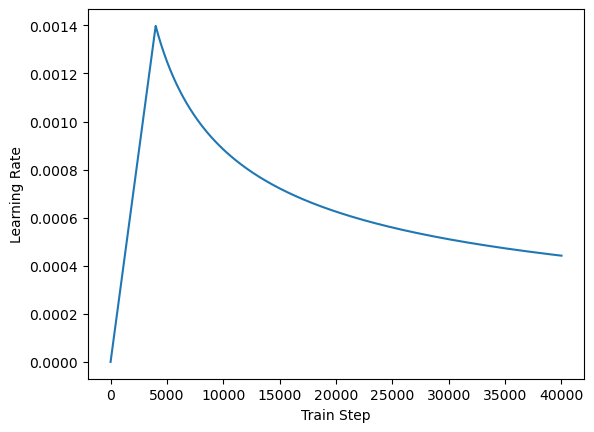

In [ ]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')

def masked_loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


train_loss = tf.keras.metrics.Mean(name='train_loss')

# Here you will store the losses, so you can later plot them
losses = []

Now you can define your custom training function. If you are not very advanced with tensorflow, you can understand this function as an alternative to using `model.compile()` and `model.fit()`, but with added extra flexibility.

In [ ]:
@tf.function
def train_step(model, inp, tar):
    """
    One training step for the transformer
    Arguments:
        inp (tf.Tensor): Input data to summarize
        tar (tf.Tensor): Target (summary)
    Returns:
        None
    """
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    # Create masks
    enc_padding_mask = create_padding_mask(inp)
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar_inp)[1])
    dec_padding_mask = create_padding_mask(inp) # Notice that both encoder and decoder padding masks are equal

    with tf.GradientTape() as tape:
        predictions, _ = model(
            input_sentence=inp,
            output_sentence=tar_inp, 
            training=True, 
            enc_padding_mask=enc_padding_mask, 
            look_ahead_mask=look_ahead_mask, 
            dec_padding_mask=dec_padding_mask
        )
        loss = masked_loss(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)

11 - Summarization

The last thing you will implement is inference. With this, you will be able to produce actual summaries of the documents. You will use a simple method called greedy decoding, which means you will predict one word at a time and append it to the output. You will start with an `[SOS]` token and repeat the word by word inference until the model returns you the `[EOS]` token or until you reach the maximum length of the sentence (you need to add this limit, otherwise a poorly trained model could give you infinite sentences without ever producing the `[EOS]` token.


Exercise 5 - next_word
Write a helper function that predicts the next word, so you can use it to write the whole sentences. Hint: this is very similar to what happens in the train_step, but you have to set the training of the model to False.

In [ ]:
def next_word(model, encoder_input, output):
    """
    Helper function for summarization that uses the model to predict just the next word.
    Arguments:
        encoder_input (tf.Tensor): Input data to summarize
        output (tf.Tensor): (incomplete) target (summary)
    Returns:
        predicted_id (tf.Tensor): The id of the predicted word
    """
    # Create a padding mask for the input (encoder)
    enc_padding_mask = create_padding_mask(encoder_input)
    # Create a look-ahead mask for the output
    look_ahead_mask = create_look_ahead_mask(tf.shape(output)[1])
    # Create a padding mask for the input (decoder)
    dec_padding_mask = create_padding_mask(encoder_input)

    # Run the prediction of the next word with the transformer model
    predictions, attention_weights = model(
            input_sentence=encoder_input,
            output_sentence=output, 
            training=False, 
            enc_padding_mask=enc_padding_mask, 
            look_ahead_mask=look_ahead_mask, 
            dec_padding_mask=dec_padding_mask
    )

    predictions = predictions[: ,-1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    return predicted_id

In [ ]:
# Take a random sentence as an input
input_document = tokenizer.texts_to_sequences(["a random sentence"])
input_document = tf.keras.preprocessing.sequence.pad_sequences(input_document, maxlen=encoder_maxlen, padding='post', truncating='post')
encoder_input = tf.expand_dims(input_document[0], 0)

# Take the start of sentence token as the only token in the output to predict the next word
output = tf.expand_dims([tokenizer.word_index["[SOS]"]], 0)

# predict the next word with your function
predicted_token = next_word(transformer, encoder_input, output)
print(f"Predicted token: {predicted_token}")

predicted_word = tokenizer.sequences_to_texts(predicted_token.numpy())[0]
print(f"Predicted word: {predicted_word}")

/Users/michaelmateju/miniconda3/envs/basic/lib/python3.9/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Predicted token: [[21906]]
Predicted word: cardiologist


In [ ]:
def summarize(model, input_document):
    """
    A function for summarization using the transformer model
    Arguments:
        input_document (tf.Tensor): Input data to summarize
    Returns:
        _ (str): The summary of the input_document
    """    
    input_document = tokenizer.texts_to_sequences([input_document])
    input_document = tf.keras.preprocessing.sequence.pad_sequences(input_document, maxlen=encoder_maxlen, padding='post', truncating='post')
    encoder_input = tf.expand_dims(input_document[0], 0)
    
    output = tf.expand_dims([tokenizer.word_index["[SOS]"]], 0)
    
    for i in range(decoder_maxlen):
        predicted_id = next_word(model, encoder_input, output)
        output = tf.concat([output, predicted_id], axis=-1)
        
        if predicted_id == tokenizer.word_index["[EOS]"]:
            break

    return tokenizer.sequences_to_texts(output.numpy())[0]  # since there is just one translated document

In [ ]:
training_set_example = 0

# Check a summary of a document from the training set
print('Training set example:')
print(document[training_set_example])
print('\nHuman written summary:')
print(summary[training_set_example])
print('\nModel written summary:')
summarize(transformer, document[training_set_example])

Training set example:
[SOS] amanda: i baked  cookies. do you want some?  jerry: sure!  amanda: i'll bring you tomorrow :-) [EOS]

Human written summary:
[SOS] amanda baked cookies and will bring jerry some tomorrow. [EOS]

Model written summary:


/Users/michaelmateju/miniconda3/envs/basic/lib/python3.9/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


"[SOS] robe sapce 250cc crocheting foxx dean's roydon roydon fortnite autographs bergs sends leandra problem excesses attack josephs shuns bergs bergs ☝ robe spotlight menaces icons dean's britanny prefere chelsea's bundle pushy peter's 110 giant giant barbuda vagabond roydon mobolity buttered want😉 mendy would aggreements peter's freaked romaine yaaaaa hr stuation"

Train the model

In [ ]:
# Take an example from the test set, to monitor it during training
test_example = 0
true_summary = summary_test[test_example]
true_document = document_test[test_example]

# Define the number of epochs
epochs = 2

# Training loop
for epoch in range(epochs):
    
    start = time.time()
    train_loss.reset_state()
    number_of_batches=len(list(enumerate(dataset)))

    for (batch, (inp, tar)) in enumerate(dataset):
        print(f'Epoch {epoch+1}, Batch {batch+1}/{number_of_batches}', end='\r')
        train_step(transformer, inp, tar)
    
    print (f'Epoch {epoch+1}, Loss {train_loss.result():.4f}')
    losses.append(train_loss.result())
    
    print (f'Time taken for one epoch: {time.time() - start} sec')
    print('Example summarization on the test set:')
    print('  True summarization:')
    print(f'    {true_summary}')
    print('  Predicted summarization:')
    print(f'    {summarize(transformer, true_document)}\n')

Epoch 1, Loss 7.885031
Time taken for one epoch: 203.08125686645508 sec
Example summarization on the test set:
  True summarization:
    [SOS] hannah needs betty's number but amanda doesn't have it. she needs to contact larry. [EOS]
  Predicted summarization:


/Users/michaelmateju/miniconda3/envs/basic/lib/python3.9/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


    [SOS] and and [EOS]

Epoch 2, Loss 6.571231
Time taken for one epoch: 183.90123009681702 sec
Example summarization on the test set:
  True summarization:
    [SOS] hannah needs betty's number but amanda doesn't have it. she needs to contact larry. [EOS]
  Predicted summarization:
    [SOS] is going to the new the new new new new new new new new the new new new the new [EOS]



Text(0.5, 0, 'Epoch')

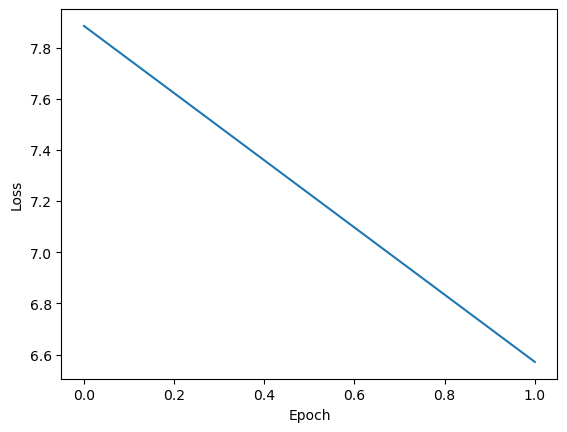

In [ ]:
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')

In [ ]:
training_set_example = 0

# Check a summary of a document from the training set
print('Training set example:')
print(document[training_set_example])
print('\nHuman written summary:')
print(summary[training_set_example])
print('\nModel written summary:')
print(summarize(transformer, document[training_set_example]))

Training set example:
[SOS] amanda: i baked  cookies. do you want some?  jerry: sure!  amanda: i'll bring you tomorrow :-) [EOS]

Human written summary:
[SOS] amanda baked cookies and will bring jerry some tomorrow. [EOS]

Model written summary:


/Users/michaelmateju/miniconda3/envs/basic/lib/python3.9/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


[SOS] is going to the new the new [EOS]


In [ ]:
test_set_example = 3

# Check a summary of a document from the test set
print('Test set example:')
print(document_test[test_set_example])
print('\nHuman written summary:')
print(summary_test[test_set_example])
print('\nModel written summary:')
print(summarize(transformer, document_test[test_set_example]))

Test set example:
[SOS] will: hey babe, what do you want for dinner tonight?  emma:  gah, don't even worry about it tonight  will: what do you mean? everything ok?  emma: not really, but it's ok, don't worry about cooking though, i'm not hungry  will: well what time will you be home?  emma: soon, hopefully  will: you sure? maybe you want me to pick you up?  emma: no no it's alright. i'll be home soon, i'll tell you when i get home.   will: alright, love you.   emma: love you too.  [EOS]

Human written summary:
[SOS] emma will be home soon and she will let will know. [EOS]

Model written summary:


/Users/michaelmateju/miniconda3/envs/basic/lib/python3.9/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


[SOS] is going to the new the new the new new new the new new the new new the new the new [EOS]


If you critically examine the output of the model, you can notice a few things:
 - In the training set the model output is (almost) identical to the real output (already after 20 epochs and even more so with more epochs). This might be because the training set is relatively small and the model is relatively big and has thus learned the sentences in the training set by heart (overfitting).
 - While the performance on the training set looks amazing, it is not so good on the test set. The model overfits, but fails to generalize. Again an easy candidate to blame is the small training set and a comparatively large model, but there might be a variety of other factors.
 - Look at the test set example 3 and its summarization. Would you summarize it the same way as it is written here? Sometimes the data may be ambiguous. And the training of **your model can only be as good as your data**.

Here you only use a small dataset, to show that something can be learned in a reasonable amount of time in a relatively small environment. Generally, large transformers are trained on more than one task and on very large quantities of data to achieve superb performance. You will learn more about this in the rest of this course.

# 3. Question Answering

### Intro

Podivame se na dva modely - BERT, T5

Question-Answering se da zhruba rozdelit na dva typy:
- context-based
- closed book

T5 is learnt on C4 dataset = Colosal Cleaned Crawled Corpus (800 GB)

1. Transfer learning comes in two basic forms:
- feature based -> you learn word embeddings by training one model and then you use those word embeddings in a 
different model on a different task. 
- fune-tuning -> you can use the exact same model and just run it on a different task. Sometimes when fine tuning, 
you can keep the model weights fixed and just add a new layer that you will train. Other times you can slowly 
unfreeze the layers one at a time.  

2. Pretrained data -> Model
- labeled
- unlabled

3. Pretraining task
- language modeling
    - masked words
        -  next sentence

General purpose learning

![Seq2Seq](../pomocne_soubory/feature_vs_funetune.png)

![Seq2Seq](../pomocne_soubory/self_supervise_tasks.png)

### BERT

There are two steps in the BERT framework: pre-training and fine-tuning. During pre-training, the model is trained on unlabeled data over different pre-training tasks.  For fine tuning, the BERT model is first initialized with the pre-trained parameters, and all of the parameters are fine-tuned using labeled data from the downstream tasks. 

During pretraining:

* Choose 15% of the tokens at random: mask them 80% of the time, replace them with a random token 10% of the time, or
 keep as is 10% of the time.   
* There could be multiple masked spans in a sentence
* Next sentence prediction is also used when pre-training.

![Seq2Seq](../pomocne_soubory/bert_input.png)

The input embeddings are the sum of the token embeddings, the segmentation embeddings and the position embeddings.

**The input embeddings**: you have a [CLS] token to indicate the beginning of the sentence and a [SEP] to indicate the 
end 
of the sentence

**The segment embeddings**: allows you to indicate whether it is sentence a or b.

**Positional embeddings**: allows you to indicate the word's position in the sentence.



![Seq2Seq](../pomocne_soubory/bert_input_2.png)

The C token in the image above could be used for classification purposes. The unlabeled sentence A/B pair will depend
 on what you are trying to predict, it could range from question answering to sentiment. (in which case the second 
 sentence could be just empty). The BERT objective is defined as follows:   

![Seq2Seq](../pomocne_soubory/bert_objective.png)

Pekny clanek na mediu: [Understanding BERT](https://medium.com/dissecting-bert/dissecting-bert-part2-335ff2ed9c73)

### Fine-tune BERT

![Seq2Seq](../pomocne_soubory/fine_tune_bert_1.png)

Once you have a pre-trained model, you can fine tune it on different tasks. For example, given a hypothesis, you can
 identify the premise. Given a question, you can find the answer. You can also use it for named entity recognition, 
 paraphrasing sentences, sequence tagging, classification and many more tasks. 

![Seq2Seq](../pomocne_soubory/fine_tune_bert_2.png)

![Seq2Seq](../pomocne_soubory/fine_tune_bert_3.png)

### T5 Transformer

T5 je multitask model, ktery se da pouzit pro nekolik ruznych uloh. Napriklad:
* Text-to-text
* Classification
* Q&A
* Machine Translation
* Summarization
* Sentiment

One of the major techniques that allowed the T5 model to reach state of the art is the concept of masking:

![Seq2Seq](../pomocne_soubory/t5_arch_1.png)

For example, you represent the “for inviting” with <X> and last with <Y> then the model predicts what the X should be
 and what the Y should be. This is exactly what we saw in the BERT loss. You can also mask out a few positions, not 
 just one. The loss is only on the mask for BERT, for T5 it is on the target.   

![Seq2Seq](../pomocne_soubory/t5_arch_2.png)

So we start with the basic encoder-decoder representation.  There you have a fully visible attention in the encoder 
and then causal attention in the decoder.  So light gray lines correspond to causal masking. And dark gray lines 
correspond to the fully visible masking.   

In the middle we have the language model which consists of a single transformer layer stack. And it's being fed the 
concatenation of the inputs and the target. So it uses causal masking throughout as you can see because they're all 
gray lines. And you have X1 going inside, you get X2, X2 goes into the model and you get X3 and so forth.   

To the right, we have prefix language model which corresponds to allowing fully visible masking over the inputs as 
you can see with the dark arrows. And then causal masking in the rest. 

### Multi-task Training Strategy

![Seq2Seq](../pomocne_soubory/t5_train_1.png)

You can see that you only have to add a small prefix to the input and the model as a result will solve the task for 
you. There are many tasks that the t5 model can do for you. 

![Seq2Seq](../pomocne_soubory/t5_train_2.png)

It is possible to formulate most NLP tasks in a “text-to-text” format – that is, a task where the model is fed some 
text for context or conditioning and is then asked to produce some output text. This framework provides a consistent 
training objective both for pre-training and fine-tuning. Specifically, the model is trained with a maximum 
likelihood objective (using “teacher forcing” ) regardless of the task.   

**Training data strategies**

**Examples-proportional mixing**: sample in proportion to the size of each task’s dataset

**Temperature scaled mixing**: adjust the “temperature” of the mixing rates. This temperature parameter allows you to 
weight certain examples more than others. To implement temperature scaling with temperature T, we raise each task’s 
mixing rate rm to the power of 1⁄T and renormalize the rates so that they sum to 1. When T = 1, this approach is 
equivalent to examples-proportional mixing and as T increases the proportions become closer to equal mixing   

**Equal mixing**: In this case, you sample examples from each task with equal probability. Specifically, each example
 in 
each batch is sampled uniformly at random from one of the datasets you train on. 

**Fine tuning example**

![Seq2Seq](../pomocne_soubory/t5_train_3.png)

![Seq2Seq](../pomocne_soubory/t5_train_4.png)

![Seq2Seq](../pomocne_soubory/t5_train_5.png)

### LAB: SentencePiece and BPE

#### Introduction to Tokenization

In order to process text in neural network models it is first required to **encode** text as numbers with ids, since 
the tensor operations act on numbers. Finally, if the output of the network is to be words, it is required to 
**decode** the predicted tokens ids back to text.  

To encode text, the first decision that has to be made is to what level of granularity are we going to consider the 
text? Because ultimately, from these **tokens**, features are going to be created about them. Many different 
experiments have been carried out using *words*, *morphological units*, *phonemic units* or *characters* as tokens. 
For example,    

- Tokens are tricky. (raw text)
- Tokens are tricky . ([words](https://arxiv.org/pdf/1301.3781))
- Token s _ are _ trick _ y . ([morphemes](https://arxiv.org/pdf/1907.02423.pdf))
- t oʊ k ə n z _ ɑː _ ˈt r ɪ k i. ([phonemes](https://www.aclweb.org/anthology/W18-5812.pdf), for STT)
- T o k e n s _ a r e _ t r i c k y . ([character](https://www.aclweb.org/anthology/C18-1139/))

But how to identify these units, such as words, is largely determined by the language they come from. For example, in
 many European languages a space is used to separate words, while in some Asian languages there are no spaces between
  words. Compare English and Mandarin.  

- Tokens are tricky. (original sentence)
- 标记很棘手 (Mandarin)
- Biāojì hěn jíshǒu (pinyin)
- 标记 很 棘手 (Mandarin with spaces)


So, the ability to **tokenize**, i.e. split text into meaningful fundamental units, is not always straight-forward.

Also, there are practical issues of how large our *vocabulary* of words, `vocab_size`, should be, considering memory 
limitations vs. coverage. A compromise may be need to be made between:  
* the finest-grained models employing characters which can be memory intensive and 
* more computationally efficient *subword* units such as [n-grams](https://arxiv.org/pdf/1712.09405) or larger units.

In [SentencePiece](https://www.aclweb.org/anthology/D18-2012.pdf) unicode characters are grouped together using 
either a [unigram language model](https://www.aclweb.org/anthology/P18-1007.pdf) (used in this week's assignment) or 
[BPE](https://arxiv.org/pdf/1508.07909.pdf), **byte-pair encoding**. We will discuss BPE, since BERT and many of its 
variants use a modified version of BPE and its pseudocode is easy to implement and understand... hopefully!   

#### SentencePiece Preprocessing
##### NFKC Normalization

Unsurprisingly, even using unicode to initially tokenize text can be ambiguous, e.g., 

In [10]:
eaccent = '\u00E9'
e_accent = '\u0065\u0301'
print(f'{eaccent} = {e_accent} : {eaccent == e_accent}')

é = é : False


SentencePiece uses the Unicode standard normalization form, [NFKC](https://en.wikipedia.org/wiki/Unicode_equivalence)
, so this isn't an issue. Looking at the example from above but with normalization: 

In [11]:
from unicodedata import normalize

norm_eaccent = normalize('NFKC', '\u00E9')
norm_e_accent = normalize('NFKC', '\u0065\u0301')
print(f'{norm_eaccent} = {norm_e_accent} : {norm_eaccent == norm_e_accent}')

é = é : True


Normalization has actually changed the unicode code point (unicode unique id) for one of these two characters.

In [12]:
def get_hex_encoding(s):
    return ' '.join(hex(ord(c)) for c in s)

def print_string_and_encoding(s):
    print(f'{s} : {get_hex_encoding(s)}') 

In [13]:
for s in [eaccent, e_accent, norm_eaccent, norm_e_accent]:
    print_string_and_encoding(s)

é : 0xe9
é : 0x65 0x301
é : 0xe9
é : 0xe9


This normalization has other side effects which may be considered useful such as converting curly quotes &ldquo; to "
 their ASCII equivalent. (<sup>*</sup>Although we *now* lose directionality of the quote...) 

##### Lossless Tokenization

SentencePiece also ensures that when you tokenize your data and detokenize your data the original position of white 
space is preserved. However, tabs and newlines are converted to spaces. 

To ensure this **lossless tokenization**, SentencePiece replaces white space with _ (U+2581). So that a simple join 
of the tokens by replacing underscores with spaces can restore the white space, even if there are consecutive symbols
. But remember first to normalize and then replace spaces with _ (U+2581).  

In [14]:
s = 'Tokenization is hard.'
sn = normalize('NFKC', s)
sn_ = sn.replace(' ', '\u2581')

In [15]:
print(get_hex_encoding(s))
print(get_hex_encoding(sn))
print(get_hex_encoding(sn_))

0x54 0x6f 0x6b 0x65 0x6e 0x69 0x7a 0x61 0x74 0x69 0x6f 0x6e 0x20 0x69 0x73 0x20 0x68 0x61 0x72 0x64 0x2e
0x54 0x6f 0x6b 0x65 0x6e 0x69 0x7a 0x61 0x74 0x69 0x6f 0x6e 0x20 0x69 0x73 0x20 0x68 0x61 0x72 0x64 0x2e
0x54 0x6f 0x6b 0x65 0x6e 0x69 0x7a 0x61 0x74 0x69 0x6f 0x6e 0x2581 0x69 0x73 0x2581 0x68 0x61 0x72 0x64 0x2e


#### BPE Algorithm

After discussing the preprocessing that SentencePiece performs, you will get the data, preprocess it, and apply the 
BPE algorithm. You will see how this reproduces the tokenization produced by training SentencePiece on the example 
dataset (from this week's assignment).  

##### Preparing our Data
First, you get the Squad data and process it as above.

In [16]:
import ast

def convert_json_examples_to_text(filepath):
    example_jsons = list(map(ast.literal_eval, open(filepath))) # Read in the json from the example file
    texts = [example_json['text'].decode('utf-8') for example_json in example_jsons] # Decode the byte sequences
    text = '\n\n'.join(texts)       # Separate different articles by two newlines
    text = normalize('NFKC', text)  # Normalize the text

    with open('example.txt', 'w') as fw:
        fw.write(text)
    
    return text

In [17]:
text = convert_json_examples_to_text('./pomocne_soubory/bpe/data.txt')
print(text[:900])

Beginners BBQ Class Taking Place in Missoula!
Do you want to get better at making delicious BBQ? You will have the opportunity, put this on your calendar now. Thursday, September 22nd join World Class BBQ Champion, Tony Balay from Lonestar Smoke Rangers. He will be teaching a beginner level class for everyone who wants to get better with their culinary skills.
He will teach you everything you need to know to compete in a KCBS BBQ competition, including techniques, recipes, timelines, meat selection and trimming, plus smoker and fire information.
The cost to be in the class is $35 per person, and for spectators it is free. Included in the cost will be either a t-shirt or apron and you will be tasting samples of each meat that is prepared.

Discussion in 'Mac OS X Lion (10.7)' started by axboi87, Jan 20, 2012.
I've got a 500gb internal drive and a 240gb SSD.
When trying to restore using di


In the algorithm the `vocab` variable is actually a frequency dictionary of the words. Those words have been 
prepended with an *underscore* to indicate that they are the beginning of a word. Finally, the characters have been 
delimited by spaces so that the BPE algorithm can group the most common characters together in the dictionary in a 
greedy fashion. You will see how that is done shortly.   

In [18]:
from collections import Counter

vocab = Counter(['\u2581' + word for word in text.split()])
vocab = {' '.join([l for l in word]): freq for word, freq in vocab.items()}

In [19]:
def show_vocab(vocab, end='\n', limit=20):
    """Show word frequencys in vocab up to the limit number of words"""
    shown = 0
    for word, freq in vocab.items():
        print(f'{word}: {freq}', end=end)
        shown +=1
        if shown > limit:
            break

In [20]:
show_vocab(vocab)

▁ B e g i n n e r s: 1
▁ B B Q: 3
▁ C l a s s: 2
▁ T a k i n g: 1
▁ P l a c e: 1
▁ i n: 15
▁ M i s s o u l a !: 1
▁ D o: 1
▁ y o u: 13
▁ w a n t: 1
▁ t o: 33
▁ g e t: 2
▁ b e t t e r: 2
▁ a t: 1
▁ m a k i n g: 2
▁ d e l i c i o u s: 1
▁ B B Q ?: 1
▁ Y o u: 1
▁ w i l l: 6
▁ h a v e: 4
▁ t h e: 31


You check the size of the vocabulary (frequency dictionary) because this is the one hyperparameter that BPE depends 
on crucially on how far it breaks up a word into SentencePieces. It turns out that for your trained model on the 
small dataset that 60% of 455 merges of the most frequent characters need to be done to reproduce the upperlimit of a
 32K `vocab_size` over the entire corpus of examples.   

In [21]:
print(f'Total number of unique words: {len(vocab)}')
print(f'Number of merges required to reproduce SentencePiece training on the whole corpus: {int(0.60*len(vocab))}')

Total number of unique words: 455
Number of merges required to reproduce SentencePiece training on the whole corpus: 273


##### BPE Algorithm
Directly from the BPE paper you have the following algorithm. 

In [22]:
import re, collections

def get_stats(vocab):
    pairs = collections.defaultdict(int)
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols) - 1):
            pairs[symbols[i], symbols[i+1]] += freq
    return pairs

def merge_vocab(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word]
    return v_out

def get_sentence_piece_vocab(vocab, frac_merges=0.60):
    sp_vocab = vocab.copy()
    num_merges = int(len(sp_vocab)*frac_merges)
    
    for i in range(num_merges):
        pairs = get_stats(sp_vocab)
        best = max(pairs, key=pairs.get)
        sp_vocab = merge_vocab(best, sp_vocab)

    return sp_vocab

To understand what's going on first take a look at the third function `get_sentence_piece_vocab`. It takes in the 
current `vocab` word-frequency dictionary and the fraction, `frac_merges`, of the total `vocab_size` to merge 
characters in the words of the dictionary, `num_merges` times. Then for each *merge* operation it `get_stats` on how 
many of each pair of character sequences there are. It gets the most frequent *pair* of symbols as the `best` pair. 
Then it merges that pair of symbols (removes the space between them) in each word in the `vocab` that contains this 
`best` (= `pair`). Consequently, `merge_vocab` creates a new `vocab`, `v_out`. This process is repeated `num_merges` 
times and the result is the set of SentencePieces (keys of the final `sp_vocab`).      

##### Additional Discussion of BPE Algorithm

Please feel free to skip the below if the above description was enough.

In a little more detail you can see in `get_stats` you initially create a list of bigram (two character sequence) 
frequencies from the vocabulary. Later, this may include trigrams, quadgrams, etc. Note that the key of the `pairs` 
frequency dictionary is actually a 2-tuple, which is just shorthand notation for a pair.  

In `merge_vocab` you take in an individual `pair` (of character sequences, note this is the most frequency `best` 
pair) and the current `vocab` as `v_in`. You create a new `vocab`, `v_out`, from the old by joining together the 
characters in the pair (removing the space), if they are present in a word of the dictionary.  

[Warning](https://regex101.com/): the expression `(?<!\S)` means that either a whitespace character follows before 
the `bigram` or there is nothing before the bigram (it is the beginning of the word), similarly for `(?!\S)` for 
preceding whitespace or the end of the word.   

In [23]:
sp_vocab = get_sentence_piece_vocab(vocab)
show_vocab(sp_vocab) 

▁B e g in n ers: 1
▁BBQ: 3
▁Cl ass: 2
▁T ak ing: 1
▁P la ce: 1
▁in: 15
▁M is s ou la !: 1
▁D o: 1
▁you: 13
▁w an t: 1
▁to: 33
▁g et: 2
▁be t ter: 2
▁a t: 1
▁mak ing: 2
▁d e l ic i ou s: 1
▁BBQ ?: 1
▁ Y ou: 1
▁will: 6
▁have: 4
▁the: 31


#### Train SentencePiece BPE Tokenizer on Example Data
##### Explore SentencePiece Model
First, explore the SentencePiece model provided with this week's assignment. Remember you can always use Python's 
built in `help` command to see the documentation for any object or method. 

In [24]:
import sentencepiece as spm
sp = spm.SentencePieceProcessor(model_file='./pomocne_soubory/bpe/sentencepiece.model')

In [25]:
help(sp)

Help on SentencePieceProcessor in module sentencepiece object:

class SentencePieceProcessor(builtins.object)
 |  SentencePieceProcessor(model_file=None, model_proto=None, out_type=<class 'int'>, add_bos=False, add_eos=False, reverse=False, emit_unk_piece=False, enable_sampling=False, nbest_size=-1, alpha=0.1, num_threads=-1)
 |  
 |  Methods defined here:
 |  
 |  CalculateEntropy(self, input, alpha, num_threads=None)
 |      Calculate sentence entropy
 |  
 |  Decode(self, input, out_type=<class 'str'>, num_threads=None)
 |      Decode processed id or token sequences.
 |      
 |      Args:
 |        out_type: output type. str, bytes or 'serialized_proto' or 'immutable_proto' (Default = str)
 |        num_threads: the number of threads used in the batch processing (Default = -1).
 |  
 |  DecodeIds(self, input, out_type=<class 'str'>, **kwargs)
 |  
 |  DecodeIdsAsImmutableProto(self, input, out_type='immutable_proto', **kwargs)
 |  
 |  DecodeIdsAsSerializedProto(self, input, out_ty

Try it out on the first sentence of the example text.

In [26]:
s0 = 'Beginners BBQ Class Taking Place in Missoula!'

In [27]:
# encode: text => id
print(sp.encode_as_pieces(s0))
print(sp.encode_as_ids(s0))

# decode: id => text
print(sp.decode_pieces(sp.encode_as_pieces(s0)))
print(sp.decode_ids([12847, 277]))

['▁Beginn', 'ers', '▁BBQ', '▁Class', '▁', 'Taking', '▁Place', '▁in', '▁Miss', 'oul', 'a', '!']
[12847, 277, 15068, 4501, 3, 12297, 3399, 16, 5964, 7115, 9, 55]
Beginners BBQ Class Taking Place in Missoula!
Beginners


Notice how SentencePiece breaks the words into seemingly odd parts, but you have seen something similar with BPE. But
 how close was the model trained on the whole corpus of examples with a `vocab_size` of 32,000 instead of 455? Here 
 you can also test what happens to white space, like '\n'.   

But first note that SentencePiece encodes the SentencePieces, the tokens, and has reserved some of the ids as can be 
seen in this week's assignment. 

In [28]:
uid = 15068
spiece = "\u2581BBQ"
unknown = "__MUST_BE_UNKNOWN__"

# id <=> piece conversion
print(f'SentencePiece for ID {uid}: {sp.id_to_piece(uid)}')
print(f'ID for Sentence Piece {spiece}: {sp.piece_to_id(spiece)}')

# returns 0 for unknown tokens (we can change the id for UNK)
print(f'ID for unknown text {unknown}: {sp.piece_to_id(unknown)}')

SentencePiece for ID 15068: ▁BBQ
ID for Sentence Piece ▁BBQ: 15068
ID for unknown text __MUST_BE_UNKNOWN__: 2


In [29]:
print(f'Beginning of sentence id: {sp.bos_id()}')
print(f'Pad id: {sp.pad_id()}')
print(f'End of sentence id: {sp.eos_id()}')
print(f'Unknown id: {sp.unk_id()}')
print(f'Vocab size: {sp.vocab_size()}')

Beginning of sentence id: -1
Pad id: 0
End of sentence id: 1
Unknown id: 2
Vocab size: 32000


You can also check what are the ids for the first part and last part of the vocabulary.

In [30]:
print('\nId\tSentP\tControl?')
print('------------------------')
# <unk>, <s>, </s> are defined by default. Their ids are (0, 1, 2)
# <s> and </s> are defined as 'control' symbol.
for uid in range(10):
    print(uid, sp.id_to_piece(uid), sp.is_control(uid), sep='\t')
    
# for uid in range(sp.vocab_size()-10,sp.vocab_size()):
#     print(uid, sp.id_to_piece(uid), sp.is_control(uid), sep='\t')


Id	SentP	Control?
------------------------
0	<pad>	True
1	</s>	True
2	<unk>	False
3	▁	False
4	X	False
5	.	False
6	,	False
7	s	False
8	▁the	False
9	a	False


##### Train SentencePiece BPE model with our example.txt

Finally, train your own BPE model directly from the SentencePiece library and compare it to the results of the 
implemention of the algorithm from the BPE paper itself. 

In [31]:
spm.SentencePieceTrainer.train('--input=example.txt --model_prefix=example_bpe --vocab_size=450 --model_type=bpe')
sp_bpe = spm.SentencePieceProcessor()
sp_bpe.load('example_bpe.model')

print('*** BPE ***')
print(sp_bpe.encode_as_pieces(s0))

*** BPE ***
['▁B', 'e', 'ginn', 'ers', '▁BBQ', '▁Cl', 'ass', '▁T', 'ak', 'ing', '▁P', 'la', 'ce', '▁in', '▁M', 'is', 's', 'ou', 'la', '!']


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=example.txt --model_prefix=example_bpe --vocab_size=450 --model_type=bpe
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: example.txt
  input_format: 
  model_prefix: example_bpe
  model_type: BPE
  vocab_size: 450
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: 

In [32]:
show_vocab(sp_vocab, end = ', ')

▁B e g in n ers: 1, ▁BBQ: 3, ▁Cl ass: 2, ▁T ak ing: 1, ▁P la ce: 1, ▁in: 15, ▁M is s ou la !: 1, ▁D o: 1, ▁you: 13, ▁w an t: 1, ▁to: 33, ▁g et: 2, ▁be t ter: 2, ▁a t: 1, ▁mak ing: 2, ▁d e l ic i ou s: 1, ▁BBQ ?: 1, ▁ Y ou: 1, ▁will: 6, ▁have: 4, ▁the: 31, 

The implementation of BPE's code from the paper matches up pretty well with the library itself! The differences are 
probably accounted for by the `vocab_size`. There is also another technical difference in that in the SentencePiece 
implementation of BPE a priority queue is used to more efficiently keep track of the *best pairs*. Actually, there is
 a priority queue in the Python standard library called `heapq` if you would like to give that a try below!    

#### Optionally try to implement BPE using a priority queue below

In [33]:
from heapq import heappush, heappop

In [34]:
def heapsort(iterable):
    h = []
    for value in iterable:
        heappush(h, value)
    return [heappop(h) for i in range(len(h))]

In [35]:
a = [1,4,3,1,3,2,1,4,2]
heapsort(a)

[1, 1, 1, 2, 2, 3, 3, 4, 4]

For a more extensive example consider looking at the [SentencePiece repo](https://github
.com/google/sentencepiece/blob/master/python/sentencepiece_python_module_example.ipynb). The last few sections of 
this code were repurposed from that tutorial. Thanks for your participation! Next stop BERT and T5!  

## Hugging Face

### LAB: Question Answering with HuggingFace - Using a base model

**Question Answering with BERT and HuggingFace**

You've seen how to use BERT and other transformer models for a wide range of natural language tasks, including 
machine translation, summarization, and question answering. Transformers have become the standard model for NLP, 
similar to convolutional models in computer vision. And all started with Attention!  

In practice, you'll rarely train a transformer model from scratch.  Transformers tend to be very large, so they take 
time, money, and lots of data to train fully. Instead, you'll want to start with a pre-trained model and fine-tune it
 with your dataset if you need to.  

[Hugging Face](https://huggingface.co/) (🤗) is the best resource for pre-trained transformers. Their open-source 
libraries simplify downloading and using transformer models like BERT, T5, and GPT-2. And the best part, you can use 
them alongside either TensorFlow, PyTorch or Flax.  

In this notebook, you'll use 🤗  transformers to use the DistilBERT model for question answering.

#### Pipelines

Before fine-tuning a model, you will look at the pipelines from Hugging Face to use pre-trained transformer models for specific tasks. The `transformers` library provides pipelines for popular tasks like sentiment analysis, summarization, and text generation. A pipeline consists of a tokenizer, a model, and the model configuration. All these are packaged together into an easy-to-use object. Hugging Face makes life easier.

Pipelines are intended to be used without fine-tuning and will often be immediately helpful in your projects. For example, `transformers` provides a pipeline for [question answering](https://huggingface.co/docs/transformers/main_classes/pipelines#transformers.QuestionAnsweringPipeline) that you can directly use to answer your questions if you give some context. Let's see how to do just that.

You will import `pipeline` from `transformers` for creating pipelines.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from transformers import pipeline

Now, you will create the pipeline for question-answering, which uses the [DistilBert](https://hf
.co/distilbert-base-cased-distilled-squad) model for extractive question answering (i.e., answering questions with 
the exact wording provided in the context).  

In [2]:
# The task "question-answering" will return a QuestionAnsweringPipeline object
question_answerer = pipeline(task="question-answering", model="distilbert-base-cased-distilled-squad")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Notice that this environment already has the model stored in the directory `distilbert-base-cased-distilled-squad`. 
However if you were to run that exact code on your local computer, Huggingface will download the model for you, which
 is a great feature!  


After running the last cell, you have a pipeline for performing question answering given a context string. The 
pipeline `question_answerer` you just created needs you to pass the question and context as strings. It returns an 
answer to the question from the context you provided. For example, here are the first few paragraphs from the 
[Wikipedia entry for tea](https://en.wikipedia.org/wiki/Tea) that you will use as the context.   




In [3]:
context = """
Tea is an aromatic beverage prepared by pouring hot or boiling water over cured or fresh leaves of Camellia sinensis,
an evergreen shrub native to China and East Asia. After water, it is the most widely consumed drink in the world.
There are many different types of tea; some, like Chinese greens and Darjeeling, have a cooling, slightly bitter,
and astringent flavour, while others have vastly different profiles that include sweet, nutty, floral, or grassy
notes. Tea has a stimulating effect in humans primarily due to its caffeine content.

The tea plant originated in the region encompassing today's Southwest China, Tibet, north Myanmar and Northeast India,
where it was used as a medicinal drink by various ethnic groups. An early credible record of tea drinking dates to
the 3rd century AD, in a medical text written by Hua Tuo. It was popularised as a recreational drink during the
Chinese Tang dynasty, and tea drinking spread to other East Asian countries. Portuguese priests and merchants
introduced it to Europe during the 16th century. During the 17th century, drinking tea became fashionable among the
English, who started to plant tea on a large scale in India.

The term herbal tea refers to drinks not made from Camellia sinensis: infusions of fruit, leaves, or other plant
parts, such as steeps of rosehip, chamomile, or rooibos. These may be called tisanes or herbal infusions to prevent
confusion with 'tea' made from the tea plant.
"""

Now, you can ask your model anything related to that passage. For instance, "Where is tea native to?".

In [4]:
result = question_answerer(question="Where is tea native to?", context=context)

print(result['answer'])

China and East Asia


You can also pass multiple questions to your pipeline within a list so that you can ask:

*   "Where is tea native to?"
*   "When was tea discovered?"
*   "What is the species name for tea?"

at the same time, and your `question-answerer` will return all the answers.

In [5]:
questions = ["Where is tea native to?",
             "When was tea discovered?",
             "What is the species name for tea?"]

results = question_answerer(question=questions, context=context)

for q, r in zip(questions, results):
    print(f"{q} \n>> {r['answer']}")

Where is tea native to? 
>> China and East Asia
When was tea discovered? 
>> 3rd century AD
What is the species name for tea? 
>> Camellia sinensis


Although the models used in the Hugging Face pipelines generally give outstanding results, sometimes you will have 
particular examples where they don't perform so well. Let's use the following example with a context string about the
 Golden Age of Comic Books:  

In [6]:
context = """
The Golden Age of Comic Books describes an era of American comic books from the
late 1930s to circa 1950. During this time, modern comic books were first published
and rapidly increased in popularity. The superhero archetype was created and many
well-known characters were introduced, including Superman, Batman, Captain Marvel
(later known as SHAZAM!), Captain America, and Wonder Woman.
Between 1939 and 1941 Detective Comics and its sister company, All-American Publications,
introduced popular superheroes such as Batman and Robin, Wonder Woman, the Flash,
Green Lantern, Doctor Fate, the Atom, Hawkman, Green Arrow and Aquaman.[7] Timely Comics,
the 1940s predecessor of Marvel Comics, had million-selling titles featuring the Human Torch,
the Sub-Mariner, and Captain America.[8]
As comic books grew in popularity, publishers began launching titles that expanded
into a variety of genres. Dell Comics' non-superhero characters (particularly the
licensed Walt Disney animated-character comics) outsold the superhero comics of the day.[12]
The publisher featured licensed movie and literary characters such as Mickey Mouse, Donald Duck,
Roy Rogers and Tarzan.[13] It was during this era that noted Donald Duck writer-artist
Carl Barks rose to prominence.[14] Additionally, MLJ's introduction of Archie Andrews
in Pep Comics #22 (December 1941) gave rise to teen humor comics,[15] with the Archie
Andrews character remaining in print well into the 21st century.[16]
At the same time in Canada, American comic books were prohibited importation under
the War Exchange Conservation Act[17] which restricted the importation of non-essential
goods. As a result, a domestic publishing industry flourished during the duration
of the war which were collectively informally called the Canadian Whites.
The educational comic book Dagwood Splits the Atom used characters from the comic
strip Blondie.[18] According to historian Michael A. Amundson, appealing comic-book
characters helped ease young readers' fear of nuclear war and neutralize anxiety
about the questions posed by atomic power.[19] It was during this period that long-running
humor comics debuted, including EC's Mad and Carl Barks' Uncle Scrooge in Dell's Four
Color Comics (both in 1952).[20][21]
"""

Let's ask the following question: "What popular superheroes were introduced between 1939 and 1941?" The answer is in 
the fourth paragraph of the context string. 

In [7]:
question = "What popular superheroes were introduced between 1939 and 1941?"

result = question_answerer(question=question, context=context)
print(result['answer'])

teen humor comics


Here, the answer should be:
"Batman and Robin, Wonder Woman, the Flash,
Green Lantern, Doctor Fate, the Atom, Hawkman, Green Arrow, and Aquaman". Instead, the pipeline returned a different 
answer.  You can even try different question wordings: 

*   "What superheroes were introduced between 1939 and 1941?"
*   "What comic book characters were created between 1939 and 1941?"
*   "What well-known characters were created between 1939 and 1941?"
*   "What well-known superheroes were introduced between 1939 and 1941 by Detective Comics?"

and you will only get incorrect answers.

In [8]:
questions = ["What popular superheroes were introduced between 1939 and 1941?",
             "What superheroes were introduced between 1939 and 1941 by Detective Comics and its sister company?",
             "What comic book characters were created between 1939 and 1941?",
             "What well-known characters were created between 1939 and 1941?",
             "What well-known superheroes were introduced between 1939 and 1941 by Detective Comics?"]

results = question_answerer(question=questions, context=context)

for q, r in zip(questions, results):
    print(f"{q} \n>> {r['answer']}")

What popular superheroes were introduced between 1939 and 1941? 
>> teen humor comics
What superheroes were introduced between 1939 and 1941 by Detective Comics and its sister company? 
>> Archie Andrews
What comic book characters were created between 1939 and 1941? 
>> Archie
Andrews
What well-known characters were created between 1939 and 1941? 
>> Archie
Andrews
What well-known superheroes were introduced between 1939 and 1941 by Detective Comics? 
>> Archie Andrews


It seems like this model is a **huge fan** of Archie Andrews. It even considers him a superhero!

The example that fooled your `question_answerer` belongs to the [TyDi QA dataset](https://ai.google.com/research/tydiqa), a dataset from Google for question/answering in diverse languages. To achieve better results when you know that the pipeline isn't working as it should, you need to consider fine-tuning your model.

In the next ungraded lab, you will get the chance to fine-tune the DistilBert model using the TyDi QA dataset.



### LAB: Question Answering with BERT and HuggingFace 🤗 (Fine-tuning)

In the previous Hugging Face ungraded lab, you saw how to use the pipeline objects to use transformer models for NLP tasks. In that lab, the model didn't output the desired answers to a series of precise questions for a context related to the history of comic books.

In this lab, you will fine-tune the model from that lab to give better answers for that type of context. To do that, you'll be using the [TyDi QA dataset](https://ai.google.com/research/tydiqa) but on a filtered version with only English examples. Additionally, you will use a lot of the tools that Hugging Face has to offer.

You have to note that, in general, you will fine-tune general-purpose transformer models to work for specific tasks. However, fine-tuning a general-purpose model can take a lot of time. That's why you will be using the model from the question answering pipeline in this lab.

Begin by importing some libraries and/or objects you will use throughout the lab:

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np

from datasets import load_from_disk
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, Trainer, TrainingArguments

from sklearn.metrics import f1_score

/Users/michaelmateju/miniconda3/envs/hugging_face/lib/python3.10/site-packages/tensorflow/python/keras/engine/training_arrays_v1.py:37: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.23.2)
  from scipy.sparse import issparse  # pylint: disable=g-import-not-at-top


#### Fine-tuning a BERT model

As you saw in the previous lab, you can use these pipelines as they are. But sometimes, you'll need something more 
specific to your problem, or maybe you need it to perform better on your production data. In these cases, you'll need
 to fine-tune a model.  

Here, you'll fine-tune a pre-trained DistilBERT model on the TyDi QA dataset.

To fine-tune your model, you will leverage three components provided by Hugging Face:

* Datasets: Library that contains some datasets and different metrics to evaluate the performance of your models.
* Tokenizer: Object in charge of preprocessing your text to be given as input for the transformer models.
* Transformers: Library with the pre-trained model checkpoints and the trainer object.



#### Datasets

To get the dataset to fine-tune your model, you will use [🤗 Datasets](https://huggingface.co/docs/datasets/), a 
lightweight and extensible library to share and access datasets and evaluation metrics for NLP easily. You can 
download Hugging Face datasets directly using the `load_dataset` function from the `datasets` library.   

Hugging Face `datasets` allows to load data in several formats, such as CSV, JSON, text files and even parquet. You 
can see more about the supported formats in the [documentation](https://huggingface.co/docs/datasets/loading) 

A common approach is to use `load_dataset` and get the full dataset but **for this lab you will use a filtered 
version containing only the English examples**, which is already saved in this environment. Since this filtered 
dataset is saved using the Apache Arrow format, you can read it by using the `load_from_disk` function.  


Nasledujici slozka ma 1.5 GB, takze neni v GITu.

In [2]:
#The path where the dataset is stored
path = './pomocne_soubory/hugging_face/tydiqa_data/' 

#Load Dataset
tydiqa_data = load_from_disk(path)

tydiqa_data

DatasetDict({
    train: Dataset({
        features: ['passage_answer_candidates', 'question_text', 'document_title', 'language', 'annotations', 'document_plaintext', 'document_url'],
        num_rows: 9211
    })
    validation: Dataset({
        features: ['passage_answer_candidates', 'question_text', 'document_title', 'language', 'annotations', 'document_plaintext', 'document_url'],
        num_rows: 1031
    })
})

<a id='datasets_type'></a>
You can check below that the type of the loaded dataset is a `datasets.arrow_dataset.Dataset`. This object type corresponds to an Apache Arrow Table that allows creating a hash table that contains the position in memory where data is stored instead of loading the complete dataset into memory. But you don't have to worry too much about that. It is just an efficient way to work with lots of data.

In [3]:
# Checking the object type for one of the elements in the dataset
type(tydiqa_data['train'])

datasets.arrow_dataset.Dataset

You can also check the structure of the dataset:

In [4]:
tydiqa_data['train']

Dataset({
    features: ['passage_answer_candidates', 'question_text', 'document_title', 'language', 'annotations', 'document_plaintext', 'document_url'],
    num_rows: 9211
})

You can see that each example is like a dictionary object. This dataset consists of questions, contexts, and indices 
that point to the start and end position of the answer inside the context. You can access the index using the 
`annotations` key, which is a kind of dictionary.  

In [5]:
idx = 600

# start index
start_index = tydiqa_data['train'][idx]['annotations']['minimal_answers_start_byte'][0]

# end index
end_index = tydiqa_data['train'][idx]['annotations']['minimal_answers_end_byte'][0]

print(f"Question: {tydiqa_data['train'][idx]['question_text']}")
print(f"\nContext (truncated): {tydiqa_data['train'][idx]['document_plaintext'][0:512]} ...")
print(f"\nAnswer: {tydiqa_data['train'][idx]['document_plaintext'][start_index:end_index]}")

Question: What mental effects can a mother experience after childbirth?

Context (truncated): 

Postpartum depression (PPD), also called postnatal depression, is a type of mood disorder associated with childbirth, which can affect both sexes.[1][3] Symptoms may include extreme sadness, low energy, anxiety, crying episodes, irritability, and changes in sleeping or eating patterns.[1] Onset is typically between one week and one month following childbirth.[1] PPD can also negatively affect the newborn child.[2]

While the exact cause of PPD is unclear, the cause is believed to be a combination of physi ...

Answer: Postpartum depression (PPD)


The question answering model predicts a start and endpoint in the context to extract as the answer. That's why this 
NLP task is known as extractive question answering. 

To train your model, you need to pass start and endpoints as labels. So, you need to implement a function that 
extracts the start and end positions from the dataset. 

The dataset contains unanswerable questions. For these, the start and end indices for the answer are equal to `-1`.

In [6]:
tydiqa_data['train'][2]['annotations']

{'passage_answer_candidate_index': [12],
 'minimal_answers_start_byte': [8525],
 'minimal_answers_end_byte': [8530],
 'yes_no_answer': ['NONE']}

Now, you have to flatten the dataset to work with an object with a table structure instead of a dictionary structure.
 This step facilitates the pre-processing steps. 

In [7]:
#Flattening the datasets
flattened_train_data = tydiqa_data['train'].flatten()
flattened_test_data =  tydiqa_data['validation'].flatten()

Also, to make the training more straightforward and faster, we will extract a subset of the train and test datasets. 
For that purpose, we will use the Hugging Face Dataset object's method called `select()`. This method allows you to 
take some data points by their index. Here, you will select the first 3000 rows but you can play with the number of 
data points, however, consider that this will increase the training time.   

In [8]:
# Selecting a subset of the train dataset
flattened_train_data = flattened_train_data.select(range(3000))

# Selecting a subset of the test dataset
flattened_test_data = flattened_test_data.select(range(1000))

#### Tokenizers

Now, you will use the [tokenizer](https://huggingface.co/transformers/main_classes/tokenizer.html) object from 
Hugging Face. You can load a tokenizer using different methods. Here, you will retrieve it from the pipeline object 
you created in the previous Hugging Face lab. With this tokenizer, you can ensure that the tokens you get for the 
dataset will match the tokens used in the original DistilBERT implementation.   

When loading a tokenizer with any method, you must pass the model checkpoint that you want to fine-tune. Here, you 
are using the`'distilbert-base-cased-distilled-squad'` checkpoint. 


In [9]:
# Import the AutoTokenizer from the transformers library
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased-distilled-squad")

# Define max length of sequences in the tokenizer
tokenizer.model_max_length = 512

Given the characteristics of the dataset and the question-answering task, you will need to add some steps to 
pre-process the data after the tokenization: 

1. When there is no answer to a question given a context, you will use the `CLS` token, a unique token used to 
represent the start of the sequence. 

2.  Tokenizers can split a given string into substrings, resulting in a subtoken for each substring, creating 
misalignment between the list of dataset tags and the labels generated by the tokenizer. Therefore, you will need to 
align the start and end indices with the tokens associated with the target answer word.  

3. Finally, a tokenizer can truncate a very long sequence. So, if the start/end position of an answer is `None`, you 
will assume that it was truncated and assign the maximum length of the tokenizer to those positions. 

Those three steps are done within the `process_samples` function defined below.

In [10]:
# Processing samples using the 3 steps described above
def process_samples(sample):
    tokenized_data = tokenizer(sample['document_plaintext'], 
                               sample['question_text'], truncation="only_first", padding="max_length")

    input_ids = tokenized_data["input_ids"]

    # We will label impossible answers with the index of the CLS token.
    cls_index = input_ids.index(tokenizer.cls_token_id)

    # If no answers are given, set the cls_index as answer.
    if sample["annotations.minimal_answers_start_byte"][0] == -1:
        start_position = cls_index
        end_position = cls_index
    else:
        # Start/end character index of the answer in the text.
        gold_text = sample["document_plaintext"][sample['annotations.minimal_answers_start_byte'][0]:sample['annotations.minimal_answers_end_byte'][0]]
        start_char = sample["annotations.minimal_answers_start_byte"][0]
        end_char = sample['annotations.minimal_answers_end_byte'][0] #start_char + len(gold_text)

        # sometimes answers are off by a character or two – fix this
        if sample['document_plaintext'][start_char-1:end_char-1] == gold_text:
            start_char = start_char - 1
            end_char = end_char - 1     # When the gold label is off by one character
        elif sample['document_plaintext'][start_char-2:end_char-2] == gold_text:
            start_char = start_char - 2
            end_char = end_char - 2     # When the gold label is off by two characters

        start_token = tokenized_data.char_to_token(start_char)
        end_token = tokenized_data.char_to_token(end_char - 1)

        # if start position is None, the answer passage has been truncated
        if start_token is None:
            start_token = tokenizer.model_max_length
        if end_token is None:
            end_token = tokenizer.model_max_length

        start_position = start_token
        end_position = end_token

    return {'input_ids': tokenized_data['input_ids'],
          'attention_mask': tokenized_data['attention_mask'],
          'start_positions': start_position,
          'end_positions': end_position}


To apply the `process_samples` function defined above to the whole  dataset, you can use the `map` method as follows:

In [11]:
# Tokenizing and processing the flattened dataset
processed_train_data = flattened_train_data.map(process_samples)
processed_test_data = flattened_test_data.map(process_samples)

#### Transformers

The last component of Hugging Face that is useful for fine-tuning a transformer corresponds to the pre-trained models
 you can access in multiple ways.  

For this lab, you will use the same model from the question-answering pipeline that you loaded in the previous lab. 

In [16]:
# Import the AutoModelForQuestionAnswering for the pre-trained model. You will only fine tune the head of the model
import torch
model = AutoModelForQuestionAnswering.from_pretrained("distilbert-base-cased-distilled-squad").to(torch.device("mps"))

Now, you can take the necessary columns from the datasets to train/test and return them as Pytorch Tensors.

In [17]:
columns_to_return = ['input_ids','attention_mask', 'start_positions', 'end_positions']

processed_train_data.set_format(type='pt', columns=columns_to_return)
processed_test_data.set_format(type='pt', columns=columns_to_return)

Here, we give you the F1 score as a metric to evaluate your model's performance. We will use this metric for 
simplicity, although it is based on the start and end values predicted by the model. If you want to dig deeper on 
other metrics that can be used for a question and answering task, you can also check [this colab notebook resource]
(https://colab.research.google.com/github/huggingface/notebooks/blob/master/examples/question_answering.ipynb) from 
the Hugging Face team.    

In [18]:
def compute_f1_metrics(pred):
    start_labels = pred.label_ids[0]
    start_preds = pred.predictions[0].argmax(-1)
    end_labels = pred.label_ids[1]
    end_preds = pred.predictions[1].argmax(-1)

    f1_start = f1_score(start_labels, start_preds, average='macro')
    f1_end = f1_score(end_labels, end_preds, average='macro')

    return {
        'f1_start': f1_start,
        'f1_end': f1_end,
    }

Now, you will use the Hugging Face [Trainer](https://huggingface.co/transformers/main_classes/trainer.html) to 
fine-tune your model. 

In [19]:
# Training hyperparameters
training_args = TrainingArguments(
    output_dir='model_results',     # output directory
    overwrite_output_dir=True,
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=8,   # batch size per device during training
    per_device_eval_batch_size=8,    # batch size for evaluation
    warmup_steps=20,                 # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_steps=50,
    no_cuda=True                        # TOHLE VYPNI NA NEJAKY LEPSI GRAFICE
)

# Trainer object
trainer = Trainer(
    model=model,                        # the instantiated 🤗 Transformers model to be trained
    args=training_args,                 # training arguments, defined above
    train_dataset=processed_train_data, # training dataset
    eval_dataset=processed_test_data,   # evaluation dataset
    compute_metrics=compute_f1_metrics
)

In [69]:
# Training loop
trainer.train()

In [20]:
trainer.evaluate(processed_test_data)

{'eval_loss': 3.1029562950134277,
 'eval_f1_start': 0.005229441106591534,
 'eval_f1_end': 0.007564053983152126,
 'eval_runtime': 99.434,
 'eval_samples_per_second': 10.057,
 'eval_steps_per_second': 1.257}

#### Using your Fine-Tuned Model

After training and evaluating your fine-tuned model, you can check its results for the same questions from the previous lab.

For that, you will tell Pytorch to use your GPU or your CPU to run the model. Additionally, you will need to tokenize your input context and questions. Finally, you need to post-process the output results to transform them from tokens to human-readable strings using the `tokenizer`.

In [22]:
text = r"""
The Golden Age of Comic Books describes an era of American comic books from the
late 1930s to circa 1950. During this time, modern comic books were first published
and rapidly increased in popularity. The superhero archetype was created and many
well-known characters were introduced, including Superman, Batman, Captain Marvel
(later known as SHAZAM!), Captain America, and Wonder Woman.
Between 1939 and 1941 Detective Comics and its sister company, All-American Publications,
introduced popular superheroes such as Batman and Robin, Wonder Woman, the Flash,
Green Lantern, Doctor Fate, the Atom, Hawkman, Green Arrow and Aquaman.[7] Timely Comics,
the 1940s predecessor of Marvel Comics, had million-selling titles featuring the Human Torch,
the Sub-Mariner, and Captain America.[8]
As comic books grew in popularity, publishers began launching titles that expanded
into a variety of genres. Dell Comics' non-superhero characters (particularly the
licensed Walt Disney animated-character comics) outsold the superhero comics of the day.[12]
The publisher featured licensed movie and literary characters such as Mickey Mouse, Donald Duck,
Roy Rogers and Tarzan.[13] It was during this era that noted Donald Duck writer-artist
Carl Barks rose to prominence.[14] Additionally, MLJ's introduction of Archie Andrews
in Pep Comics #22 (December 1941) gave rise to teen humor comics,[15] with the Archie
Andrews character remaining in print well into the 21st century.[16]
At the same time in Canada, American comic books were prohibited importation under
the War Exchange Conservation Act[17] which restricted the importation of non-essential
goods. As a result, a domestic publishing industry flourished during the duration
of the war which were collectively informally called the Canadian Whites.
The educational comic book Dagwood Splits the Atom used characters from the comic
strip Blondie.[18] According to historian Michael A. Amundson, appealing comic-book
characters helped ease young readers' fear of nuclear war and neutralize anxiety
about the questions posed by atomic power.[19] It was during this period that long-running
humor comics debuted, including EC's Mad and Carl Barks' Uncle Scrooge in Dell's Four
Color Comics (both in 1952).[20][21]
"""

questions = ["What superheroes were introduced between 1939 and 1941 by Detective Comics and its sister company?",
             "What comic book characters were created between 1939 and 1941?",
             "What well-known characters were created between 1939 and 1941?",
             "What well-known superheroes were introduced between 1939 and 1941 by Detective Comics?"]

for question in questions:
    inputs = tokenizer.encode_plus(question, text, return_tensors="pt")

    input_ids = inputs["input_ids"].tolist()[0]
    inputs.to("cpu")

    text_tokens = tokenizer.convert_ids_to_tokens(input_ids)
    answer_model = model(**inputs)
    
    start_logits = answer_model['start_logits'].cpu().detach().numpy()

    answer_start = np.argmax(start_logits)  
    
    end_logits = answer_model['end_logits'].cpu().detach().numpy()
    
    # Get the most likely beginning of answer with the argmax of the score
    answer_end = np.argmax(end_logits) + 1  # Get the most likely end of answer with the argmax of the score

    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

    print(f"Question: {question}")
    print(f"Answer: {answer}\n")


Question: What superheroes were introduced between 1939 and 1941 by Detective Comics and its sister company?
Answer: Batman and Robin, Wonder Woman, the Flash, Green Lantern, Doctor Fate, the Atom, Hawkman, Green Arrow and Aquaman

Question: What comic book characters were created between 1939 and 1941?
Answer: Batman and Robin, Wonder Woman, the Flash, Green Lantern, Doctor Fate, the Atom, Hawkman, Green Arrow and Aquaman

Question: What well-known characters were created between 1939 and 1941?
Answer: Superman, Batman, Captain Marvel ( later known as SHAZAM! ), Captain America, and Wonder Woman

Question: What well-known superheroes were introduced between 1939 and 1941 by Detective Comics?
Answer: Batman and Robin, Wonder Woman, the Flash, Green Lantern, Doctor Fate, the Atom, Hawkman, Green Arrow and Aquaman



By fine-tuning the model for only 3 epochs you can already see an improvement!

You can compare those results with those obtained using the base model (without fine-tuning), as you did in the previous lab. As a reminder, here are those results:

```
What popular superheroes were introduced between 1939 and 1941?
>> teen humor comics
What superheroes were introduced between 1939 and 1941 by Detective Comics and its sister company?
>> Archie Andrews
What comic book characters were created between 1939 and 1941?
>> Archie
Andrews
What well-known characters were created between 1939 and 1941?
>> Archie
Andrews
What well-known superheroes were introduced between 1939 and 1941 by Detective Comics?
>> Archie Andrews
```

## LAB: Assignment

<a name='0-1'></a>
#### Overview

This assignment will be different from the two previous ones. Due to memory constraints of this environment and for the sake of time, your model will be trained with small datasets, so you won't get models that you could use in production but you will gain the necessary knowledge about how the Generative Language models are trained and used. Also you won't spend too much time with the architecture of the models but you will instead take a model that is pre-trained on a larger dataset and fine tune it to get better results.

After completing this labs you will:
* Understand how the C4 dataset is structured.
* Pretrain a transformer model using a Masked Language Model.
* Understand how the "Text to Text Transfer from Transformers" or T5 model works. 
* Fine tune the T5 model for Question answering

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import traceback
import time
import json
from termcolor import colored
import string
import textwrap
import itertools
import numpy as np
import tensorflow_text as tf_text
import tensorflow as tf

import pomocne_soubory.transformer_utils_attention 
import pomocne_soubory.utils_attention

# Will come in handy later
wrapper = textwrap.TextWrapper(width=70)

# Set random seed
np.random.seed(42)

<a name='1'></a>
#### 1 -  Prepare the data for pretraining T5 

<a name='1-1'></a>
##### 1.1 - Pre-Training Objective

In the initial phase of training a T5 model for a Question Answering task, the pre-training process involves leveraging a masked language model (MLM) on a very large dataset, such as the C4 dataset. The objective is to allow the model to learn contextualized representations of words and phrases, fostering a deeper understanding of language semantics. To initiate pre-training, it is essential to employ the Transformer architecture, which forms the backbone of T5. The Transformer's self-attention mechanism enables the model to weigh different parts of the input sequence dynamically, capturing long-range dependencies effectively.

Before delving into pre-training, thorough data preprocessing is crucial. The C4 dataset, a diverse and extensive collection of web pages, provides a rich source for language understanding tasks. The dataset needs to be tokenized into smaller units, such as subwords or words, to facilitate model input. Additionally, the text is often segmented into fixed-length sequences or batches, optimizing computational efficiency during training.

For the masked language modeling objective, a percentage of the tokenized input is randomly masked, and the model is trained to predict the original content of these masked tokens. This process encourages the T5 model to grasp contextual relationships between words and phrases, enhancing its ability to generate coherent and contextually appropriate responses during downstream tasks like question answering.

In summary, the pre-training of the T5 model involves utilizing the Transformer architecture on a sizable dataset like C4, coupled with meticulous data preprocessing to convert raw text into a format suitable for training. The incorporation of a masked language modeling objective ensures that the model learns robust contextual representations, laying a solid foundation for subsequent fine-tuning on specific tasks such as question answering.

**Note:** The word "mask" will be used throughout this assignment in context of hiding/removing word(s)

You will be implementing the Masked language model (MLM) as shown in the following image. 

<img src = "pomocne_soubory/loss.png" width="600" height = "400">

Assume you have the following text: <span style = "color:blue"> **Thank you <span style = "color:red">for inviting </span> me to your party <span style = "color:red">last</span>  week** </span> 


Now as input you will mask the words in red in the text: 

<span style = "color:blue"> **Input:**</span> Thank you  **X** me to your party **Y** week.

<span style = "color:blue">**Output:**</span> The model should predict the words(s) for **X** and **Y**. 

**[EOS]** will be used to mark the end of the target sequence.

<a name='1-2'></a>
##### 1.2 - C4 Dataset

The [C4 dataset](https://www.tensorflow.org/datasets/catalog/c4), also known as the Common Crawl C4 (Common Crawl 
Corpus C4), is a large-scale dataset of web pages collected by the [Common Crawl organization](https://commoncrawl
.org/). It is commonly used for various natural language processing tasks and machine learning research. Each sample 
in the C4 dataset follows a consistent format, making it suitable for pretraining models like BERT. Here's a short 
explanation and description of the C4 dataset:    

- Format: Each sample in the C4 dataset is represented as a JSON object, containing several key-value pairs.

- Content: The 'text' field in each sample contains the actual text content extracted from web pages. This text often
 includes a wide range of topics and writing styles, making it diverse and suitable for training language models. 

- Metadata: The dataset includes metadata such as 'content-length,' 'content-type,' 'timestamp,' and 'url,' providing
 additional information about each web page. 'Content-length' specifies the length of the content, 'content-type' 
 describes the type of content (e.g., 'text/plain'), 'timestamp' indicates when the web page was crawled, and 'url' 
 provides the source URL of the web page.   

- Applications: The C4 dataset is commonly used for training and fine-tuning large-scale language models, such as 
BERT. It serves as a valuable resource for tasks like text classification, named entity recognition, question 
answering, and more.  

- Size: The C4 dataset is containing more than 800 GiB of text data, making it suitable for training models with 
billions of parameters. 

Run the cell below to see how the C4 dataset looks like. 

In [2]:
# Load example jsons
with open('pomocne_soubory/attention_files/c4-en-10k.jsonl', 'r') as file:
    example_jsons = [json.loads(line.strip()) for line in file]

# Printing the examples to see how the data looks like
for i in range(5):
    print(f'example number {i+1}: \n\n{example_jsons[i]} \n')

example number 1: 

{'text': 'Beginners BBQ Class Taking Place in Missoula!\nDo you want to get better at making delicious BBQ? You will have the opportunity, put this on your calendar now. Thursday, September 22nd join World Class BBQ Champion, Tony Balay from Lonestar Smoke Rangers. He will be teaching a beginner level class for everyone who wants to get better with their culinary skills.\nHe will teach you everything you need to know to compete in a KCBS BBQ competition, including techniques, recipes, timelines, meat selection and trimming, plus smoker and fire information.\nThe cost to be in the class is $35 per person, and for spectators it is free. Included in the cost will be either a t-shirt or apron and you will be tasting samples of each meat that is prepared.'} 

example number 2: 

{'text': 'Discussion in \'Mac OS X Lion (10.7)\' started by axboi87, Jan 20, 2012.\nI\'ve got a 500gb internal drive and a 240gb SSD.\nWhen trying to restore using disk utility i\'m given the err

<a name='1-3'></a>
##### 1.3 - Process C4

For the purpose of pretaining the T5 model, you will only use the `content` of each entry. In the following code, you
 filter only the field `text` from all the entries in the dataset. This is the data that you will use to create the 
 `inputs` and `targets` of your language model.  

In [3]:
# Grab text field from dictionary
natural_language_texts = [example_json['text'] for example_json in example_jsons]

# Print the first text example
print(natural_language_texts[0])

Beginners BBQ Class Taking Place in Missoula!
Do you want to get better at making delicious BBQ? You will have the opportunity, put this on your calendar now. Thursday, September 22nd join World Class BBQ Champion, Tony Balay from Lonestar Smoke Rangers. He will be teaching a beginner level class for everyone who wants to get better with their culinary skills.
He will teach you everything you need to know to compete in a KCBS BBQ competition, including techniques, recipes, timelines, meat selection and trimming, plus smoker and fire information.
The cost to be in the class is $35 per person, and for spectators it is free. Included in the cost will be either a t-shirt or apron and you will be tasting samples of each meat that is prepared.


<a name='1-4'></a>
##### 1.4 - Decode to Natural Language

The [SentencePieceTokenizer](https://www.tensorflow.org/text/api_docs/python/text/SentencepieceTokenizer), used in 
the code snippet, tokenizes text into subword units, enhancing handling of complex word structures, out-of-vocabulary
 words, and multilingual support. It simplifies preprocessing, ensures consistent tokenization, and seamlessly 
 integrates with machine learning frameworks.   

In this task, a SentencePiece model is loaded from a file, which is used to tokenize text into subwords represented 
by integer IDs. 

In [4]:
# Special tokens
# PAD, EOS = 0, 1
with open("./pomocne_soubory/attention_files/sentencepiece.model", "rb") as f:
    pre_trained_tokenizer = f.read()
    
tokenizer = tf_text.SentencepieceTokenizer(pre_trained_tokenizer, out_type=tf.int32)

In this tokenizer the string `</s>` is used as `EOS` token. By default, the tokenizer does not add the `EOS` to the 
end of each sentence, so you need to add it manually when required. Let's verify what id correspond to this token: 

In [5]:
eos = tokenizer.string_to_id("</s>").numpy()

print("EOS: " + str(eos))

EOS: 1


This code shows the process of tokenizing individual words from a given text, in this case, the first entry of the 
dataset. 

In [6]:
# printing the encoding of each word to see how subwords are tokenized
tokenized_text = [(list(tokenizer.tokenize(word).numpy()), word) for word in natural_language_texts[2].split()]

print("Word\t\t-->\tTokenization")
print("-"*40)
for element in tokenized_text:
    print(f"{element[1]:<8}\t-->\t{element[0]}")

Word		-->	Tokenization
----------------------------------------
Foil    	-->	[4452, 173]
plaid   	-->	[30772]
lycra   	-->	[3, 120, 2935]
and     	-->	[11]
spandex 	-->	[8438, 26, 994]
shortall	-->	[710, 1748]
with    	-->	[28]
metallic	-->	[18813]
slinky  	-->	[3, 7, 4907, 63]
insets. 	-->	[16, 2244, 7, 5]
Attached	-->	[28416, 15, 26]
metallic	-->	[18813]
elastic 	-->	[15855]
belt    	-->	[6782]
with    	-->	[28]
O-ring. 	-->	[411, 18, 1007, 5]
Headband	-->	[3642, 3348]
included.	-->	[1285, 5]
Great   	-->	[1651]
hip     	-->	[5436]
hop     	-->	[13652]
or      	-->	[42]
jazz    	-->	[9948]
dance   	-->	[2595]
costume.	-->	[11594, 5]
Made    	-->	[6465]
in      	-->	[16]
the     	-->	[8]
USA.    	-->	[2312, 5]


And as usual, the library provides a function to turn numeric tokens into human readable text. Look how it works. 

In [7]:
# We can see that detokenize successfully undoes the tokenization
print(f"tokenized: {tokenizer.tokenize('Beginners')}\ndetokenized: {tokenizer.detokenize(tokenizer.tokenize('Beginners'))}")

tokenized: [12847   277]
detokenized: b'Beginners'


As you can see above, you were able to take a piece of string and tokenize it. 

Now you will create `input` and `target` pairs that will allow you to train your model. T5 uses the ids at the end of
 the vocab file as sentinels. For example, it will replace:  
   - `vocab_size - 1` by `<Z>`
   - `vocab_size - 2` by `<Y>`
   - and so forth. 
   
It assigns every word a `chr`.

The `pretty_decode` function below, which you will use in a bit, helps in handling the type when decoding. Take a 
look and try to understand what the function is doing. 


Notice that:
```python
string.ascii_letters = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
```

**NOTE:** Targets may have more than the 52 sentinels we replace, but this is just to give you an idea of things.

In [8]:
def get_sentinels(tokenizer, display=False):
    sentinels = {}
    vocab_size = tokenizer.vocab_size(name=None)
    for i, char in enumerate(reversed(string.ascii_letters), 1):
        decoded_text = tokenizer.detokenize([vocab_size - i]).numpy().decode("utf-8")
        
        # Sentinels, ex: <Z> - <a>
        sentinels[decoded_text] = f'<{char}>'    
    
        if display:
            print(f'The sentinel is <{char}> and the decoded token is:', decoded_text)

    return sentinels

def pretty_decode(encoded_str_list, sentinels, tokenizer):
    # If already a string, just do the replacements.
    if tf.is_tensor(encoded_str_list) and encoded_str_list.dtype == tf.string:
        for token, char in sentinels.items():
            encoded_str_list = tf.strings.regex_replace(encoded_str_list, token, char)
        return encoded_str_list
  
    # We need to decode and then prettyfy it.
    return pretty_decode(tokenizer.detokenize(encoded_str_list), sentinels, tokenizer)

In [9]:
sentinels = get_sentinels(tokenizer, display=True)

The sentinel is <Z> and the decoded token is: Internațional
The sentinel is <Y> and the decoded token is: erwachsene
The sentinel is <X> and the decoded token is: Cushion
The sentinel is <W> and the decoded token is: imunitar
The sentinel is <V> and the decoded token is: Intellectual
The sentinel is <U> and the decoded token is: traditi
The sentinel is <T> and the decoded token is: disguise
The sentinel is <S> and the decoded token is: exerce
The sentinel is <R> and the decoded token is: nourishe
The sentinel is <Q> and the decoded token is: predominant
The sentinel is <P> and the decoded token is: amitié
The sentinel is <O> and the decoded token is: erkennt
The sentinel is <N> and the decoded token is: dimension
The sentinel is <M> and the decoded token is: inférieur
The sentinel is <L> and the decoded token is: refugi
The sentinel is <K> and the decoded token is: cheddar
The sentinel is <J> and the decoded token is: unterlieg
The sentinel is <I> and the decoded token is: garanteaz
Th

Now, let's use the `pretty_decode` function in the following sentence. Note that all the words listed as sentinels, 
will be replaced by the function with the corresponding sentinel. It could be a drawback of this method, but don't 
worry about it now.  

In [10]:
pretty_decode(tf.constant("I want to dress up as an Intellectual this halloween."), sentinels, tokenizer)

<tf.Tensor: shape=(), dtype=string, numpy=b'I want to dress up as an <V> this <b>.'>

The functions above make your `inputs` and `targets` more readable. For example, you might see something like this 
once you implement the masking function below.  

- <span style="color:red"> Input sentence: </span> Younes and Lukasz were working together in the lab yesterday after lunch.  
- <span style="color:red">Input: </span> Younes and Lukasz  **Z** together in the **Y** yesterday after lunch.
- <span style="color:red">Target: </span> **Z** were working **Y** lab.


<a name='1-5'></a>
##### 1.5 - Tokenizing and Masking

In this task, you will implement the `tokenize_and_mask` function, which tokenizes and masks input words based on a 
given probability. The probability is controlled by the `noise` parameter, typically set to mask around `15%` of the 
words in the input text. The function will generate two lists of tokenized sequences following the algorithm outlined
 below:   

<a name='ex-1'></a>
##### Exercise 1 - tokenize_and_mask

- Start with two empty lists: `inps` and `targs`
- Tokenize the input text using the given tokenizer.
- For each `token` in the tokenized sequence:
  - Generate a random number(simulating a weighted coin toss)
  - If the random value is greater than the given threshold(noise):
    - Add the current token to the `inps` list
  - Else:
    - If a new sentinel must be included(read note **):
      - Compute the next sentinel ID using a progression.
      - Add a sentinel into the `inps` and `targs` to mark the position of the masked element.
    - Add the current token to the `targs` list.

** There's a special case to consider. If two or more consecutive tokens get masked during the process, you don't 
need to add a new sentinel to the sequences. To account for this, use the `prev_no_mask` flag, which starts as `True`
 but is turned to `False` each time you mask a new element. The code that adds sentinels will only be executed if, 
 before masking the token, the flag was in the `True` state.   


In [11]:
def tokenize_and_mask(text, 
                      noise=0.15, 
                      randomizer=np.random.uniform, 
                      tokenizer=None):
    """Tokenizes and masks a given input.

    Args:
        text (str or bytes): Text input.
        noise (float, optional): Probability of masking a token. Defaults to 0.15.
        randomizer (function, optional): Function that generates random values. Defaults to np.random.uniform.
        tokenizer (function, optional): Tokenizer function. Defaults to tokenize.

    Returns:
        inps, targs: Lists of integers associated to inputs and targets.
    """
    
    # Current sentinel number (starts at 0)
    cur_sentinel_num = 0
    
    # Inputs and targets
    inps, targs = [], []

    # Vocab_size
    vocab_size = int(tokenizer.vocab_size())
    
    # EOS token id 
    # Must be at the end of each target!
    eos = tokenizer.string_to_id("</s>").numpy()
    
    ### START CODE HERE ###
    
    # prev_no_mask is True if the previous token was NOT masked, False otherwise
    # set prev_no_mask to True
    prev_no_mask = True
    
    # Loop over the tokenized text
    for token in tokenizer.tokenize(text).numpy():
        
        # Generate a random value between 0 and 1
        rnd_val = randomizer() 
        
        # Check if the noise is greater than a random value (weighted coin flip)
        if noise > rnd_val:
            
            # Check if previous token was NOT masked
            if prev_no_mask:
                
                # Current sentinel increases by 1
                cur_sentinel_num += 1
                
                # Compute end_id by subtracting current sentinel value out of the total vocabulary size
                end_id = vocab_size - cur_sentinel_num
                
                # Append end_id at the end of the targets
                targs.append(end_id)
                
                # Append end_id at the end of the inputs
                inps.append(end_id)
                
            # Append token at the end of the targets
            targs.append(token)
            
            # set prev_no_mask accordingly
            prev_no_mask = False

        else:
            
            # Append token at the end of the inputs
            inps.append(token)
            
            # Set prev_no_mask accordingly
            prev_no_mask = True
    
    
    # Add EOS token to the end of the targets
    targs.append(eos)
    
    ### END CODE HERE ###
    
    return inps, targs

In [12]:
# Some logic to mock a np.random value generator
# Needs to be in the same cell for it to always generate same output
def testing_rnd():
    def dummy_generator():
        vals = np.linspace(0, 1, 10)
        cyclic_vals = itertools.cycle(vals)
        for _ in range(100):
            yield next(cyclic_vals)

    dumr = itertools.cycle(dummy_generator())

    def dummy_randomizer():
        return next(dumr)
    
    return dummy_randomizer

input_str = 'Beginners BBQ Class Taking Place in Missoula!\nDo you want to get better at making delicious BBQ? You will have the opportunity, put this on your calendar now. Thursday, September 22nd join World Class BBQ Champion, Tony Balay from Lonestar Smoke Rangers.'

inps, targs = tokenize_and_mask(input_str, randomizer=testing_rnd(), tokenizer=tokenizer)
print(f"tokenized inputs - shape={len(inps)}:\n\n{inps}\n\ntargets - shape={len(targs)}:\n\n{targs}")

tokenized inputs - shape=53:

[31999, 15068, 4501, 3, 12297, 3399, 16, 5964, 7115, 31998, 531, 25, 241, 12, 129, 394, 44, 492, 31997, 58, 148, 56, 43, 8, 1004, 6, 474, 31996, 39, 4793, 230, 5, 2721, 6, 1600, 1630, 31995, 1150, 4501, 15068, 16127, 6, 9137, 2659, 5595, 31994, 782, 3624, 14627, 15, 12612, 277, 5]

targets - shape=19:

[31999, 12847, 277, 31998, 9, 55, 31997, 3326, 15068, 31996, 48, 30, 31995, 727, 1715, 31994, 45, 301, 1]


In [13]:
print('Inputs: \n\n', pretty_decode(inps, sentinels, tokenizer).numpy())
print('\nTargets: \n\n', pretty_decode(targs, sentinels, tokenizer).numpy())

Inputs: 

 b'<Z> BBQ Class Taking Place in Missoul <Y> Do you want to get better at making <X>? You will have the opportunity, put <W> your calendar now. Thursday, September 22 <V> World Class BBQ Champion, Tony Balay <U>onestar Smoke Rangers.'

Targets: 

 b'<Z> Beginners <Y>a! <X> delicious BBQ <W> this on <V>nd join <U> from L'


<a name='1-6'></a>
##### 1.6 - Creating the Pairs

You will now create pairs using your dataset. You will iterate over your data and create (inp, targ) pairs using the 
functions that we have given you.  

In [14]:
# Apply tokenize_and_mask
inputs_targets_pairs = [tokenize_and_mask(text.encode('utf-8', errors='ignore').decode('utf-8'), tokenizer=tokenizer) 
                        for text in natural_language_texts[0:2000]]

In [15]:
def display_input_target_pairs(inputs_targets_pairs, sentinels, wrapper=textwrap.TextWrapper(width=70), tokenizer=tokenizer):
    for i, inp_tgt_pair in enumerate(inputs_targets_pairs, 1):
        inps, tgts = inp_tgt_pair
        inps = str(pretty_decode(inps, sentinels, tokenizer).numpy(), encoding='utf-8')
        tgts = str(pretty_decode(tgts, sentinels, tokenizer).numpy(), encoding='utf-8')
        print(f'[{i}]\n\n'
              f'inputs:\n{wrapper.fill(text=inps)}\n\n'
              f'targets:\n{wrapper.fill(text=tgts)}\n\n\n')

# Print 3 samples. We print inputs with less than 100 tokens. It is just to give you and idea of the process
display_input_target_pairs(filter(lambda x: len(x[0]) < 100, inputs_targets_pairs[0:12]), sentinels, wrapper, tokenizer)

[1]

inputs:
<Z>il plaid <Y>lycra <X> spandex shortall with metallic slinky
<W>sets. Attache <V> metallic elastic belt with O <U>ring. Head <T>
included. Great hip hop<S> jazz dance costume.<R> in the USA.

targets:
<Z> Fo <Y>  <X> and <W> in <V>d <U>- <T>band<S> or<R> Made



[2]

inputs:
I thought I was going to <Z> 3rd season <Y> Wire tonight. <X> there
was a commentary <W> 11, so I had to re <V>watch <U> Ground with <T>
commentary. Hopefully<S> can finish<R> season <Q>.

targets:
<Z> finish the <Y> of the <X> But <W> on episode <V>- <U> Middle <T>
the<S> I<R> the <Q> next weekend



[3]

inputs:
Pencarian <Z>FILM Untuk " <Y>eace <X>er 2017 <W> yuk mampir ke channel
say <V>. Edges <U> provides the l.. A corrupt cop makes one w.. <T>er
2017  ⁇ <S> ⁇  .. Náo Lo ⁇ n - Peace Break.. Please subscribe and hit
..<R> in HD at http://.. <Q> cannot believe I manage..

targets:
<Z>  <Y>P <X> Break <W>" <V>. <U> East <T> Peace Break<S> <R> uploaded
<Q> I





<a name='2'></a>
#### 2 - Pretrain a T5 model using C4

Now you are going to use the Transformer's architecture that you coded in the previous assignment to summarize text, 
but this time to answer questions. Instead of training the question answering model from scratch, you will first 
"pre-train" the model using the C4 data set you just processed. This will help the model to learn the general 
structure of language from a large dataset. This is much easier to do, as you don't need to label any data, but just 
use the masking, which is done automatically. You will then use the data from the SQuAD set to teach the model to 
answer questions given a context. To start let's review the Transformer's architecture.      

<img src = "pomocne_soubory/fulltransformer.png" width="300" height="600">

<a name='2-1'></a>
##### 2.1 - Instantiate a new transformer model

We have packaged the code implemented in the previous week into the `Transformer.py` file. You can import it here, 
and setup with the same configuration used there.  

In [16]:
# Define the model parameters
num_layers = 2
embedding_dim = 128
fully_connected_dim = 128
num_heads = 2
positional_encoding_length = 256

encoder_vocab_size = int(tokenizer.vocab_size())
decoder_vocab_size = encoder_vocab_size

# Initialize the model
transformer = pomocne_soubory.transformer_utils_attention .Transformer(
    num_layers=num_layers, 
    embedding_dim=embedding_dim, 
    num_heads=num_heads, 
    fully_connected_dim=fully_connected_dim,
    input_vocab_size=encoder_vocab_size, 
    target_vocab_size=decoder_vocab_size, 
    max_positional_encoding_input=positional_encoding_length, 
    max_positional_encoding_target=positional_encoding_length
)

In [17]:
learning_rate = pomocne_soubory.transformer_utils_attention.CustomSchedule(embedding_dim)
optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
train_loss = tf.keras.metrics.Mean(name='train_loss')

# Here you will store the losses, so you can later plot them
losses = []

<a name='2-2'></a>
##### 2.2 - C4 pretraining

For training a Tensorflow model you need to arrange the data into datasets. Now, you will get the `inputs` and the 
`targets` for the transformer model from the `inputs_targets_pairs`. Before creating the dataset, you need to be sure
 that all `inputs` have the same length by truncating the longer sequences and padding the shorter ones with `0`. The
  same must be done for the targets. The function `tf.keras.preprocessing.sequence.pad_sequences` will help you here,
   as in the previous week assignment.    

You will use a `BATCH_SIZE = 64`

In [18]:
# Limit the size of the input and output data so this can run in this environment
encoder_maxlen = 150
decoder_maxlen = 50

inputs = tf.keras.preprocessing.sequence.pad_sequences([x[0] for x in inputs_targets_pairs], maxlen=encoder_maxlen, padding='post', truncating='post')
targets = tf.keras.preprocessing.sequence.pad_sequences([x[1] for x in inputs_targets_pairs], maxlen=decoder_maxlen, padding='post', truncating='post')

inputs = tf.cast(inputs, dtype=tf.int32)
targets = tf.cast(targets, dtype=tf.int32)

# Create the final training dataset.
BUFFER_SIZE = 10000
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Now, you can run the training loop for 10 epochs. Running it with a big dataset such as C4 on a good computer with 
enough memory and a good GPU could take more than 24 hours. Here, you will run few epochs using a small portion of 
the C4 dataset for illustration. It will only take a few minutes, but the model won't be very powerful.   

In [19]:
# Define the number of epochs
epochs = 10

# Training loop
for epoch in range(epochs):
    
    start = time.time()
    # train_loss.reset_states()
    number_of_batches=len(list(enumerate(dataset)))

    for (batch, (inp, tar)) in enumerate(dataset):
        print(f'Epoch {epoch+1}, Batch {batch+1}/{number_of_batches}', end='\r')
        pomocne_soubory.transformer_utils_attention .train_step(
            inp=inp, tar=tar, model=transformer, 
            loss_object=loss_object, 
            optimizer=optimizer, train_loss=train_loss)

    print (f'Epoch {epoch+1}, Loss {train_loss.result():.4f}')
    losses.append(train_loss.result())
    
    print (f'Time taken for one epoch: {time.time() - start} sec')

# Save the pretrained model
# transformer.save_weights('./model_c4_temp')

/Users/michaelmateju/miniconda3/envs/basic/lib/python3.9/site-packages/keras/src/backend/tensorflow/nn.py:602: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1, Loss 10.1055
Time taken for one epoch: 34.988292932510376 sec
Epoch 2, Loss 9.8063
Time taken for one epoch: 14.203985929489136 sec
Epoch 3, Loss 9.5111
Time taken for one epoch: 11.679851055145264 sec
Epoch 4, Loss 9.2266
Time taken for one epoch: 11.096784114837646 sec
Epoch 5, Loss 8.9565
Time taken for one epoch: 10.370763778686523 sec
Epoch 6, Loss 8.7024
Time taken for one epoch: 11.303286075592041 sec
Epoch 7, Loss 8.4645
Time taken for one epoch: 11.141732215881348 sec
Epoch 8, Loss 8.2440
Time taken for one epoch: 11.235822916030884 sec
Epoch 9, Loss 8.0425
Time taken for one epoch: 11.232058763504028 sec
Epoch 10, Loss 7.8615
Time taken for one epoch: 11.230502843856812 sec


**Load a pretrained model**

To show how powerful this model actually is, we trained it for several epochs with the full dataset in Colab and 
saved the weights for you. You can load them using the cell below. For the rest of the notebook, you will see the 
power of the transfer learning in action.  

<a name='3'></a>
#### 3. Fine tune the T5 model for Question Answering

Now,  you are going to fine tune the pretrained model for Question Answering using the [SQUad 2.0 dataset](https://rajpurkar.github.io/SQuAD-explorer/).

SQuAD, short for Stanford Question Answering Dataset, is a dataset designed for training and evaluating question 
answering systems. It consists of real questions posed by humans on a set of Wikipedia articles, where the answer to 
each question is a specific span of text within the corresponding article.  

SQuAD 1.1, the previous version of the SQuAD dataset, contains 100,000+ question-answer pairs on about 500 articles.
SQuAD 2.0, contains 50.000 additional questions that are not meant to be answered. This extra set of questions can 
help to train models to detect unanswerable questions.  

Let's load the dataset.

In [20]:
with open('pomocne_soubory/attention_files/train-v2.0.json', 'r') as f:
    example_jsons = json.load(f)

example_jsons = example_jsons['data']

print('Number of articles: ' + str(len(example_jsons)))

Number of articles: 442


The structure of each article is as follows:
- `title`: The article title
- `paragraphs`: A list of paragraphs and questions related to them
    - `context`: The actual paragraph text
    - `qas`: A set of question related to the paragraph
        - `question`: A question
        - `id`: The question unique identifier
        - `is_imposible`: Boolean, specifies if the question can be answered or not
        - `answers`: A set of possible answers for the question
            - `text`: The answer
            - `answer_start`: The index of the character that starts the sentence containing the explicit answer to the question
            
Take a look at an article by running the next cell. Notice that the `context` is usually the last element for every paragraph:           

In [21]:
example_article = example_jsons[0]
example_article

print("Title: " + example_article["title"])
print(example_article["paragraphs"][0])

Title: Beyoncé
{'qas': [{'question': 'When did Beyonce start becoming popular?', 'id': '56be85543aeaaa14008c9063', 'answers': [{'text': 'in the late 1990s', 'answer_start': 269}], 'is_impossible': False}, {'question': 'What areas did Beyonce compete in when she was growing up?', 'id': '56be85543aeaaa14008c9065', 'answers': [{'text': 'singing and dancing', 'answer_start': 207}], 'is_impossible': False}, {'question': "When did Beyonce leave Destiny's Child and become a solo singer?", 'id': '56be85543aeaaa14008c9066', 'answers': [{'text': '2003', 'answer_start': 526}], 'is_impossible': False}, {'question': 'In what city and state did Beyonce  grow up? ', 'id': '56bf6b0f3aeaaa14008c9601', 'answers': [{'text': 'Houston, Texas', 'answer_start': 166}], 'is_impossible': False}, {'question': 'In which decade did Beyonce become famous?', 'id': '56bf6b0f3aeaaa14008c9602', 'answers': [{'text': 'late 1990s', 'answer_start': 276}], 'is_impossible': False}, {'question': 'In what R&B group was she the

The previous article might be difficult to navigate so here is a nicely formatted example paragraph:
```python
{
  "context": "Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles 'Crazy in Love' and 'Baby Boy'",
  "qas": [
    {
      "question": "When did Beyonce start becoming popular?",
      "id": "56be85543aeaaa14008c9063",
      "answers": [
        {
          "text": "in the late 1990s",
          "answer_start": 269
        }
      ],
      "is_impossible": false
    },
    {
      "question": "What areas did Beyonce compete in when she was growing up?",
      "id": "56be85543aeaaa14008c9065",
      "answers": [
        {
          "text": "singing and dancing",
          "answer_start": 207
        }
      ],
      "is_impossible": false
    }
  ]
}
```

<a name='3-1'></a>
##### 3.1 - Creating a list of paired question and answers 

You are tasked with generating input/output pairs for a Question Answering (QA) model using the SQuAD 2.0 dataset. Each pair follows the structure:

- inputs: `question: <Q> context: <P>`
- targets: `answer: <A>`
    
Here, `<Q>` represents the question in the context of the given paragraph `<P>`, and `<A>` is a possible answer.

In this notebook, we will focus on a single answer per question. However, it's essential to note that the dataset contains questions with multiple answers. When training a model in real-life scenarios, consider including all available information.

<a name='ex-2'></a>
##### Exercise 2 - Parse the SQuaD 2.0 Dataset

Your task is to implement the parse_squad function, which iterates over all the articles, paragraphs, and questions in the SQuAD dataset. Extract pairs of inputs and targets for the QA model using the provided code template.
- Start with two empty lists: `inputs` and `targets`.
- Loop over all the articles in the dataset.
- For each article, loop over each paragraph.
- Extract the context from the paragraph.
- Loop over each question in the given paragraph.
- Check if the question is not impossible and has at least one answer.
- If the above condition is met, create the `question_context` sequence as described in the input structure.
- Create the `answer` sequence using the first answer from the available answers.
- Append the `question_context` to the `inputs` list.
- Append the `answer` to the `targets` list.

In [22]:
# GRADED FUNCTION: parse_squad
def parse_squad(dataset):
    """Extract all the answers/questions pairs from the SQuAD dataset

    Args:
        dataset (dict): The imported JSON dataset

    Returns:
        inputs, targets: Two lists containing the inputs and the targets for the QA model
    """

    inputs, targets = [], []

    ### START CODE HERE ###
    
    # Loop over all the articles
    for article in dataset:
        
        # Loop over each paragraph of each article
        for paragraph in article["paragraphs"]:
            
            # Extract context from the paragraph
            context = paragraph["context"]
            
            #Loop over each question of the given paragraph
            for qa in paragraph["qas"]:
                
                # If this question is not impossible and there is at least one answer
                if len(qa['answers']) > 0 and not(qa['is_impossible']):
                    
                    # Create the question/context sequence
                    question_context = 'question: ' + qa["question"] + ' context: ' + context
                    
                    # Create the answer sequence. Use the text field of the first answer
                    answer = 'answer: ' + qa["answers"][0]["text"]
                    
                    # Add the question_context to the inputs list
                    inputs.append(question_context)
                    
                    # Add the answer to the targets list
                    targets.append(answer)
    
    ### END CODE HERE ###
    
    return inputs, targets

In [23]:
inputs, targets =  parse_squad(example_jsons)          
print("Number of question/answer pairs: " + str(len(inputs)))

print('\nFirst Q/A pair:\n\ninputs: ' + colored(inputs[0], 'blue'))
print('\ntargets: ' + colored(targets[0], 'green'))
print('\nLast Q/A pair:\n\ninputs: ' + colored(inputs[-1], 'blue'))
print('\ntargets: ' + colored(targets[-1], 'green'))

Number of question/answer pairs: 86821

First Q/A pair:

inputs: question: When did Beyonce start becoming popular? context: Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".

targets: answer: in the late 1990s

Last Q/A pair:

inputs: question: What is KMC an initialism of? context: Kathmandu Metropolitan City (KMC), in order to promote international r

In [24]:
# 40K pairs for training
inputs_train = inputs[0:40000] 
targets_train = targets[0:40000]  

# 5K pairs for testing
inputs_test = inputs[40000:45000] 
targets_test =  targets[40000:45000] 

Now, you can create the batch dataset of padded sequences. You will first tokenize the inputs and the targets. Then, 
using the function `tf.keras.preprocessing.sequence.pad_sequences`, you will ensure that the inputs and the outputs 
have the required lengths. Remember that the sequences longer than the required size will be truncated and the 
shorter ones will be padded with `0`. This setup is very similar to the other one used in this and the previous notebook.   

In [25]:
# Limit the size of the input and output data so this can run in this environment
encoder_maxlen = 150
decoder_maxlen = 50

inputs_str = [tokenizer.tokenize(s) for s in inputs_train]
targets_str = [tf.concat([tokenizer.tokenize(s), [1]], 0) for s in targets_train]

inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs_str, maxlen=encoder_maxlen, padding='post', truncating='post')
targets = tf.keras.preprocessing.sequence.pad_sequences(targets_str, maxlen=decoder_maxlen, padding='post', truncating='post')

inputs = tf.cast(inputs, dtype=tf.int32)
targets = tf.cast(targets, dtype=tf.int32)

# Create the final training dataset.
BUFFER_SIZE = 10000
BATCH_SIZE = 64
dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

<a name='3-2'></a>
##### 3.2 Fine tune the T5 model

Now, you will train the model for 2 epochs. In the T5 model, all the weights are adjusted during the fine tuning. As 
usual, fine tuning this model to get state of the art results would require more time and resources than there are 
available in this environment, but you are welcome to train the model for more epochs and with more data using Colab 
GPUs.   

In [26]:
# Define the number of epochs
epochs = 1
losses = []

# Training loop
for epoch in range(epochs):
    
    start = time.time()
    train_loss.reset_state()
    number_of_batches=len(list(enumerate(dataset)))

    for (batch, (inp, tar)) in enumerate(dataset):
        print(f'Epoch {epoch+1}, Batch {batch+1}/{number_of_batches}', end='\r')
        pomocne_soubory.transformer_utils_attention .train_step(inp, tar, transformer, loss_object, optimizer, train_loss)
    
    print (f'Epoch {epoch+1}, Loss {train_loss.result():.4f}')
    losses.append(train_loss.result())
    
    print (f'Time taken for one epoch: {time.time() - start} sec')
    #if epoch % 15 == 0:
        #transformer.save_weights('./pretrained_models/model_qa_temp')
# Save the final model
#transformer.save_weights('./pretrained_models/model_qa_temp')

Epoch 1, Loss 6.214925
Time taken for one epoch: 225.01644277572632 sec
Epoch 2, Loss 5.354525
Time taken for one epoch: 257.6185917854309 sec


<a name='3-3'></a>
##### 3.3 - Implement your Question Answering model
In this final step, you will implement the answer_question function, utilizing a pre-trained transformer model for 
question answering. 

To help you out the `transformer_utils.next_word` function is provided. This function receives the question and 
beginning of the answer (both in tensor format) alongside the model to predict the next token in the answer. The next
 cell shows how to use this:  

In [27]:
# Define an example question
example_question = "question: What color is the sky? context: Sky is blue"

# Question is tokenized and padded
# Note that this is hardcoded here but you must implement this in the upcoming exercise
tokenized_padded_question = tf.constant([[822, 10, 363, 945, 19, 8, 5796, 58, 2625, 10, 5643, 19, 1692, 0, 0]])

# All answers begin with the string "answer: "
# Feel free to check that this is indeed the tokenized version of that string
tokenized_answer = tf.constant([[1525,   10]])

# Predict the next word using the transformer_utils.next_word function
# Notice that it expects the question, answer and model (in that order)
next_word = pomocne_soubory.transformer_utils_attention.next_word(tokenized_padded_question, tokenized_answer, transformer)

print(f"Predicted next word is: '{tokenizer.detokenize(next_word).numpy()[0].decode('utf-8')}'")

# Concatenate predicted word with answer so far
answer_so_far = tf.concat([tokenized_answer, next_word], axis=-1)

print(f"Answer so far: '{tokenizer.detokenize(answer_so_far).numpy()[0].decode('utf-8')}'")

Predicted next word is: 'the'
Answer so far: 'answer: the'


<a name='ex-3'></a>
##### Exercise 3 - Implement the question answering function

Implement the `answer_question` function. Here are the steps:
- **Question Setup:**

  - Tokenize the given question using the provided tokenizer.
  - Add an extra dimension to the tensor for compatibility.
  - Pad the question tensor using `pad_sequences` to ensure the sequence has the specified max length. This function 
  will truncate the sequence if it is larger or pad with zeros if it is shorter.  
- **Answer Setup:**
  - Tokenize the initial answer, noting that all answers begin with the string "answer: ".
  - Add an extra dimension to the tensor for compatibility.
  - Get the id of the `EOS` token, typically represented by 1.
- **Generate Answer:**
  - Loop for `decoder_maxlen` iterations.
  - Use the `transformer_utils.next_word` function, which predicts the next token in the answer using the model, 
  input document, and the current state of the output. 
  - Concatenate the predicted next word to the output tensor.
- **Stop Condition:**
  - The text generation stops if the model predicts the `EOS` token.
  - If the `EOS` token is predicted, break out of the loop.

In [28]:
def answer_question(question, model, tokenizer, encoder_maxlen=150, decoder_maxlen=50):
    """
    A function for question answering using the transformer model
    Arguments:
        question (tf.Tensor): Input data with question and context
        model (tf.keras.model): The transformer model
        tokenizer (function): The SentencePiece tokenizer
        encoder_maxlen (number): Max length of the encoded sequence
        decoder_maxlen (number): Max length of the decoded sequence
    Returns:
        _ (str): The answer to the question
    """
    
    ### START CODE HERE ###
    
    # QUESTION SETUP
    
    # Tokenize the question
    tokenized_question = tokenizer.tokenize(question)
    
    # Add an extra dimension to the tensor
    tokenized_question = tf.expand_dims(tokenized_question, 0) 
    
    # Pad the question tensor
    padded_question = tf.keras.preprocessing.sequence.pad_sequences(tokenized_question,
                                                                    maxlen=encoder_maxlen,
                                                                    padding='post', 
                                                                    truncating='post') 
    # ANSWER SETUP
    
    # Tokenize the answer
    # Hint: All answers begin with the string "answer: "
    tokenized_answer = tokenizer.tokenize("answer: ")
    
    # Add an extra dimension to the tensor
    tokenized_answer = tf.expand_dims(tokenized_answer, 0)
    
    # Get the id of the EOS token
    eos = tokenizer.string_to_id("</s>") 
    
    # Loop for decoder_maxlen iterations
    for i in range(decoder_maxlen):
        
        # Predict the next word using the model, the input document and the current state of output
        next_word = pomocne_soubory.transformer_utils_attention.next_word(padded_question, tokenized_answer, model)
        
        # Concat the predicted next word to the output 
        tokenized_answer = tf.concat([tokenized_answer, next_word], axis=1)
        
        # The text generation stops if the model predicts the EOS token
        if next_word == eos:
            break 
    
    ### END CODE HERE ###

    return tokenized_answer 

In [29]:
idx = 10408

result = answer_question(inputs_train[idx], transformer, tokenizer)
print(colored(pretty_decode(result, sentinels, tokenizer).numpy()[0], 'blue'))
print()
print(inputs_train[idx])
print(colored(targets_train[idx], 'green'))

b'answer: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the'

question: When was the Chechen-Ingush Autonomous Soviet Socialist Republic transferred from the Georgian SSR? context: On January 9, 1957, Karachay Autonomous Oblast and Chechen-Ingush Autonomous Soviet Socialist Republic were restored by Khrushchev and they were transferred from the Georgian SSR back to the Russian SFSR.
answer: January 9, 1957


In [30]:
idx = 110
result = answer_question(inputs_test[idx], transformer, tokenizer)
print(colored(pretty_decode(result, sentinels, tokenizer).numpy()[0], 'blue'))
print()
print(inputs_test[idx])
print(colored(targets_test[idx], 'green'))

b'answer: aaa'

question:  What percentage of the vote was recorded as approving Napoleon's constitution? context: Napoleon established a political system that historian Martyn Lyons called "dictatorship by plebiscite." Worried by the democratic forces unleashed by the Revolution, but unwilling to ignore them entirely, Napoleon resorted to regular electoral consultations with the French people on his road to imperial power. He drafted the Constitution of the Year VIII and secured his own election as First Consul, taking up residence at the Tuileries. The constitution was approved in a rigged plebiscite held the following January, with 99.94 percent officially listed as voting "yes." Napoleon's brother, Lucien, had falsified the returns to show that 3 million people had participated in the plebiscite; the real number was 1.5 million. Political observers at the time assumed the eligible French voting public numbered about 5 million people, so the regime artificially doubled the participa

In [31]:
idx = 311
result = answer_question(inputs_test[idx], transformer, tokenizer)
print(colored(pretty_decode(result, sentinels, tokenizer).numpy()[0], 'blue'))
print()
print(inputs_test[idx])
print(colored(targets_test[idx], 'green'))

b'answer: aaa'

question:  On what date was a state funeral held for Napoleon? context: In 1840, Louis Philippe I obtained permission from the British to return Napoleon's remains to France. On 15 December 1840, a state funeral was held. The hearse proceeded from the Arc de Triomphe down the Champs-Élysées, across the Place de la Concorde to the Esplanade des Invalides and then to the cupola in St Jérôme's Chapel, where it remained until the tomb designed by Louis Visconti was completed. In 1861, Napoleon's remains were entombed in a porphyry sarcophagus in the crypt under the dome at Les Invalides.
answer: 15 December 1840
